#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
# import julia;
# julia.install()

In [2]:
# TAKEAWAY: space derivative depend on nodes granularity. 
# Need increase number of nodes!

In [3]:
import numpy as np
import numdifftools as nd
import math
import matplotlib.pyplot as plt
from datetime import datetime
# from scipy.integrate import odeint
# from torchdiffeq import odeint
import torch
import inspect
import random

In [4]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [5]:
# from diffeqpy import ode
# from diffeqpy import de

In [6]:
from vehicles import shipClarke83
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [7]:
from sympy import *

In [8]:
def R2D(value):  # radians to degrees
    return value * 180 / math.pi

In [9]:
mp = 96 #  (submerged) [kg/m]

In [10]:
# # q0=[i for i in range(12)]
# max_t = 2 # 10 #600  
# dt = 0.5
# t=np.arange(0,max_t,dt)
# ds = 0.025
# print(t)

In [11]:
node_N=4

In [12]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
 
Irho=np.diag(diag_Irho)

In [13]:
Irho

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [14]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]

In [15]:
diag_DT = 1.5*np.array([1, 1, 1]) # [N/m]  , p.99 in [1]

In [16]:
DT=np.diag(diag_DT) # (35) in [2]

In [17]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [18]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]
# diag_CT = 1e10*np.array([1, 1, 1]) 

In [19]:
CT=np.diag(diag_CT)

In [20]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [21]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cφ,Cθ),Cψ) )

In [22]:
Re_t_([1,2,3])

array([[ 0.41198225,  0.05872664,  0.90929743],
       [-0.68124272, -0.64287284,  0.35017549],
       [ 0.60512725, -0.76371834, -0.2248451 ]])

In [23]:
rng = np.random.default_rng()

In [24]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [25]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
#     print(Re_t_(xyz[0]))
    return np.apply_along_axis(Re_t_, 1, xyz)

In [26]:
# φ, θ, ψ= np.zeros(node_N),np.zeros(node_N),np.zeros(node_N)

In [27]:
Re_t_(np.array([φ[0], θ[0], ψ[0]]))

array([[ 0.98759271,  0.04884351, -0.14924793],
       [-0.05063629,  0.99868322, -0.00823358],
       [ 0.14864925,  0.01568879,  0.98876552]])

In [28]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.001062


In [29]:
Ret

array([[[ 0.98759271,  0.04884351, -0.14924793],
        [-0.05063629,  0.99868322, -0.00823358],
        [ 0.14864925,  0.01568879,  0.98876552]],

       [[ 0.33001934,  0.11329904, -0.93715024],
        [ 0.92285927, -0.24752684,  0.2950614 ],
        [-0.19853966, -0.96223375, -0.18624771]],

       [[ 0.03032352,  0.85151339,  0.52345528],
        [-0.06557359,  0.52426266, -0.84902813],
        [-0.99738688, -0.00857932,  0.07173427]],

       [[ 0.37267283, -0.77952945, -0.50343698],
        [ 0.87537462,  0.47535914, -0.08805096],
        [ 0.30795168, -0.40788175,  0.85953373]]])

In [30]:
Ret.shape

(4, 3, 3)

In [31]:
# Dphi1, Dphi2, Dphi3 = symbols("Dphi1 Dphi2 Dphi3")
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [32]:
def C1(dx,dy,dz, Ret):
    B=np.vstack([dx**2,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
#     print(np.dot(Ret[0],B.T[0]))
    ans=np.einsum('ijk,ik->ij', Ret,B.T)
    return ans.T

In [33]:
dx**2

array([1.02973037, 0.6020916 , 1.03521804, 0.0205692 ])

In [34]:
C1(dx,dy,dz,Ret)

array([[ 0.97914614,  0.16238015,  0.22812805, -1.28451731],
       [-1.43601104,  0.59026249, -0.27340969, -0.10631267],
       [-0.06714807, -0.0190078 , -1.01301909,  1.92347483]])

In [35]:
C1(dx,dy,dz,Ret).shape

(3, 4)

In [36]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000347


In [37]:
1/2*d0*qw*np.dot(DT,np.array([0.09,0.12727922, 0.12727922])) 

array([52.6516875 , 74.46073019, 74.46073019])

In [38]:
def fD(dx,dy,dz,DT,Ret):
#     print(dx)
#     print(C1(dx,dy,dz).shape) m2*kg/m3 N/m m2/s2*rad
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [39]:
fD(dx,dy,dz,DT,Ret)

array([[ 5619.35295214,   931.90516918,  1309.23459706, -7371.88844589],
       [-8241.3160827 ,  3387.53643835, -1569.10749166,  -610.13200689],
       [ -385.3650567 ,  -109.08640273, -5813.75091643, 11038.88730226]])

In [40]:
fD(dx,dy,dz,DT,Ret).T

array([[ 5619.35295214, -8241.3160827 ,  -385.3650567 ],
       [  931.90516918,  3387.53643835,  -109.08640273],
       [ 1309.23459706, -1569.10749166, -5813.75091643],
       [-7371.88844589,  -610.13200689, 11038.88730226]])

In [41]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000418


In [42]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [43]:
# Mat=np.matrix([[1.3,.4,6.7],[9,7,6],[3.3,5.6,7]])

In [44]:
I=np.identity(3)

In [45]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000405


In [46]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [47]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [48]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [49]:
DR=np.diag(diag_DR) 

In [50]:
dI= 0.69# Inner diameter of pipe, [m]

In [51]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [52]:
Ar

0.08091250419136858

In [53]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [54]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223]])

In [55]:
from numpy import linalg as LA

In [56]:
def k_sigma(hi,d0,fg_e):
    ans=[]
#     print('hi',hi)
    for it in hi:
#         print(it)
        if it<0:
            ans.append(0)
        elif 0<=it<=d0/20:
#             print(LA.norm(fg_e,2)/(d0/8-d0/40)*10*it**2/d0)
            ans.append(np.float64(LA.norm(fg_e,2)/(d0/8-d0/40)*10*it**2/d0))
        else:
#             print(LA.norm(fg_e,2)/(d0/8-d0/40)*10*hi**2/d0)
            ans.append(np.float64(LA.norm(fg_e,2)/(d0/8-d0/40)*(it-d0/40)))
#     print(ans)         
     
    return np.array(ans).reshape(node_N,1)   

In [57]:
x,y,z=np.array([2.3 for i in range(node_N)]),np.array([2.3 for i in range(node_N)]),np.array([2.3 for i in range(node_N)])

In [58]:
def hi(x,y,z,d0):
    return (np.dot(np.array([x,y,z]).T,[0,0,1])+d0/2).reshape(node_N,1) 

In [59]:
startTime1 = datetime.now()
hi(x,y,z,d0)
print(datetime.now() - startTime1)

0:00:00.000256


In [60]:
k_sigma(hi(x,y,z,d0),d0,fg_e)

array([[8964.69710988],
       [8964.69710988],
       [8964.69710988],
       [8964.69710988]])

In [61]:
startTime1 = datetime.now()
k_sigma(hi(x,y,z,d0),d0,fg_e)
print(datetime.now() - startTime1)

0:00:00.001264


In [62]:
# TODO: force shoud be acting only at nodes that are in contact with the seabed
def sigma(x,y,z):
    return (k_sigma(hi(x,y,z,d0),d0,fg_e)*np.array([0,0,1]))

In [63]:
startTime1 = datetime.now()
sigma(x,y,z)
print(datetime.now() - startTime1)

0:00:00.000471


In [64]:
# # angles should be in radians, otherwise np.radians them  
# def Re_t_(arr):
#     φ,θ,ψ=arr[0],arr[1],arr[2]
  
#     Cφ=np.matrix([[1,0,0],
#                       [0,np.cos(φ),-np.sin(φ)],
#                       [0,np.sin(φ),np.cos(φ)]])

#     Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
#                       [0,1,0],
#                       [-np.sin(θ),0,np.cos(θ)]])

#     Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
#                       [np.sin(ψ),np.cos(ψ),0],
#                       [0,0,1]])
        

#     return np.array(np.dot(np.dot(Cφ,Cθ),Cψ) )

In [65]:
# Re_t_([1,2,3])

In [66]:
# φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [67]:
# def Re_t(a,b,c):
#     xyz=np.stack((a,b,c), axis=1)
# #     print(Re_t_(xyz[0]))
#     return np.apply_along_axis(Re_t_, 1, xyz)

In [68]:
# φ, θ, ψ

In [69]:
# Re_t_(np.array([φ[0], θ[0], ψ[0]]))

In [70]:
# startTime1 = datetime.now()
# Ret=Re_t(φ,θ,ψ)
# print(datetime.now() - startTime1)

In [71]:
# Ret

In [72]:
# vessel motion
# Fossen book p.101, p.190, p.384, p.431
# Fossen paper, section 6

In [73]:
# Fossen paper, equation (12)

In [74]:
# φ,θ,ψ=1,2,3

In [75]:
def Re_b(Ret):
    return np.dot(Ret, Rb_t ) # (5) in[3]

In [76]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000114


In [77]:
# p=np.dot(Re_b, phi) # (41) in[3]

In [78]:
# def d_s(da,db,dc,dt,ds):
    
def d_s(da,db,dc,x,y,z):
#     return np.vstack([da*dt/ds,db*dt/ds,dc*dt/ds])
#     print(np.diff(da))

    ds=np.sqrt(np.diff(x,prepend=x[0])**2+np.diff(y,prepend=y[0])**2
                 +np.diff(z,prepend=z[0])**2)
#     print(ds)
    ds[ds == 0] = 1
    return np.vstack([np.diff(da,prepend=da[0])/ds,np.diff(db,prepend=db[0])/ds,np.diff(dc,prepend=dc[0])/ds])

In [79]:
# a=[1,2,3]
# np.diff(a,prepend=a[0])

In [80]:
x,y,z=100*rng.standard_normal(node_N),100*rng.standard_normal(node_N),100*rng.standard_normal(node_N)


In [81]:
startTime1 = datetime.now()
d_s(x,y,z,x,y,z)
print(datetime.now() - startTime1)

0:00:00.002082


In [82]:
# φ,θ,ψ=np.array([2.3 for i in range(node_N)]),np.array([1.3 for i in range(node_N)]),np.array([2.1 for i in range(node_N)])


In [83]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [84]:
def ne(x,y,z,Ret):
#     print(np.multiply(Re_t(φ,θ,ψ),CT).shape)
#     print(np.multiply(np.multiply(Re_t(φ,θ,ψ),CT),
#                          Re_t(φ,θ,ψ)).shape)
#     print(d_s(dx,dy,dz,dt,ds).shape)
    
    A=np.multiply(np.multiply(Ret,CT),Ret)
#     B=d_s(dx,dy,dz,dt,ds).T
    B=d_s(x,y,z,x,y,z).T
    
#     print(A)
    
#     ans=[]
#     for i in range(len(A)):
#         ans.append(np.dot(A[i],B[i]))
    return np.einsum('ijk,ik->ij', A,B)
#     return np.array(ans)

In [85]:
def ne_(x,y,z,dx,dy,dz,Ret):
#     print('ho',fg_e.shape)
#     print(fD(dx,dy,dz,DT))
#     print(sigma(x,y,z))
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T
#     return -fg_e-fD(dx,dy,dz,DT)

In [86]:
sigma(x,y,z)

array([[     0.        ,      0.        , 218874.59781077],
       [     0.        ,      0.        , 303264.43528289],
       [     0.        ,      0.        , 261020.73660371],
       [     0.        ,      0.        ,      0.        ]])

In [87]:
ne_(x,y,z,dx,dy,dz,Ret)

array([[ -5619.35295214,   -931.90516918,  -1309.23459706,
          7371.88844589],
       [  8241.3160827 ,  -3387.53643835,   1569.10749166,
           610.13200689],
       [   257.20051447,    -19.0781395 ,   5685.5863742 ,
        -11167.05184449]])

In [88]:
# mp*ddp = d_s(ne,ds)+np.dot(Re_b,ne_)

In [89]:
startTime1 = datetime.now()
ne(x,y,z,Ret)
print(datetime.now() - startTime1)

0:00:00.000924


In [90]:
startTime1 = datetime.now()
ne_(x,y,z,dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000210


In [91]:
Re_b(Ret).shape

(4, 3, 3)

In [92]:
def Irho_e(Ret):
    return np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 

In [93]:
Irho_e(Ret)

array([[[9.75339367e+01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 9.97368174e+01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.95531453e+02]],

       [[1.08912766e+01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 6.12695341e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 6.93764177e+00]],

       [[9.19515613e-02, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 2.74851337e+01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.02916119e+00]],

       [[1.38885041e+01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 2.25966310e+01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.47759647e+02]]])

In [94]:
startTime1 = datetime.now()
Irho_e(Ret)
print(datetime.now() - startTime1)

0:00:00.000158


In [95]:
# def Π_(arr):
#     φ,θ,ψ=arr[0],arr[1],arr[2]
#     return np.array([[np.cos(θ)*np.cos(ψ),-np.sin(ψ),0],
#                   [np.cos(θ)*np.sin(ψ),np.cos(ψ),0],
#                   [-np.sin(θ),0,1]])
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [96]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [97]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.000650


In [98]:
def ωe(φ,θ,ψ,x,y,z):  # (100) in [2]
    A=Π(φ,θ,ψ)
#     print(A)
#     B=np.array([φ,θ,ψ]).T
    B=d_s(φ,θ,ψ,x,y,z).T
#     print(B)
#     ans=[]
#     for i in range(len(A)):
#         ans.append(np.dot(A[i],B[i]))
    return np.einsum('ijk,ik->ij', A,B)    
#     return np.array(ans) 
#     ans=[]
#     for i in range(len(φ)):
#         ans.append(np.dot(Π(φ[i],θ[i],ψ[i]),np.array([φ[i],θ[i],ψ[i]])))  # (100) in [2]
#     return np.vstack(ans)    

In [99]:
# np.dot(np.matrix([[-0.13504574, -0.86320937,  0.        ],
#   [ 0.23090749, -0.5048461 ,  0.        ],
#   [-0.96355819,  0.,          1.        ]]),np.array([2.3, 1.3, 2.1]))

In [100]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,x,y,z)
print(datetime.now() - startTime1)

0:00:00.001176


In [101]:
diag_CR = 1e11*np.array([1, 1, 1]) 
# diag_CR = 1e7*np.array([1, 1, 1]) 
CR=np.diag(diag_CR)

In [102]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [103]:
def me(φ,θ,ψ,x,y,z,Ret):
    A=np.multiply(np.multiply(Ret,CR),Ret)
    B=ωe(φ,θ,ψ,x,y,z)
    ans=[]
    return np.einsum('ijk,ik->ij', A,B) 
#     for i in range(len(A)):
#         ans.append(np.dot(A[i],B[i]))
#     return np.array(ans)
#     tmp=[]
#     for i in range(len(φ)):
#         tmp.append(np.dot(np.dot(Re_t(φ[i],θ[i],ψ[i]),CR),Re_t(φ[i],θ[i],ψ[i]).T))
        
#     tmp1= ωe(φ,θ,ψ)
    
#     ans=[]
#     for i in range(len(tmp1)):
#         ans.append(np.dot(np.array(tmp[i]),tmp1[i] ))
#     return np.array(ans).reshape(3,-1)

In [104]:
startTime1 = datetime.now()
me_=me(φ,θ,ψ,x,y,z,Ret)
print(datetime.now() - startTime1)

0:00:00.001093


In [105]:
me_

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-8.05261890e+07, -6.64294136e+07, -5.64580502e+07],
       [ 1.40068175e+06,  4.09538786e+08, -5.12327637e+06],
       [-1.24835352e+08, -1.08410917e+08,  4.17452154e+08]])

In [106]:
diag_DR = 1.5*np.array([1, 1, 1]) 
 
DR=np.diag(diag_DR)

In [107]:
# np.dot(Re_b, np.dot( Irho_e, (np.dot(Π(φ,θ,ψ), np.array([ddφ,ddθ,ddψ])))))=
# -np.dot(Re_b,np.dot(Irho_e,np.dot(Π(dφ,dθ,dψ),np.array([dφ,dθ,dψ])))-
# np.cross(np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ])),np.dot(Irho_e, np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ]))))+
# np.dot(Re_b,d_s(me_[0],me_[1],me_[2],dt,ds)+d_s(me_[0],me_[1],me_[2],dt,ds))+
# np.cross(d_s(x,y,z,dt,ds),ne(x,y,z,φ,θ,ψ,dt,ds))+
# np.dot(Re_b,-np.dot(DR,np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ]))))

In [108]:
ne_(x,y,z,dx,dy,dz,Ret)

array([[ -5619.35295214,   -931.90516918,  -1309.23459706,
          7371.88844589],
       [  8241.3160827 ,  -3387.53643835,   1569.10749166,
           610.13200689],
       [   257.20051447,    -19.0781395 ,   5685.5863742 ,
        -11167.05184449]])

In [109]:
C=ne(x,y,z,Ret)
  
a,b,c=C[:,0],C[:,1],C[:,2]

In [110]:
d_s(a,b,c,x,y,z)

array([[       0.        ,  -828409.56910992,   502417.26544765,
          -87273.77099362],
       [       0.        ,   177896.78120595, -1283764.03095598,
         1178928.82640513],
       [       0.        ,    60225.98054053,   -37980.73931646,
        -2324078.48866661]])

In [111]:
Re_b(Ret).shape

(4, 3, 3)

In [112]:
ne_(x,y,z,dx,dy,dz,Ret).T

array([[ -5619.35295214,   8241.3160827 ,    257.20051447],
       [  -931.90516918,  -3387.53643835,    -19.0781395 ],
       [ -1309.23459706,   1569.10749166,   5685.5863742 ],
       [  7371.88844589,    610.13200689, -11167.05184449]])

In [113]:
type(x),y,z,dx,type(dy),dz

(numpy.ndarray,
 array([ 37.41730503,  79.31580056, -90.21650231,  31.15435778]),
 array([  64.61888776,   89.67287898,   77.13140138, -171.90328124]),
 array([ 1.01475631, -0.77594562, -1.01745665,  0.14341965]),
 numpy.ndarray,
 array([-0.16951887,  0.07616188,  0.52222541,  1.51768447]))

In [114]:
ne_(x,y,z,dx,dy,dz,Ret).T+np.einsum('ijk,ik->ij', Re_b(Ret),ne_(x,y,z,dx,dy,dz,Ret).T)

array([[-10804.83684828,  16754.20569563,   -194.50478924],
       [ -1605.37742633,  -3414.67681435,   3429.09715473],
       [  2963.33103752,  -2349.63960837,   7385.78931306],
       [ 15265.48200461,   8336.59747026, -18744.18582739]])

In [115]:
ne_(x,y,z,dx,dy,dz,Ret).T

array([[ -5619.35295214,   8241.3160827 ,    257.20051447],
       [  -931.90516918,  -3387.53643835,    -19.0781395 ],
       [ -1309.23459706,   1569.10749166,   5685.5863742 ],
       [  7371.88844589,    610.13200689, -11167.05184449]])

### Catenary

In [116]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [117]:
pipe_weight_per_unit_length = mp #  (submerged) [kg/m]  # 113.07 - not submerged

In [118]:
Fx_0=82945396

In [119]:
Ws = pipe_weight_per_unit_length*9.81 # [N/m]
h=700

In [120]:
S=math.sqrt(h*(2*Fx_0/Ws -h))
horizontal_length=(Fx_0/Ws -h)*np.log((S+Fx_0/Ws)/(Fx_0/Ws-h))

In [121]:
delta_x=horizontal_length/(node_N-1)

In [122]:
x0=[i*delta_x for i in range(node_N)]
z0=[]
for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws,Fx_0))

In [123]:
x0,z0

([0.0, 3684.228281487207, 7368.456562974414, 11052.68484446162],
 [0.0, 77.06804644731459, 308.40705929683963, 694.4218951076863])

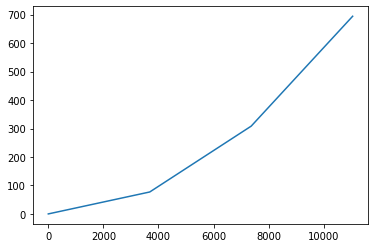

In [124]:
plt.plot(x0, z0)
plt.show()

In [125]:
rng = np.random.default_rng()
q0=np.zeros(12*node_N)

In [126]:

for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0
# #     elif j==7 or j==9 or j==11: 
#     elif j==9 or j==11: 
#         q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)
#         q0[(j-1)*node_N:j*node_N]=np.array([0.01 for x in range(node_N)])

In [127]:
q0

array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,    77.06804645,   308.4070593 ,   694.42189511,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ])

In [128]:
q0[node_N*6]=0

In [129]:
q0[node_N*8]=0

In [130]:
q0[node_N*10]=0

### Vessel

In [131]:
class VesselSemisub: # Semisub model from Fossen
    
    def __init__(self):
        
        MRB = 1.0e10 * np.array(
            [
                [0.0027, 0, 0, 0, -0.0530, 0],
                [0, 0.0027, 0, 0.0530, 0, -0.0014],
                [0, 0, 0.0027, 0, 0.0014, 0],
                [0, 0.0530, 0, 3.4775, 0, -0.0265],
                [-0.0530, 0, 0.0014, 0, 3.8150, 0],
                [0, -0.0014, 0, -0.0265, 0, 3.7192],
            ],
            float,
        )

        MA = 1.0e10 * np.array(
            [
                [0.0017, 0, 0, 0, -0.0255, 0],
                [0, 0.0042, 0, 0.0365, 0, 0],
                [0, 0, 0.0021, 0, 0, 0],
                [0, 0.0365, 0, 1.3416, 0, 0],
                [-0.0255, 0, 0, 0, 2.2267, 0],
                [0, 0, 0, 0, 0, 3.2049],
            ],
            float,
        )

        self.D = 1.0e09 * np.array(
            [
                [0.0004, 0, 0, 0, -0.0085, 0],
                [0, 0.0003, 0, 0.0067, 0, -0.0002],
                [0, 0, 0.0034, 0, 0.0017, 0],
                [0, 0.0067, 0, 4.8841, 0, -0.0034],
                [-0.0085, 0, 0.0017, 0, 7.1383, 0],
                [0, -0.0002, 0, -0.0034, 0, 0.8656],
            ],
            float,
        )

#         self.G = 1.0e10 * np.diag([0.0, 0.0, 0.0006, 1.4296, 2.6212, 0.0])
        self.G =1.0e10 *np.array([0.0, 0.0, 0.0006, 1.4296, 2.6212, 0.0])
        self.M = MRB + MA
#         print(self.G,self.M)

    def eq_left(self,η, dη):
        φ,θ,ψ=η[3:]
        Ret=Re_t_([φ,θ,ψ])
        A=Re_b(Ret)
        B=np.dot(np.linalg.inv(Π_([φ,θ,ψ])),Re_b(Ret))
        Z=np.zeros((3,3))
        C0=np.concatenate([A,Z],axis=1)
        C1=np.concatenate([Z,B],axis=1)
        C=np.concatenate([C0,C1],axis=0)

        return (np.matmul(self.D, dη) + np.dot(C,self.G))
        
    def tau(self,η, dη, ddη):
        φ,θ,ψ=η[3:]
        Ret=Re_t_([φ,θ,ψ])
        A=Re_b(Ret)
#         print(Π_([φ,θ,ψ]))
#         print(Re_b(Ret))
        B=np.dot(np.linalg.inv(Π_([φ,θ,ψ])),Re_b(Ret))
        Z=np.zeros((3,3))
        C0=np.concatenate([A,Z],axis=1)
        C1=np.concatenate([Z,B],axis=1)
        C=np.concatenate([C0,C1],axis=0)
#         print(np.dot(C,self.G))
#         print(np.matmul(self.M,ddη))
        return (np.matmul(self.M,ddη) + np.matmul(self.D, dη) + np.dot(C,self.G))
#         return (np.matmul(self.M,ddη) + np.matmul(self.D, dη) + self.G)/10000000

In [132]:
V=VesselSemisub()

In [133]:
η=np.array([0.1,0.3,0.4,0.5,0.6,0.7])
dη=np.array([0,0,0,0,0,0])
ddη=np.array([0,0,0,0,0,0])

In [134]:
tau_force = V.tau(η,dη, ddη)

In [135]:
tau_force

array([ 3.38785484e+06, -2.37412183e+06,  4.34580086e+06, -1.36399445e+10,
        3.02038732e+10,  1.28049082e+10])

In [136]:
np.matmul(np.array([[1.1,1.2],[1,2]]),np.array([1,2]))

array([3.5, 5. ])

In [137]:
# def tau_wave(z,wave_force):
# #     C=np.exp(z[-1])-np.exp(z[0])
# #     ans=[]
# #     for i in range(len(z)):
# #         ans.append([wave_force/C*(np.exp(z[i])-np.exp(z[0]))])
       
#     return np.array([0,0,wave_force]).T

In [138]:
# tau_wave(z0,wave_force)

In [139]:
# wave_force=9e6
# wave_force=9e3
# wave_force=0
# kp, kd=1.95e9,1.5e9
kp,kd=1.95e4, 1.5e4
# kp,kd=1.95e-4, 1.5e-4
wave_coef=1
# kp,kd=1.95e16, 1.5e16

In [140]:
# x,y,z,φ,θ,ψ=η
# dx,dy,dz,dφ,dθ,dψ=dη

In [141]:
def Fx(x,dx, kp, kd, x_ref = 0, dx_ref=0):
    return -kp*(x-x_ref) - kd*(dx-dx_ref)

In [142]:
# Fx(x,dx, kp, kd, x_ref = 0, dx_ref=0)

In [143]:
# def tau_t(x, dx, φ, θ, ψ, kp, kd,  x_ref = 0, dx_ref=0):
#     F=
#     Ret=Re_t_([φ,θ,ψ])  
#     return np.dot(Re_b(Ret), F)
    


In [144]:
# tau_t(x, dx, φ, θ, ψ, kp, kd)

In [145]:
Hs = 2.5 # significant wave height in m

In [146]:
def wave_force(Hs,d0,qw, Cd=1.2):
    g=9.81 
    return 0.5 * qw * g * Hs**2 * d0 * Cd

In [147]:
wave_force(Hs,d0,qw, Cd=1.2)

28695.1696875

In [148]:
η

array([0.1, 0.3, 0.4, 0.5, 0.6, 0.7])

In [149]:
def tau(η, dη, wave_coef, kp, kd,time, Hs=2.5, Tp=10, x_ref = 0, dx_ref=0):
    x,y,z,φ,θ,ψ=η
    dx,dy,dz,dφ,dθ,dψ=dη
#     print(-Fx(x,dx, kp, kd, x_ref, dx_ref))
    F=(np.array([-Fx(x,dx, kp, kd, x_ref, dx_ref),0,0])+wave_coef*np.array([0,0,wave_force(Hs,d0,qw)])).T*np.sin(2*np.pi/Tp*time+1)
#     print(F)
    Ret=Re_t_([φ,θ,ψ])
    
    return  np.concatenate([np.dot(Re_b(Ret), F),[0,0,0]], axis=0)

In [150]:
tau(η, dη, wave_coef, kp, kd,3)

array([ 4425.11907454, -2499.7415493 ,  5240.84730708,     0.        ,
           0.        ,     0.        ])

In [151]:
# η

In [152]:
# def tau(η, dη, wave_force, kp, kd,time,Tp=10, x_ref = 0, dx_ref=0):
#     x,y,z,φ,θ,ψ=η
#     dx,dy,dz,dφ,dθ,dψ=dη
# #     print(-Fx(x,dx, kp, kd, x_ref, dx_ref))
#     F=(np.array([-Fx(x,dx, kp, kd, x_ref, dx_ref),0,0])+np.array([0,0,wave_force])).T*np.sin(2*np.pi/Tp*time)
# #     print(F)
#     Ret=Re_t_([φ,θ,ψ])
    
#     return  np.concatenate([np.dot(Re_b(Ret), F),[0,0,0]], axis=0)

In [153]:
# tau(η, dη, wave_force, kp, kd,1)

In [154]:
# sampleTime = 1e-5                # sample time [seconds]
# N = int(2e5)                         # number of samples

In [155]:
# N

In [156]:
# vehicle_1=semisub('DPcontrol',0.,5.,30.0,0,0) 

In [157]:
# [simTime_1, simData_1] = simulate(N, sampleTime, vehicle_1)

In [158]:
# vehicle_2=semisub('DPcontrol',0.,-5.,30.0,0,0) 

In [159]:
# [simTime_2, simData_2] = simulate(N, sampleTime, vehicle_2)

In [160]:
# simData_1.shape

In [161]:
# simData=np.concatenate([simData_1,simData_2], axis=0)
# simData=simData_1

In [162]:
# simData.shape

In [163]:
# ans_t = simTime_1

In [164]:
# simData[250]

In [165]:
# simData.shape

In [166]:
# ans_t=[]
# sum_=0
# for i in range(simData.shape[0]):
#     ans_t.append(sum_)
#     sum_+=sampleTime

In [167]:
# plotVehicleStates(simTime_1, simData_1, 1)                    
# plotControls(simTime_1, simData_1, vehicle_1, 2)

In [168]:
# plotVehicleStates(simTime_2, simData_2, 1)                    
# plotControls(simTime_2, simData_2, vehicle_2, 2)

In [169]:
# numDataPoints = 5                 # number of 3D data points
# FPS = 10                            # frames per second (animated GIF)
# filename = '3D_animation.gif'       # data file for animated GIF
# browser = 'safari'                  # browser for visualization of animated GIF

In [170]:
# plot3D(simData, numDataPoints, FPS, filename, 3)  

### Modelling

In [171]:
# def find_nearest(array, value):
#     array = np.asarray(array)
#     idx = (np.abs(array - value)).argmin()
#     return idx

In [172]:
# simData[1]

In [173]:
# simD_1=np.insert(simData_1, 0, simData_1[0], axis=0)
# simD_2=np.insert(simData_2, 0, simData_2[0], axis=0)

In [174]:
# diff_1=np.diff(simD_1,axis=0)
# diff_2=np.diff(simD_2,axis=0)

In [175]:
# diff=np.concatenate([diff_1,diff_2], axis=0)

In [176]:
# diff=diff_1

In [177]:
V=VesselSemisub()

In [178]:
# thres =0.1

In [179]:
# def retrieve_name(var):
#     callers_local_vars = inspect.currentframe().f_back.f_locals.items()
#     return [var_name for var_name, var_val in callers_local_vars if var_val is var]

In [180]:
# simD=np.concatenate([simD_1,simD_2], axis=0)

In [181]:
# simD = simD_1

In [182]:
# SD0=simD[:, 0]
# SD1=simD[:, 1]
# SD2=simD[:, 2]
# SD3=simD[:, 3]
# SD4=simD[:, 4]
# SD5=simD[:, 5]
# SD6=simD[:, 6]
# SD7=simD[:, 7]
# SD8=simD[:, 8]
# SD9=simD[:, 9]
# SD10=simD[:, 10]
# SD11=simD[:, 11]
# Diff6=diff[:, 6]
# Diff7=diff[:, 7]
# Diff8=diff[:, 8]
# Diff9=diff[:, 9]
# Diff10=diff[:, 10]
# Diff11=diff[:, 11]

In [183]:
# def feedback(Q):
#     x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
#     dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
#     φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
#     dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]

#     K = 2e6 # feedback gain
#     u_x = -K * x 
#     u_y = -K * y
#     u_z = -K * z 
#     u_dx = -K * dx 
#     u_dy = -K * dy 
#     u_dz = -K * dz 
#     u_φ = -K * φ 
#     u_θ = -K * θ
#     u_ψ = -K * ψ 
#     u_dφ= -K * dφ 
#     u_dθ = -K * dθ 
#     u_dψ = -K * dψ 
#     return np.concatenate([u_x, u_dx, u_y, u_dy, u_z, u_dz, u_φ, u_dφ, u_θ, u_dθ, u_ψ, u_dψ], axis=0) 

In [184]:
# def Jv(x, y, z):
    
#     def Jv0(k,x0,x1,y0,y1,z0,z1):
#         tmp1=(x0+x1)/2 
#         tmp2=(y0+y1)/2
#         tmp3=(z0+z1)/2 
#         return np.array([tmp1, tmp2, tmp3]).T 
# #         else:
# #             return np.array([0, 0, 0]).T 
    
#     ans=np.array([Jv0(k, x[k-1],x[k], y[k-1], y[k], z[k-1], z[k]) for k in range(1,node_N)])
    
#     return np.concatenate([ans,np.array([0, 0, 0]).reshape(3,1).T], axis=0).T

In [185]:
# x, y, z = q0[0:node_N],q0[2*node_N:3*node_N],q0[4*node_N:5*node_N]

In [186]:
# q0

In [187]:
# Jv(x, y, z )

In [188]:
# class Time:
#     def __init__(self):
#         self.time=1
# # #         self.n=1
# # # #         self.my_max = sampleTime*N*2
# #         self.my_time=0
# # # #         self.my_n=0
# #         self.my_update=up

In [189]:
# co=Time()

In [190]:
# def asymptote(t):
#     return t/np.sqrt(t**2+1)

In [191]:
from scipy.integrate import solve_ivp

In [192]:
# def grayscott1d(Q,p,t):
def grayscott1d(t, Q):
#     Q,t=np.array(Q),np.array(t)
    print(t)
#     dt=0
#     dt=abs(t-co.time)
#     print('dt',t,co.time,dt)
#     co.time+=sampleTime
  
#     if co.my_time%co.my_max==0:
#         co.my_n+=1
        
#     co.my_time+=co.my_update     
    
#     print(Q)   
#     print(abs(co.my_time))
    
#     idx = find_nearest(ans_t,  co.my_time%len(ans_t)) #!!!!!!!!!!!!!!!!!!!!!
#     print(idx)
#     idx = find_nearest(ans_t,  t%len(ans_t)) 
#     print('idx',idx)
#     print(t)
#     print(idx)
#     ind=ans_t.index(val)
    # State vectors
#     x_ve = SD0[idx]
#     y_ve = SD1[idx]
#     z_ve = SD2[idx]
#     print(x_ve,y_ve,z_ve)
#     phi_ve = R2D(ssa(SD3[idx]))
#     theta_ve = R2D(ssa(SD4[idx]))
#     psi_v = R2D(ssa(SD5[idx]))
#     phi_ve = ssa(SD3[idx])
#     theta_ve = ssa(SD4[idx])
#     psi_v = ssa(SD5[idx])
#     phi_ve = SD3[idx]
#     theta_ve = SD4[idx]
#     psi_v = SD5[idx]
#     u_ve = SD6[idx]
#     v_ve = SD7[idx]
#     w_ve = SD8[idx]
#     p_ve = SD9[idx]
#     q_ve = SD10[idx]
#     r_ve = SD11[idx]
#     p_ve = ssa(SD9[idx])
#     q_ve = ssa(SD10[idx])
#     r_ve = ssa(SD11[idx])
    
    
#     print(t-co.time)
#     du_ve = Diff6[idx]/sampleTime
#     dv_ve = Diff7[idx]/sampleTime
#     dw_ve = Diff8[idx]/sampleTime
#     dp_ve = Diff9[idx]/sampleTime
#     dq_ve = Diff10[idx]/sampleTime
#     dr_ve = Diff11[idx]/sampleTime
#     print(u_ve, dr_ve )
    
#     co.time=t
#     co.n+=1
#     print(co.time)
#     η=np.array([ x_ve, y_ve, z_ve,phi_ve, theta_ve,  psi_v])
#     dη=np.array([u_ve, v_ve, w_ve, p_ve, q_ve, r_ve])
    
#     ddη=np.array([du_ve, dv_ve, dw_ve, dp_ve, dq_ve, dr_ve])
#     print( dη)
#     print(ddη)
    
#     tau_force = V.tau(η,dη, ddη)*asymptote(t)
#     tau_force = V.tau(η,dη, ddη)
#     co.time += 1
#     print(tau_force )
#     print()
    
    
    
    
#     p_ve = R2D(simData[:, 9][idx])
#     q_ve = R2D(simData[:, 10][idx])
#     r_ve = R2D(simData[:, 11][idx])

#     if t>dt*co.count:
#         co.count+=1
        
#     print(type(Q))
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
#     print(x0[-1],y0[-1])

#     x[-1]=x_ve+x0[-1]
#     y[-1]=y_ve
#     z[-1]=z_ve+z0[-1]

#     print( x[-1], y[-1], z[-1])
    x[0]=0
    y[0]=0
    z[0]=0
#     print(z)
#     print(z_ve)
#     print(x_ve,y_ve,z_ve)
#     print(x[0],y[0],z[0])
#     print(x[-1],y[-1],z[-1])
#     print()
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    
    dx[0]=0
    dy[0]=0
    dz[0]=0
    
    
#     dx[-1]=u_ve
#     dy[-1]=v_ve 
#     dz[-1]=w_ve
#     print(dx,dy.shape, dx.shape)
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    
  
    
    
    
    Ret = Re_t(φ,θ,ψ)
#     print(Ret)
    
#     φ[-1]=phi_ve
#     θ[-1]=theta_ve
#     ψ[-1]=psi_v
    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    dη=[dx[-1],dy[-1],dz[-1],dφ[-1],dθ[-1],dψ[-1]]
    
    left=V.eq_left(η,dη)
#     print(left.shape)
#     print(tau(η, dη, wave_force, 0, 0, t))


    # PD controller after 30 sec
#     if t<30:
#         ddη=np.linalg.lstsq(V.M, -left + tau(η, dη, wave_force, Fx_0/η[0], 0, t), rcond=None)[0]
#     else:
#     print(η,dη)
#     print('M',V.M)
#     print('C0',-left + tau(η,dη, wave_coef, kp, kd, t))
    ddη=np.linalg.lstsq(V.M*1e6, -left + tau(η,dη, wave_coef, kp, kd, t)
                        , rcond=None)[0]
#     print( ddη)
 
    tau_force = V.tau(η,dη,ddη)
#     print(tau_force)
#     print(η,dη,ddη)
#     print(tau_force)
    
#     dφ[-1]=p_ve
#     dθ[-1]= q_ve
#     dψ[-1]=r_ve
#     print(z)    
#     print(t)
    
#     ddx = np.empty_like(y)
#     ddy = np.empty_like(y)
#     ddz = np.empty_like(y)
#     ddφ = np.empty_like(y)
#     ddθ = np.empty_like(y)
#     ddψ= np.empty_like(y)
    C=ne(x,y,z,Ret)
#     print('C',C)
  
    a,b,c=C[:,0],C[:,1],C[:,2]
#     print('abc',a,b,c)
#     print(a,C)
#     print(a)
    
#     for it in [φ,θ,ψ,x,y,z,dx,dy,dz]:
#         print(it)
    # here single Re_b(φ,θ,ψ) etc.
#     print(np.einsum('ijk,ik->ij', Re_b(φ,θ,ψ).astype(float), ne_(x,y,z,dx,dy,dz).astype(float).T))
#     print(ne_(x,y,z,dx,dy,dz).astype(float))
#     Z0=np.zeros((node_N,3))
#     print(tau_force[:3].shape)
#     Z0[-1]=tau_force[:3]
#     print(Z0)
#     Z0=np.dot(Jv(x, y, z ).T,tau_force[:3]).reshape(node_N,1)
#     print(Z0)
#     print()
#     Z0=np.dot(Re_b(Ret),tau_force[:3])
    Z0=tau_force[:3]
#     print(Z0)
#     Z0=tau_force[:3].T
#     print(Z0)
    Z1 = d_s(a,b,c,x,y,z).T
#     print(Z1.shape)
#     Z2 =np.einsum('ijk,ik->ij', Re_b(Ret), ne_(x,y,z,dx,dy,dz,Ret).T)
#     print(Z1,Z2)
    Z2=ne_(x,y,z,dx,dy,dz,Ret).T
#     print(Z0)
#     Z=(np.einsum('ijk,ik->ij', Re_b(Ret), Z1 + Z2) 
    Z= ( Z1 + Z2 
        + Z0 
       )
#     print(Z1,Z2, - Z0,Z)
#     print()
#     print(Z0,Z1,Z2)
#     print(Z)
    
    
#     if np.isnan(np.sum(Z0)):
#         print('Z0 NaN',np.isnan(np.sum(Z0)))
#     if max(abs(np.amax(Z0)), abs(np.amin(Z0)))>thres :
#         print('Z0', Z0) 
                  
#     if np.isnan(np.sum(Z1)):
#         print('Z1 NaN',np.isnan(np.sum(Z1)))
#     if max(abs(np.amax(Z1)), abs(np.amin(Z1)))>thres :
#         print('Z1', Z1)    
                  
#     if np.isnan(np.sum(Z2)):
#         print('Z2 NaN',np.isnan(np.sum(Z2)))
#     if max(abs(np.amax(Z2)), abs(np.amin(Z2)))>thres :
#         print('Z2', Z2)      
#     print(Z.shape)
    
#     ddx,ddy, ddz = 1/Ws*torch.linalg.lstsq(torch.from_numpy(Re_b(Ret).astype(np.float64)),torch.from_numpy(Z.astype(np.float64))).solution.cpu().numpy().T
############################################################    
#     ddx,ddy, ddz = 1/Ws*np.linalg.solve(Re_b(Ret),Z).T 
############################################################    
    ans_x=[]
    ans_y=[]
    ans_z=[]
    RRRR=Re_b(Ret)
    for i in range(len(RRRR)):
        a,b,c=1/Ws*np.linalg.lstsq(RRRR[i],Z[i], rcond=None)[0]
        ans_x.append(a)
        ans_y.append(b)
        ans_z.append(c)
    
    ddx,ddy, ddz = np.array(ans_x),np.array(ans_y),np.array(ans_z)    
    
    
#     print(ddx,ddy, ddz)
#     print(ddx,ddy, ddz)
#     print('ddx',ddx)  
#     print('ddy',ddy) 
#     print('ddz',ddz) 
    
    me_=me(φ,θ,ψ,x,y,z,Ret)
#     print(Re_b(φ,θ,ψ).shape)
#     print(Irho_e(φ,θ,ψ).shape)
#     print(Irho_e(φ,θ,ψ).shape)

    
#     C1=np.einsum('ijk,ik->ij', Re_b(Ret).astype(np.float32), np.einsum('ijk,ik->ij', Irho_e(Ret).astype(np.float32),
#                                                         np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float32), 
#                                                                   np.array([dφ,dθ,dψ]).astype(np.float32).T)))
    C1=np.einsum('ijk,ik->ij', Irho_e(Ret).astype(np.float32),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float32), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float32).T))
    
    C2= np.cross(np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T),
                 np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float32),
                           np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)))
    
#     print(Re_b(φ,θ,ψ).shape)
# #     print(me_)
# #     print(me_[:,0])
#     print(d_s(me_[:,0],me_[:,1],me_[:,2],dt,ds).shape)
# #     print(Irho_e(φ,θ,ψ).shape)
#     print(d_s(me_[:,0],me_[:,1],me_[:, 2],dt,ds))
#     print(me_)
#     print('d_s',d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z))
#     C3= np.einsum('ijk,ik->ij',Re_b(Ret).astype(np.float32),d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z).astype(np.float32).T)
    C3= d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z).astype(np.float32).T
#     C3=np.einsum('ijk,ik->ij', Re_b(Ret),C3_)
#     print(C3.shape)
#     print(d_s(x,y,z,dt,ds).shape)
#     print(ne(x,y,z,φ,θ,ψ,dt,ds).T.shape)
    C4= np.cross(d_s(x,y,z,x,y,z).T,ne(x,y,z,Ret))
#     print(np.dot(DR,K).shape)
#     print(Re_b(φ,θ,ψ).shape)
#     print(np.dot(DR,K[:,0]))

    K1=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T).T
#     print('K1',np.array([dφ,dθ,dψ]))
#     C5= np.einsum('ijk,ik->ij',Re_b(Ret).astype(np.float32),-np.dot(DR,K1).astype(np.float32).T)
    C5= -np.dot(DR,K1).astype(np.float32).T
#     if np.isnan(np.sum(C1)):
#         print('C1',np.isnan(np.sum(C1)))
#     if np.isnan(np.sum(C2)):    
#         print('C2',np.isnan(np.sum(C2)))
#     if np.isnan(np.sum(C3)):    
#         print('C3',np.isnan(np.sum(C3)))
#     if np.isnan(np.sum(C4)):    
#         print('C4',np.isnan(np.sum(C4)))
#     if np.isnan(np.sum(C5)):    
#         print('C5',np.isnan(np.sum(C5)))
#     print(C5.shape)    
#     C0=np.zeros((node_N,3))
#     C0[-1]=tau_force[3:]
#     print(Π(φ,θ,ψ).shape)
#     print(Re_b(Ret).shape)
#     print(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ)),Re_b(Ret)).shape)
    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
#     print(tau_force[3:])
#     print(C0.shape)
#     .reshape(node_N,3)
#     print(np.einsum('ijk,ikr->ijr',Π(φ,θ,ψ),Re_b(Ret)).shape)
#     if np.isnan(np.sum(C0)):
#         print('C0',np.isnan(np.sum(C0)))
#     for a in [C1,C2,C3,C4,C5,C0]:   
#         if max(abs(np.amax(a)), abs(np.amin(a)))>thres :
#             print('{}'.format( retrieve_name(a)),a)
    
    B_ =(-C1-C2+C3+C4+C5)
    B=(np.einsum('ijk,ik->ij', Re_b(Ret), B_)
       -C0.squeeze()
      )
#     print(B.shape,C0.squeeze().shape)
#     print(B.shape)
#     print(C0, C0.squeeze())
#     print(B)
#     print(B.shape)
#     print(Re_b(φ,θ,ψ).shape)
#     print(Irho_e(φ,θ,ψ).shape)
#     print(Π(φ,θ,ψ).shape)
#     A1 =Re_b(Ret).astype(np.float32)
    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)
#     print(np.einsum('ijk,ijk->ijk',A1,A2))
#     print('A1',A1)
#     print(A1)
#     print('bu',A1[0])
#     print('hey', np.dot(A1[0],A2[0]))
#     print('op', np.einsum('ijk,ikr->ijr',A1,A2))
#     print(Π(φ,θ,ψ).shape)
#     A=np.einsum('ijk,ikr->ijr',np.einsum('ijk,ikr->ijr',A1,A2),A3)
    A=np.einsum('ijk,ikr->ijr',A2,A3)
#     print(B,A)    
#     if np.isnan(np.sum(A)):     
#         print('A',np.isnan(np.sum(A)))
      
#     if max(abs(np.amax(A)), abs(np.amin(A)))>thres :
#         print('A', A)   
   

#     if np.isnan(np.sum(B)):     
#         print('B',np.isnan(np.sum(B)))
      
#     if max(abs(np.amax(B)), abs(np.amin(B)))>thres :
#         print('B', B)  
#     print(A)
#     print()
#     print()


#     print(A.shape)
#     print(B.shape)
#     print(np.linalg.solve(A,B) ) 

#     print(A.shape,B.shape)
############################################
#     ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################




#     ddφ,ddθ,ddψ = torch.linalg.lstsq(torch.from_numpy(A.astype(np.float64)),torch.from_numpy(B.astype(np.float64))).solution.cpu().numpy().T
    
#     test1 = np.concatenate([ddφ,ddθ,ddψ])
    
#     if np.isnan(np.sum(test1)):     
#         print('test1 NaN',np.isnan(np.sum(test1)))
      
#     if max(abs(np.amax(test1)), abs(np.amin(test1)))>thres :
#         print('test1', test1)
#     torch.from_numpy(A),torch.from_numpy(B))
    ans_φ=[]
    ans_θ=[]
    ans_ψ=[]
    for i in range(len(A)):
        a,b,c=np.linalg.lstsq(A[i],B[i], rcond=None)[0]
        ans_φ.append(a)
        ans_θ.append(b)
        ans_ψ.append(c)
    
    ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
    
    
#     print(ans_ψ)
#     ddφ,ddθ,ddψ =np.linalg.lstsq(A,B,rcond=-1).T 
#     ddφ,ddθ,ddψ =torch.linalg.tensorsolve(torch.from_numpy(A),torch.from_numpy(B)).T
#     print(ddφ)
#     print(np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ]))
    
    # is it the right order ?
#     print('dx',dx)
#     print('dy',dy)
#     print('dz',dz)
    
#     A1111=np.concatenate(np.stack([dx,ddx, dy, ddy, dz, ddz dφ, dθ, dψ, , ddy, ddφ, ddθ, ddψ], axis=0).T) 
    A1111=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0) 
#     if np.isnan(np.sum(A1111)): 
#         print('A1111 NaN',np.isnan(np.sum(A1111)))
#     if np.amax(A1111)>thres :
#         print('A1111', A1111)  
        
        
#     print(A1111)
#     print(A1111)
    
#     print(A)
#     print()
#     print(A1111)
#     print(A1111)
#     return torch.from_numpy(A1111)

#     return A1111+feedback(Q)
#     print(φ,θ,ψ)
#     print(Ret)
#     if np.isnan(np.sum(φ)):     
#         print('φ',np.isnan(np.sum(φ)))
#     if np.isnan(np.sum(θ)):     
#         print('θ',np.isnan(np.sum(θ)))
#     if np.isnan(np.sum(ψ)):     
#         print('ψ',np.isnan(np.sum(ψ))) 
    print(A1111)
    return A1111

In [193]:
# q0[7*node_N:8*node_N],q0[9*node_N:10*node_N],q0[11*node_N:12*node_N]

In [194]:
# for i in range(1000):
#     Q1111=100*rng.standard_normal(12*node_N)
#     print(grayscott1d(Q1111, 0.1, simData))

In [195]:
# q0.shape

In [196]:
# import numpy as np

In [197]:
# np.concatenate([np.array([0,3,6]),np.array([1,4,7]),np.array([2,5,8])], axis=0)

In [198]:
# # q0=[i for i in range(12)]
# max_t =2 #0.1 # 10 #600  
# dt = 0.5
# t=np.arange(0,max_t,dt)
# # ds = 0.025
# print(t)

In [199]:
# grayscott1d(4,q0)

In [200]:
# grayscott1d(4,q0).shape

In [201]:
# # q0=[i for i in range(12)]
# max_t = 2 # 10 #600  
# dt = 0.5
# t=np.arange(0,max_t,dt)
# ds = 0.025
# print(t)

In [202]:
import scipy

In [203]:
# ode15s = scipy.integrate.ode(grayscott1d)
# ode15s.set_integrator('vode', method='bdf', order=15, nsteps=3000)
# # ode15s.set_integrator('vode',  order=15, nsteps=3000)
# ode15s.set_initial_value(q0, 0)

In [204]:
# tspan = (0., 60)
tspan = (0., 5)

In [205]:
q0

array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,    77.06804645,   308.4070593 ,   694.42189511,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ])

In [206]:
startTime1 = datetime.now()
# prob = de.ODEProblem(grayscott1d, q0, tspan)
# us = de.solve(prob)
us=solve_ivp(grayscott1d,  tspan, q0, 
             method='BDF'
#              ,rtol=1, atol=1
            )
# us=ode15s.integrate(3)
print(datetime.now() - startTime1)

0.0
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.92575619e-01  2.88279291e+02 -3.09905564e-01 -8.04521257e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.13694789e-16  1.13694789e-16  1.13694789e-16  1.13694789e-16
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  6.37090751e+03  6.37693382e+03  6.38291804e+03  6.38281362e+03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.42959857e+08 -1.42959857e+08 -1.42959857e+08 -1.42959857e+08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.62119738e+08 -2.62119738e+08 -2.62119738e+08 -2.62119738e+08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.70210512e-13  1.70210512e-13  1.70210512e-13  1.70210512e-13]
4.102018172850463e-14
[ 0.00000000e+00  1.18252689e-11 -1.27123826e-14 -3.30016082e-14
  2.89621154e-01  2.88376336e+02 -2.12860030e-01 -7.07475723e-01
  0.00000000e+00  4.66378091e-30  4.66378091e-30  4.66378091e-3

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.92575619e-01  2.88279291e+02 -3.09905564e-01 -8.04521257e-01
  0.00000000e+00  0.00000000e+00  1.49011612e-14  0.00000000e+00
  1.13694789e-16  1.13694789e-16  1.13694789e-16  1.13694789e-16
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  6.37090751e+03  6.37693382e+03  6.38291804e+03  6.38281362e+03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.42959857e+08 -1.42959857e+08 -1.42959857e+08 -1.42959857e+08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.62119738e+08 -2.62119738e+08 -2.62119738e+08 -2.62119738e+08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.70210512e-13  1.70210512e-13  1.70210512e-13  1.70210512e-13]
0.0
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.92575619e-01  2.88279291e+02 -3.09905564e-01 -8.04521257e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.49011612e-14
  4.74691581e-12  4.

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.92575619e-01  2.88279291e+02 -3.09905564e-01 -8.04521257e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.13694789e-16  1.13694789e-16  1.13694789e-16  1.13694789e-16
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  6.37090751e+03  6.37693382e+03  6.38291804e+03  6.38281362e+03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.42959857e+08 -1.42959857e+08 -1.42959857e+08 -1.42959857e+08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.62119738e+08 -2.62119738e+08 -2.62119738e+08 -2.62119738e+08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.70210512e-13 -2.14576721e-06  1.70210512e-13  1.70210512e-13]
0.0
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.92575619e-01  2.88279291e+02 -3.09905565e-01 -8.04521257e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.13694789e-16  1.

[ 0.00000000e+00  7.66265810e-10  6.10903937e-12  4.80619965e-12
  6.42370290e+00  2.94510418e+02  5.92122171e+00  5.42660602e+00
  0.00000000e+00 -2.97729942e-12 -2.97729942e-12 -2.97729942e-12
 -2.67884607e+00 -2.67884607e+00 -2.67884607e+00 -2.67884607e+00
  0.00000000e+00  1.67957421e-08  1.68115048e-08  1.68112298e-08
  6.36966135e+03  6.37568765e+03  6.38167187e+03  6.38156745e+03
 -3.76542179e-04 -3.76542179e-04 -3.76542179e-04 -3.76542179e-04
 -1.42941466e+08 -1.42941466e+08 -1.42941466e+08 -1.42941466e+08
 -6.90380269e-04 -6.90380269e-04 -6.90380269e-04 -6.90380269e-04
 -2.62070457e+08 -2.62070457e+08 -2.62070457e+08 -2.62070457e+08
 -7.11434233e-12 -7.11434233e-12 -7.11434233e-12 -7.11434233e-12
 -6.40117940e+00 -6.40117940e+00 -6.40117940e+00 -6.40117940e+00]
2.634044452006159e-12
[ 0.00000000e+00  7.70268751e-10  1.01119800e-11  8.80914023e-12
  6.42341716e+00  2.94510132e+02  5.92093597e+00  5.42632028e+00
  0.00000000e+00 -4.69826094e-12 -4.69826094e-12 -4.69826094e-12
 -

[ 0.00000000e+00  4.89618498e-05  4.69932614e-05  4.69898874e-05
  1.27836639e+04  1.30717506e+04  1.27831614e+04  1.27826668e+04
  0.00000000e+00 -2.12197105e-05 -2.12197105e-05 -2.12197105e-05
 -5.90142559e+03 -5.90142559e+03 -5.90142559e+03 -5.90142559e+03
  0.00000000e+00  3.41011384e-05  3.41419593e-05  3.41412470e-05
  3.81434042e+03  3.82036672e+03  3.82635095e+03  3.82624653e+03
 -8.29512806e-01 -8.29512806e-01 -8.29512806e-01 -8.29512806e-01
 -1.02445663e+08 -1.02445663e+08 -1.02445663e+08 -1.02445663e+08
 -1.41634767e+00 -1.41634767e+00 -1.41634767e+00 -1.41634767e+00
 -1.61016689e+08 -1.61016689e+08 -1.61016689e+08 -1.61016689e+08
 -5.01853796e-05 -5.01853796e-05 -5.01853796e-05 -5.01853796e-05
 -1.38825386e+04 -1.38825386e+04 -1.38825386e+04 -1.38825386e+04]
6.821420859440822e-09
[ 0.00000000e+00  4.90727111e-05  4.71041226e-05  4.71007487e-05
  1.27757504e+04  1.30638371e+04  1.27752479e+04  1.27747533e+04
  0.00000000e+00 -2.12379073e-05 -2.12379073e-05 -2.12379073e-05
 -

[ 0.00000000e+00  1.79782939e-03  1.77834551e-03  1.77831211e-03
  3.27826707e+04  3.30707574e+04  3.27821682e+04  3.27816736e+04
  0.00000000e+00 -9.95716062e-04 -9.95716062e-04 -9.95716062e-04
 -2.00342732e+04 -2.00342732e+04 -2.00342732e+04 -2.00342732e+04
  0.00000000e+00  7.48807468e-05  7.52847690e-05  7.52777191e-05
 -1.85174800e+02 -1.79148553e+02 -1.73164274e+02 -1.73268694e+02
 -2.81606302e+00 -2.81606302e+00 -2.81606302e+00 -2.81606302e+00
 -5.42066854e+06 -5.42066854e+06 -5.42066854e+06 -5.42066854e+06
 -3.63206440e+00 -3.63206440e+00 -3.63206440e+00 -3.63206440e+00
 -2.85219077e+06 -2.85219077e+06 -2.85219077e+06 -2.85219077e+06
 -2.12041594e-03 -2.12041594e-03 -2.12041594e-03 -2.12041594e-03
 -3.86785821e+04 -3.86785821e+04 -3.86785821e+04 -3.86785821e+04]
6.751426773053755e-08
[ 0.00000000e+00  1.79623696e-03  1.77675308e-03  1.77671968e-03
  3.28963356e+04  3.31844223e+04  3.28958331e+04  3.28953385e+04
  0.00000000e+00 -9.95179435e-04 -9.95179435e-04 -9.95179435e-04
 -

[ 0.00000000e+00  7.84116738e-03  7.76947406e-03  7.76935118e-03
  3.31454358e+04  3.34335222e+04  3.31449330e+04  3.31444384e+04
  0.00000000e+00 -4.74684917e-03 -4.74684917e-03 -4.74684917e-03
 -2.08239174e+04 -2.08239172e+04 -2.08239172e+04 -2.08239172e+04
  0.00000000e+00  3.04154959e-05  3.19022445e-05  3.18763037e-05
 -2.57409631e+02 -2.51383576e+02 -2.45399106e+02 -2.45503526e+02
 -2.92704042e+00 -2.92704042e+00 -2.92704042e+00 -2.92704042e+00
 -3.48121295e+02 -3.48121295e+02 -3.48121295e+02 -3.48121295e+02
 -3.67197566e+00 -3.67197566e+00 -3.67197566e+00 -3.67197566e+00
 -2.69775500e+03 -2.69775500e+03 -2.69775500e+03 -2.69775500e+03
 -7.19325489e-03 -7.19325489e-03 -7.19325489e-03 -7.19325489e-03
 -1.85460348e+04 -1.85460348e+04 -1.85460348e+04 -1.85460348e+04]
3.1273299855754053e-07
[ 0.00000000e+00  9.99090468e-03  9.90065332e-03  9.90049864e-03
  3.31671904e+04  3.34552765e+04  3.31666873e+04  3.31661927e+04
  0.00000000e+00 -6.08479882e-03 -6.08479882e-03 -6.08479882e-03
 

[ 0.00000000e+00  3.69359113e-02  3.66131273e-02  3.66125740e-02
  3.31578219e+04  3.34459003e+04  3.31573113e+04  3.31568167e+04
  0.00000000e+00 -2.28668956e-02 -2.28668956e-02 -2.28668956e-02
 -2.08275177e+04 -2.08275145e+04 -2.08275145e+04 -2.08275145e+04
  0.00000000e+00 -1.88741427e-04 -1.82047490e-04 -1.82164283e-04
 -2.58372627e+02 -2.52347465e+02 -2.46362074e+02 -2.46466492e+02
 -2.92686211e+00 -2.92686211e+00 -2.92686211e+00 -2.92686211e+00
 -7.98702454e+03 -7.98702454e+03 -7.98702454e+03 -7.98702454e+03
 -3.67199298e+00 -3.67199298e+00 -3.67199298e+00 -3.67199298e+00
  9.95205677e+02  9.95205679e+02  9.95205684e+02  9.95205688e+02
 -1.13659557e-02 -1.13659557e-02 -1.13659557e-02 -1.13659557e-02
 -1.67887999e+02 -1.67887999e+02 -1.67887999e+02 -1.67887999e+02]
1.1184898021082648e-06
[ 0.00000000e+00  3.69359131e-02  3.66131291e-02  3.66125758e-02
  3.31576943e+04  3.34457728e+04  3.31571837e+04  3.31566891e+04
  0.00000000e+00 -2.28668699e-02 -2.28668699e-02 -2.28668699e-02
 

  8.39135820e+01  8.39135820e+01  8.39135820e+01  8.39135820e+01]
1.1855295344785108e-05
[ 0.00000000e+00  3.96835332e-01  3.93414084e-01  3.93408220e-01
  3.33051433e+04  3.35922706e+04  3.33036982e+04  3.33032036e+04
  0.00000000e+00 -2.46875158e-01 -2.46875160e-01 -2.46875160e-01
 -2.08978238e+04 -2.08974525e+04 -2.08974528e+04 -2.08974528e+04
  0.00000000e+00 -2.95718795e-03 -2.88616848e-03 -2.88740628e-03
 -2.69317122e+02 -2.63298894e+02 -2.57302232e+02 -2.57406629e+02
 -2.92671897e+00 -2.92671897e+00 -2.92671897e+00 -2.92671897e+00
  2.82893838e+01  2.82893838e+01  2.82893838e+01  2.82893838e+01
 -3.67155387e+00 -3.67155387e+00 -3.67155387e+00 -3.67155386e+00
  3.98755538e+01  3.98758046e+01  3.98763042e+01  3.98767973e+01
 -1.05242128e-02 -1.05242128e-02 -1.05242128e-02 -1.05242128e-02
  8.60327043e+01  8.60327043e+01  8.60327042e+01  8.60327042e+01]
1.1855295344785108e-05
[ 0.00000000e+00  3.96839424e-01  3.93418185e-01  3.93412321e-01
  3.33051450e+04  3.35922723e+04  3.330369

6.456447818918172e-05
[ 0.00000000e+00  2.18613917e+00  2.16751722e+00  2.16748530e+00
  3.40382637e+04  3.42972276e+04  3.40091340e+04  3.40086402e+04
  0.00000000e+00 -1.35715108e+00 -1.35715112e+00 -1.35715112e+00
 -2.12405522e+04 -2.12293280e+04 -2.12293293e+04 -2.12293293e+04
  0.00000000e+00 -1.83800432e-02 -1.79915361e-02 -1.79982730e-02
 -3.29955304e+02 -3.23845237e+02 -3.17795850e+02 -3.17900097e+02
 -2.92519495e+00 -2.92519495e+00 -2.92519495e+00 -2.92519495e+00
  2.91563360e+01  2.91563357e+01  2.91563353e+01  2.91563348e+01
 -3.66943784e+00 -3.66943768e+00 -3.66943736e+00 -3.66943705e+00
  4.05413284e+01  4.05487863e+01  4.05636372e+01  4.05782939e+01
 -6.10403059e-03 -6.10403059e-03 -6.10403060e-03 -6.10403060e-03
  8.38200346e+01  8.38200342e+01  8.38200335e+01  8.38200329e+01]
6.456447818918172e-05
[ 0.00000000e+00  2.18614527e+00  2.16752331e+00  2.16749140e+00
  3.40382663e+04  3.42972301e+04  3.40091364e+04  3.40086426e+04
  0.00000000e+00 -1.35715406e+00 -1.35715411e

[ 0.00000000e+00  7.89312126e+00  7.82831754e+00  7.82820646e+00
  3.63774120e+04  3.62858422e+04  3.60034669e+04  3.60029828e+04
  0.00000000e+00 -4.86605158e+00 -4.86605211e+00 -4.86605211e+00
 -2.23235307e+04 -2.21792142e+04 -2.21792190e+04 -2.21792189e+04
  0.00000000e+00 -9.09012381e-02 -8.95237800e-02 -8.95472965e-02
 -6.08928893e+02 -6.00445520e+02 -5.94262788e+02 -5.94366075e+02
 -2.92036882e+00 -2.92036881e+00 -2.92036880e+00 -2.92036880e+00
  3.05500435e+01  3.05500337e+01  3.05500136e+01  3.05499936e+01
 -3.66271560e+00 -3.66270870e+00 -3.66269498e+00 -3.66268144e+00
  4.25315624e+01  4.26229650e+01  4.28049716e+01  4.29846017e+01
  7.40721112e-03  7.40721025e-03  7.40720845e-03  7.40720682e-03
  8.34288028e+01  8.34287898e+01  8.34287645e+01  8.34287389e+01]
0.00022616521571208775
[ 0.00000000e+00  7.89308898e+00  7.82828535e+00  7.82817427e+00
  3.63773982e+04  3.62858315e+04  3.60034562e+04  3.60029721e+04
  0.00000000e+00 -4.86604188e+00 -4.86604241e+00 -4.86604240e+00
 

[ 0.00000000e+00  1.99333292e+01  1.97828810e+01  1.97826230e+01
  4.13149286e+04  3.91816716e+04  3.89295092e+04  3.89290767e+04
  0.00000000e+00 -1.21713497e+01 -1.21713532e+01 -1.21713532e+01
 -2.45762691e+04 -2.36728850e+04 -2.36729010e+04 -2.36729010e+04
  0.00000000e+00 -4.54032460e-01 -4.50663752e-01 -4.50719453e-01
 -1.96346561e+03 -1.92431299e+03 -1.91800323e+03 -1.91810149e+03
 -2.91027973e+00 -2.91027974e+00 -2.91027976e+00 -2.91027979e+00
  3.27559055e+01  3.27557601e+01  3.27554678e+01  3.27551800e+01
 -3.64885762e+00 -3.64876183e+00 -3.64857108e+00 -3.64838282e+00
  4.41632617e+01  4.46906232e+01  4.57407446e+01  4.67771491e+01
  3.38335664e-02  3.38335408e-02  3.38334920e-02  3.38334432e-02
  8.27901132e+01  8.27899307e+01  8.27895866e+01  8.27892408e+01]
0.0005959873068320129
[ 0.00000000e+00  2.19721209e+01  2.18087887e+01  2.18085087e+01
  4.21509545e+04  3.94970530e+04  3.92520562e+04  3.92516359e+04
  0.00000000e+00 -1.34030100e+01 -1.34030145e+01 -1.34030145e+01
 -

[ 0.00000000e+00  4.10309407e+01  4.07705048e+01  4.07700585e+01
  4.99394338e+04  3.99681492e+04  3.98094223e+04  3.98091539e+04
  0.00000000e+00 -2.50010214e+01 -2.50010536e+01 -2.50010533e+01
 -2.85013821e+04 -2.46572855e+04 -2.46574188e+04 -2.46574175e+04
  0.00000000e+00 -3.40184710e+00 -3.39518614e+00 -3.39528740e+00
 -1.27108385e+04 -1.21828650e+04 -1.21767754e+04 -1.21768430e+04
 -2.89244275e+00 -2.89244305e+00 -2.89244365e+00 -2.89244424e+00
  3.44237720e+01  3.44226001e+01  3.44202355e+01  3.44179180e+01
 -3.62638618e+00 -3.62565872e+00 -3.62421012e+00 -3.62278044e+00
  4.00023354e+01  4.20333078e+01  4.60775978e+01  5.00690209e+01
  7.72472947e-02  7.72469179e-02  7.72462297e-02  7.72455306e-02
  8.20388286e+01  8.20374115e+01  8.20348834e+01  8.20322959e+01]
0.0010711889237535197
[ 0.00000000e+00  4.10309404e+01  4.07705045e+01  4.07700583e+01
  4.99394334e+04  3.99681489e+04  3.98094219e+04  3.98091535e+04
  0.00000000e+00 -2.50010195e+01 -2.50010517e+01 -2.50010514e+01
 -

  8.18862478e+01  8.18832485e+01  8.18780790e+01  8.18727272e+01]
0.0014037794815239275
[ 0.00000000e+00  5.39945336e+01  5.36927354e+01  5.36922236e+01
  5.51107843e+04  3.76325636e+04  3.75421170e+04  3.75420019e+04
  0.00000000e+00 -3.31118534e+01 -3.31119784e+01 -3.31119771e+01
 -3.08832470e+04 -2.38477039e+04 -2.38481993e+04 -2.38481937e+04
  0.00000000e+00 -1.09240139e+01 -1.09154056e+01 -1.09155215e+01
 -3.99543678e+04 -3.76286549e+04 -3.76231326e+04 -3.76231456e+04
 -2.88108544e+00 -2.88108636e+00 -2.88108822e+00 -2.88109005e+00
  3.35062784e+01  3.35035516e+01  3.34980346e+01  3.34926528e+01
 -3.61378380e+00 -3.61215143e+00 -3.60890085e+00 -3.60569278e+00
  3.61302837e+01  3.96039443e+01  4.65213739e+01  5.33482511e+01
  1.04497459e-01  1.04496336e-01  1.04494347e-01  1.04492306e-01
  8.18887895e+01  8.18855519e+01  8.18800023e+01  8.18742501e+01]
0.0014037794815239275
[ 0.00000000e+00  5.39945334e+01  5.36927353e+01  5.36922234e+01
  5.51107841e+04  3.76325635e+04  3.75421169

[ 0.00000000e+00  6.44571762e+01  6.41369998e+01  6.41364881e+01
  5.89357295e+04  3.39052800e+04  3.38679120e+04  3.38680721e+04
  0.00000000e+00 -3.96923741e+01 -3.96927440e+01 -3.96927402e+01
 -3.25553759e+04 -2.06145652e+04 -2.06158192e+04 -2.06158075e+04
  0.00000000e+00 -2.93520863e+01 -2.93420590e+01 -2.93421662e+01
 -1.06567289e+05 -9.77328205e+04 -9.77289429e+04 -9.77288608e+04
 -2.87180295e+00 -2.87180496e+00 -2.87180904e+00 -2.87181303e+00
  2.92457215e+01  2.92407794e+01  2.92307740e+01  2.92210536e+01
 -3.60318054e+00 -3.60031333e+00 -3.59460357e+00 -3.58896856e+00
  3.82063255e+01  4.32536319e+01  5.33059000e+01  6.32261805e+01
  1.28410170e-01  1.28407761e-01  1.28403602e-01  1.28399300e-01
  8.23528091e+01  8.23470457e+01  8.23374734e+01  8.23274609e+01]
0.0016952524365364272
[ 0.00000000e+00  6.44571761e+01  6.41369996e+01  6.41364879e+01
  5.89357299e+04  3.39052806e+04  3.38679126e+04  3.38680727e+04
  0.00000000e+00 -3.96923729e+01 -3.96927429e+01 -3.96927391e+01
 -

[ 0.00000000e+00  7.32517622e+01  7.29269408e+01  7.29265665e+01
  6.12553147e+04  2.88449853e+04  2.88469869e+04  2.88479764e+04
  0.00000000e+00 -4.42463611e+01 -4.42471860e+01 -4.42471790e+01
 -3.29896604e+04 -1.01193361e+04 -1.01212055e+04 -1.01211971e+04
  0.00000000e+00 -7.23648572e+01 -7.23543138e+01 -7.23543790e+01
 -2.61927410e+05 -2.24518806e+05 -2.24519704e+05 -2.24519481e+05
 -2.86526304e+00 -2.86526684e+00 -2.86527453e+00 -2.86528201e+00
  1.59870983e+01  1.59790958e+01  1.59629009e+01  1.59472553e+01
 -3.59076805e+00 -3.58625030e+00 -3.57725293e+00 -3.56837359e+00
  5.15318659e+01  5.83540285e+01  7.19446967e+01  8.53556816e+01
  1.51641293e-01  1.51636822e-01  1.51629294e-01  1.51621449e-01
  8.45425883e+01  8.45333975e+01  8.45185875e+01  8.45029541e+01]
0.0019743900147880054
[ 0.00000000e+00  7.32517623e+01  7.29269409e+01  7.29265667e+01
  6.12553162e+04  2.88449866e+04  2.88469882e+04  2.88479777e+04
  0.00000000e+00 -4.42463674e+01 -4.42471923e+01 -4.42471853e+01
 -

[ 0.00000000e+00  7.92006945e+01  7.88790602e+01  7.88790959e+01
  6.13919141e+04  2.34559718e+04  2.34807954e+04  2.34837108e+04
  0.00000000e+00 -4.45944381e+01 -4.45956450e+01 -4.45956377e+01
 -3.13621286e+04  8.69956973e+03  8.69828515e+03  8.69827750e+03
  0.00000000e+00 -1.40511429e+02 -1.40501811e+02 -1.40501814e+02
 -5.07992731e+05 -3.81759166e+05 -3.81766629e+05 -3.81766314e+05
 -2.86451138e+00 -2.86451735e+00 -2.86452943e+00 -2.86454114e+00
 -1.06502346e+01 -1.06614964e+01 -1.06842609e+01 -1.07061319e+01
 -3.57612396e+00 -3.56987874e+00 -3.55743928e+00 -3.54516362e+00
  7.64547153e+01  8.49092308e+01  1.01759506e+02  1.18384393e+02
  1.71232237e-01  1.71225288e-01  1.71213812e-01  1.71201788e-01
  8.87855610e+01  8.87727495e+01  8.87525322e+01  8.87310746e+01]
0.0022009723019238625
[ 0.00000000e+00  7.92006946e+01  7.88790603e+01  7.88790960e+01
  6.13919140e+04  2.34559716e+04  2.34807952e+04  2.34837106e+04
  0.00000000e+00 -4.45944390e+01 -4.45956458e+01 -4.45956386e+01
 -

0.0024146564868724575
[ 0.00000000e+00  8.35699878e+01  8.32553636e+01  8.32563976e+01
  5.95585453e+04  1.72911521e+04  1.73310246e+04  1.73378815e+04
  0.00000000e+00 -4.02680329e+01 -4.02693610e+01 -4.02693570e+01
 -2.72840638e+04  3.17171645e+04  3.17173982e+04  3.17173780e+04
  0.00000000e+00 -2.37041880e+02 -2.37034429e+02 -2.37034365e+02
 -8.56498134e+05 -5.09176968e+05 -5.09189064e+05 -5.09188773e+05
 -2.87015616e+00 -2.87016493e+00 -2.87018265e+00 -2.87019977e+00
 -4.25165368e+01 -4.25315866e+01 -4.25619388e+01 -4.25909181e+01
 -3.55788315e+00 -3.54965270e+00 -3.53325514e+00 -3.51707480e+00
  9.19841177e+01  1.02136287e+02  1.22385852e+02  1.42359295e+02
  1.90778191e-01  1.90768076e-01  1.90751642e-01  1.90734350e-01
  9.41751562e+01  9.41582082e+01  9.41318609e+01  9.41038163e+01]
0.0024369653758683557
[ 0.00000000e+00  8.39480894e+01  8.36343690e+01  8.36355623e+01
  5.92580121e+04  1.66050086e+04  1.66461546e+04  1.66535784e+04
  0.00000000e+00 -3.95358249e+01 -3.95371460e

[ 0.00000000e+00  8.64931570e+01  8.61879260e+01  8.61910085e+01
  5.61732572e+04  1.08808095e+04  1.09307830e+04  1.09440823e+04
  0.00000000e+00 -3.19133228e+01 -3.19144551e+01 -3.19144550e+01
 -2.12112777e+04  4.63803960e+04  4.63819089e+04  4.63818939e+04
  0.00000000e+00 -3.46086597e+02 -3.46081654e+02 -3.46081540e+02
 -1.25015419e+06 -5.17145880e+05 -5.17156995e+05 -5.17156818e+05
 -2.88130431e+00 -2.88131666e+00 -2.88134158e+00 -2.88136555e+00
 -6.20928469e+01 -6.21123920e+01 -6.21516725e+01 -6.21888972e+01
 -3.53991797e+00 -3.52939528e+00 -3.50842299e+00 -3.48773117e+00
  7.61137029e+01  8.80648041e+01  1.11930738e+02  1.35461879e+02
  2.10768076e-01  2.10753971e-01  2.10731358e-01  2.10707495e-01
  9.78524061e+01  9.78308256e+01  9.77975042e+01  9.77620975e+01]
0.002640748429632463
[ 0.00000000e+00  8.66887686e+01  8.63844662e+01  8.63878004e+01
  5.58256708e+04  1.03272713e+04  1.03779707e+04  1.03919596e+04
  0.00000000e+00 -3.10524892e+01 -3.10535930e+01 -3.10535932e+01
 -2

[ 0.00000000e+00  8.80549910e+01  8.77600456e+01  8.77664273e+01
  5.24458170e+04  5.49790237e+03  5.55433104e+03  5.57552189e+03
  0.00000000e+00 -2.28238106e+01 -2.28246123e+01 -2.28246137e+01
 -1.50430689e+04  4.58090264e+04  4.58107971e+04  4.58107971e+04
  0.00000000e+00 -4.36916053e+02 -4.36912867e+02 -4.36912728e+02
 -1.57803962e+06 -4.13142313e+05 -4.13149264e+05 -4.13149169e+05
 -2.89345479e+00 -2.89347137e+00 -2.89350480e+00 -2.89353680e+00
 -6.06668791e+01 -6.06915696e+01 -6.07409409e+01 -6.07874150e+01
 -3.52882107e+00 -3.51582493e+00 -3.48990964e+00 -3.46434535e+00
  3.49505658e+01  4.87036514e+01  7.62087734e+01  1.03314605e+02
  2.29689479e-01  2.29670763e-01  2.29641033e-01  2.29609622e-01
  9.81213656e+01  9.80949714e+01  9.80542329e+01  9.80111286e+01]
0.0028374618448734302
[ 0.00000000e+00  8.81726070e+01  8.78789408e+01  8.78858115e+01
  5.20122159e+04  4.93877124e+03  4.99581036e+03  5.01800358e+03
  0.00000000e+00 -2.18002123e+01 -2.18009742e+01 -2.18009756e+01
 -

[ 0.00000000e+00  8.87182852e+01  8.84364948e+01  8.84487206e+01
  4.84051676e+04  7.51169823e+02  8.12672563e+02  8.44137220e+02
  0.00000000e+00 -1.38202072e+01 -1.38206576e+01 -1.38206573e+01
 -8.89983252e+03  3.41450203e+04  3.41463407e+04  3.41463550e+04
  0.00000000e+00 -5.10917449e+02 -5.10915315e+02 -5.10915158e+02
 -1.84517521e+06 -2.53846891e+05 -2.53849755e+05 -2.53849671e+05
 -2.90540269e+00 -2.90542557e+00 -2.90547155e+00 -2.90551530e+00
 -4.48298901e+01 -4.48620809e+01 -4.49260365e+01 -4.49857510e+01
 -3.52698335e+00 -3.51068106e+00 -3.47814685e+00 -3.44606198e+00
 -1.87914164e+01 -2.79684129e+00  2.92575218e+01  6.08246641e+01
  2.51298990e-01  2.51273719e-01  2.51233837e-01  2.51191728e-01
  9.58865983e+01  9.58539003e+01  9.58030703e+01  9.57497502e+01]
0.003058018064148713
[ 0.00000000e+00  8.87300941e+01  8.84495751e+01  8.84624594e+01
  4.80630846e+04  3.97178041e+02  4.59069884e+02  4.91516999e+02
  0.00000000e+00 -1.31295191e+01 -1.31299429e+01 -1.31299423e+01
 -8

[ 0.00000000e+00  8.85350070e+01  8.82665922e+01  8.82865279e+01
  4.51667651e+04 -2.27985727e+03 -2.21458275e+03 -2.17287200e+03
  0.00000000e+00 -7.93245298e+00 -7.93268114e+00 -7.93267700e+00
 -4.57639767e+03  2.20809070e+04  2.20817138e+04  2.20817351e+04
  0.00000000e+00 -5.51401259e+02 -5.51399498e+02 -5.51399320e+02
 -1.99132208e+06 -1.38303461e+05 -1.38304401e+05 -1.38304283e+05
 -2.91306091e+00 -2.91309150e+00 -2.91315273e+00 -2.91321068e+00
 -2.83051767e+01 -2.83464019e+01 -2.84277809e+01 -2.85031732e+01
 -3.53568404e+00 -3.51576993e+00 -3.47598933e+00 -3.43677087e+00
 -6.12711738e+01 -4.29945983e+01 -6.28624139e+00  2.98376583e+01
  2.71258813e-01  2.71225929e-01  2.71174146e-01  2.71119623e-01
  9.34365081e+01  9.33968343e+01  9.33344576e+01  9.32697675e+01]
0.003270165280573721
[ 0.00000000e+00  8.84825412e+01  8.82155551e+01  8.82364128e+01
  4.48619642e+04 -2.52701210e+03 -2.46134722e+03 -2.41854848e+03
  0.00000000e+00 -7.46243017e+00 -7.46264121e+00 -7.46263660e+00
 -4

[ 0.00000000e+00  8.73848098e+01  8.71373510e+01  8.71725067e+01
  4.12357546e+04 -4.96155791e+03 -4.88979404e+03 -4.83195811e+03
  0.00000000e+00 -3.10888439e+00 -3.10894372e+00 -3.10893211e+00
 -3.04038316e+02  1.06525307e+04  1.06528842e+04  1.06529113e+04
  0.00000000e+00 -5.78324891e+02 -5.78323237e+02 -5.78323014e+02
 -2.08853111e+06 -5.03194056e+04 -5.03193793e+04 -5.03192028e+04
 -2.91900265e+00 -2.91904839e+00 -2.91913937e+00 -2.91922472e+00
 -1.22706253e+01 -1.23289840e+01 -1.24431395e+01 -1.25476796e+01
 -3.56154134e+00 -3.53547725e+00 -3.48332293e+00 -3.43193481e+00
 -1.03851718e+02 -8.19874944e+01 -3.79234662e+01  5.38995486e+00
  2.99528395e-01  2.99481504e-01  2.99407493e-01  2.99330145e-01
  9.11022312e+01  9.10501456e+01  9.09667334e+01  9.08819169e+01]
0.0035551661154582534
[ 0.00000000e+00  8.73848100e+01  8.71373512e+01  8.71725069e+01
  4.12357502e+04 -4.96156244e+03 -4.88979855e+03 -4.83196261e+03
  0.00000000e+00 -3.10886829e+00 -3.10892761e+00 -3.10891601e+00
 -

  9.00885011e+01  9.00209500e+01  8.99110107e+01  8.98016405e+01]
0.0038902988737649132
[ 0.00000000e+00  8.54102897e+01  8.51886636e+01  8.52465837e+01
  3.74058769e+04 -6.69009793e+03 -6.60668102e+03 -6.52792267e+03
  0.00000000e+00 -6.11552827e-01 -6.11531467e-01 -6.11509595e-01
  2.91824431e+03  5.11044169e+03  5.11060508e+03  5.11063971e+03
  0.00000000e+00 -5.88278352e+02 -5.88276633e+02 -5.88276342e+02
 -2.12448698e+06 -1.55423441e+04 -1.55420370e+04 -1.55418124e+04
 -2.92159464e+00 -2.92166394e+00 -2.92180080e+00 -2.92192787e+00
 -4.36043453e+00 -4.44393895e+00 -4.60580737e+00 -4.75211010e+00
 -3.60195549e+00 -3.56785788e+00 -3.49948124e+00 -3.43215753e+00
 -1.35935373e+02 -1.09795736e+02 -5.69125317e+01 -4.99608044e+00
  3.29849253e-01  3.29782123e-01  3.29675386e-01  3.29565175e-01
  9.00254928e+01  8.99560889e+01  8.98429423e+01  8.97306614e+01]
0.0038902988737649132
[ 0.00000000e+00  8.54102896e+01  8.51886635e+01  8.52465835e+01
  3.74058772e+04 -6.69009753e+03 -6.60668062

[ 0.00000000e+00  8.34900502e+01  8.32924623e+01  8.33740266e+01
  3.44268937e+04 -7.67083579e+03 -7.57321224e+03 -7.47405185e+03
  0.00000000e+00  4.78833399e-01  4.78890814e-01  4.78923020e-01
  5.02959117e+03  3.30501139e+03  3.30512756e+03  3.30517086e+03
  0.00000000e+00 -5.90953352e+02 -5.90951540e+02 -5.90951185e+02
 -2.13416193e+06 -5.99475968e+03 -5.99437712e+03 -5.99412807e+03
 -2.92234835e+00 -2.92244324e+00 -2.92262952e+00 -2.92280101e+00
 -1.57117454e+00 -1.68042138e+00 -1.89083006e+00 -2.07896221e+00
 -3.64119699e+00 -3.59964305e+00 -3.51615767e+00 -3.43400911e+00
 -1.58251542e+02 -1.28447097e+02 -6.79629151e+01 -8.64470236e+00
  3.53817224e-01  3.53729362e-01  3.53588630e-01  3.53445047e-01
  8.97326900e+01  8.96460947e+01  8.95034198e+01  8.93647837e+01]
0.004192222640285725
[ 0.00000000e+00  8.32181770e+01  8.30240624e+01  8.31091673e+01
  3.40322873e+04 -7.78605292e+03 -7.68618384e+03 -7.58403356e+03
  0.00000000e+00  5.92473662e-01  5.92535114e-01  5.92568867e-01
  5

[ 0.00000000e+00  8.03064898e+01  8.01518518e+01  8.02784288e+01
  3.00482295e+04 -8.83234800e+03 -8.70495506e+03 -8.56865871e+03
  0.00000000e+00  1.52426836e+00  1.52436798e+00  1.52442005e+00
  7.81839747e+03  2.31732484e+03  2.31743566e+03  2.31749656e+03
  0.00000000e+00 -5.92204434e+02 -5.92202466e+02 -5.92202012e+02
 -2.13869790e+06 -1.50398772e+03 -1.50357177e+03 -1.50331079e+03
 -2.92257491e+00 -2.92272065e+00 -2.92300445e+00 -2.92326241e+00
  1.80635137e-01  2.34617310e-02 -2.76870108e-01 -5.41162152e-01
 -3.70812425e+00 -3.65401232e+00 -3.54498329e+00 -3.43780237e+00
 -1.89664118e+02 -1.54166187e+02 -8.18038803e+01 -1.09402882e+01
  3.88351095e-01  3.88224099e-01  3.88018553e-01  3.87813060e-01
  8.96759904e+01  8.95578585e+01  8.93615174e+01  8.91769579e+01]
0.00454212039617739
[ 0.00000000e+00  8.03064897e+01  8.01518516e+01  8.02784287e+01
  3.00482300e+04 -8.83234742e+03 -8.70495449e+03 -8.56865814e+03
  0.00000000e+00  1.52426744e+00  1.52436707e+00  1.52441913e+00
  7.

  8.97984799e+01  8.96395894e+01  8.93750639e+01  8.91353273e+01]
0.0049705594391681275
[ 0.00000000e+00  7.62705320e+01  7.61801559e+01  7.63762741e+01
  2.49732357e+04 -9.99926456e+03 -9.82384074e+03 -9.63289816e+03
  0.00000000e+00  2.43585272e+00  2.43600543e+00  2.43608921e+00
  1.08021177e+04  2.00637082e+03  2.00651210e+03  2.00660080e+03
  0.00000000e+00 -5.92532413e+02 -5.92530269e+02 -5.92529708e+02
 -2.13989078e+06 -3.18072546e+02 -3.17681514e+02 -3.17448045e+02
 -2.92226703e+00 -2.92249464e+00 -2.92293431e+00 -2.92332815e+00
  1.16416527e+00  9.35701093e-01  5.01954457e-01  1.26914978e-01
 -3.79722764e+00 -3.72645259e+00 -3.58336814e+00 -3.44286493e+00
 -2.26663127e+02 -1.84280022e+02 -9.74480838e+01 -1.25518859e+01
  4.26798347e-01  4.26611144e-01  4.26305390e-01  4.26007710e-01
  8.98236642e+01  8.96582491e+01  8.93829472e+01  8.91347721e+01]
0.0049705594391681275
[ 0.00000000e+00  7.62705318e+01  7.61801558e+01  7.63762740e+01
  2.49732362e+04 -9.99926402e+03 -9.82384021

[ 0.00000000e+00  7.12637388e+01  7.12724839e+01  7.15764960e+01
  1.91014166e+04 -1.12876767e+04 -1.10376773e+04 -1.07660693e+04
  0.00000000e+00  3.35604904e+00  3.35628117e+00  3.35641618e+00
  1.40439929e+04  1.92410073e+03  1.92430111e+03  1.92443245e+03
  0.00000000e+00 -5.92601311e+02 -5.92599006e+02 -5.92598354e+02
 -2.14013102e+06 -4.47785366e+01 -4.44936997e+01 -4.43589035e+01
 -2.92151188e+00 -2.92187045e+00 -2.92255822e+00 -2.92316448e+00
  2.07730481e+00  1.74430500e+00  1.11425769e+00  5.79278217e-01
 -3.91414435e+00 -3.82151384e+00 -3.63352559e+00 -3.44915940e+00
 -2.70816607e+02 -2.20214465e+02 -1.15968705e+02 -1.42256629e+01
  4.69137408e-01  4.68856271e-01  4.68394697e-01  4.67960311e-01
  9.01092929e+01  8.98712910e+01  8.94781401e+01  8.91419010e+01]
0.005516328754568573
[ 0.00000000e+00  7.04078795e+01  7.04359378e+01  7.07609200e+01
  1.81332338e+04 -1.15017673e+04 -1.12373916e+04 -1.09505090e+04
  0.00000000e+00  3.50038262e+00  3.50063024e+00  3.50077541e+00
  1

[ 0.00000000e+00  6.21098669e+01  6.23636859e+01  6.29318544e+01
  9.17419932e+03 -1.35963938e+04 -1.31677388e+04 -1.27091746e+04
  0.00000000e+00  4.76657071e+00  4.76700098e+00  4.76726713e+00
  1.91186749e+04  1.90503046e+03  1.90537965e+03  1.90561134e+03
  0.00000000e+00 -5.92597830e+02 -5.92595442e+02 -5.92594808e+02
 -2.14006149e+06  3.31829535e+01  3.30615512e+01  3.28242256e+01
 -2.91948935e+00 -2.92017307e+00 -2.92147710e+00 -2.92259984e+00
  3.65249338e+00  3.09082477e+00  2.02214922e+00  1.13500749e+00
 -4.14172602e+00 -4.00658220e+00 -3.73061285e+00 -3.46049891e+00
 -3.47621247e+02 -2.82781397e+02 -1.48031537e+02 -1.68706572e+01
  5.35893586e-01  5.35376275e-01  5.34529389e-01  5.33781841e-01
  9.07897380e+01  9.03714509e+01  8.96971860e+01  8.91737469e+01]
0.006275336178954126
[ 0.00000000e+00  6.07900853e+01  6.10864364e+01  6.17000525e+01
  7.81289743e+03 -1.39408945e+04 -1.34818595e+04 -1.29919099e+04
  0.00000000e+00  4.94917941e+00  4.94964436e+00  4.94993352e+00
  1

[ 0.00000000e+00  4.23411943e+01  4.34260249e+01  4.48685924e+01
 -9.70730654e+03 -1.94253255e+04 -1.84066890e+04 -1.73483383e+04
  0.00000000e+00  7.09137915e+00  7.09248405e+00  7.09319402e+00
  2.75142740e+04  1.90828676e+03  1.90909620e+03  1.90962492e+03
  0.00000000e+00 -5.92525315e+02 -5.92523991e+02 -5.92524477e+02
 -2.13956155e+06  8.59606704e+01  8.40241114e+01  8.21457792e+01
 -2.91329147e+00 -2.91497275e+00 -2.91822541e+00 -2.92095430e+00
  6.90329016e+00  5.80441717e+00  3.58567314e+00  1.75214734e+00
 -4.65304135e+00 -4.42278531e+00 -3.94761703e+00 -3.48404791e+00
 -4.96251488e+02 -4.04446987e+02 -2.10836183e+02 -2.31743845e+01
  6.47757621e-01  6.46407853e-01  6.44253790e-01  6.42590335e-01
  9.28861953e+01  9.18557725e+01  9.02637197e+01  8.92352254e+01]
0.007399255485223447
[ 0.00000000e+00  4.23411600e+01  4.34259965e+01  4.48685693e+01
 -9.70731462e+03 -1.94253159e+04 -1.84066822e+04 -1.73483339e+04
  0.00000000e+00  7.09137777e+00  7.09248267e+00  7.09319264e+00
  2

[ 0.00000000e+00  2.00836558e+01  2.25826734e+01  2.54731444e+01
 -2.76892898e+04 -2.83751811e+04 -2.62676090e+04 -2.41380422e+04
  0.00000000e+00  8.91135322e+00  8.91349554e+00  8.91488410e+00
  3.40861236e+04  1.91454187e+03  1.91594428e+03  1.91686881e+03
  0.00000000e+00 -5.92419612e+02 -5.92421531e+02 -5.92425059e+02
 -2.13881788e+06  1.39080346e+02  1.33800402e+02  1.28930757e+02
 -2.90520515e+00 -2.90813701e+00 -2.91407095e+00 -2.91906439e+00
  9.99564601e+00  8.49774882e+00  5.05697814e+00  2.06728441e+00
 -5.18822190e+00 -4.85937594e+00 -4.17501676e+00 -3.50900317e+00
 -6.24044117e+02 -5.08396772e+02 -2.61616712e+02 -2.31287828e+01
  7.37526457e-01  7.34797812e-01  7.30518601e-01  7.27581362e-01
  9.51670438e+01  9.32298666e+01  9.02270050e+01  8.85270510e+01]
0.008351534451373373
[ 0.00000000e+00  2.00836540e+01  2.25826727e+01  2.54731445e+01
 -2.76893203e+04 -2.83752106e+04 -2.62676375e+04 -2.41380696e+04
  0.00000000e+00  8.91135215e+00  8.91349448e+00  8.91488305e+00
  3

[ 0.00000000e+00  1.48533314e+01  1.77535456e+01  2.10480173e+01
 -3.14901180e+04 -3.09345248e+04 -2.84869357e+04 -2.60305597e+04
  0.00000000e+00  9.24955065e+00  9.25195187e+00  9.25351172e+00
  3.53071268e+04  1.91609857e+03  1.91762888e+03  1.91864526e+03
  0.00000000e+00 -5.92394073e+02 -5.92397005e+02 -5.92401465e+02
 -2.13863429e+06  1.52303819e+02  1.46085649e+02  1.40378300e+02
 -2.90336362e+00 -2.90656095e+00 -2.91311688e+00 -2.91865577e+00
  1.02144139e+01  8.66980598e+00  4.98723151e+00  1.73126131e+00
 -5.30218461e+00 -4.95250838e+00 -4.22364972e+00 -3.51464246e+00
 -7.06614307e+02 -5.86293002e+02 -3.28969701e+02 -8.04195308e+01
  7.54524973e-01  7.51435775e-01  7.46595822e-01  7.43344580e-01
  9.71038844e+01  9.49524237e+01  9.15933593e+01  8.97293449e+01]
0.008528110910295334
[ 0.00000000e+00  1.48533314e+01  1.77535456e+01  2.10480173e+01
 -3.14901180e+04 -3.09345248e+04 -2.84869357e+04 -2.60305597e+04
  0.00000000e+00  9.24955065e+00  9.25195187e+00  9.25351172e+00
  3

[ 0.00000000e+00  1.48533314e+01  1.77535456e+01  2.10480173e+01
 -3.14901180e+04 -3.09345248e+04 -2.84869357e+04 -2.60305597e+04
  0.00000000e+00  9.24955065e+00  9.25195187e+00  9.25351172e+00
  3.53071268e+04  1.91609857e+03  1.91762888e+03  1.91864526e+03
  0.00000000e+00 -5.92394073e+02 -5.92397005e+02 -5.92401465e+02
 -2.13863429e+06  1.52303819e+02  1.46085649e+02  1.40378301e+02
 -2.90336362e+00 -2.90656095e+00 -2.91311688e+00 -2.91865577e+00
  1.02144139e+01  8.66980598e+00  4.98723151e+00  1.73126121e+00
 -5.30218461e+00 -4.95250838e+00 -4.22364972e+00 -3.51464246e+00
 -7.06614307e+02 -5.86293002e+02 -3.28969701e+02 -8.04195033e+01
  7.54524973e-01  7.51435775e-01  7.46595822e-01  7.43344580e-01
  9.71038844e+01  9.49524237e+01  9.15933593e+01  8.97293446e+01]
0.008528110910295334
[ 0.00000000e+00  1.48533314e+01  1.77535456e+01  2.10480173e+01
 -3.14901180e+04 -3.09345248e+04 -2.84869357e+04 -2.60305597e+04
  0.00000000e+00  9.24955065e+00  9.25195187e+00  9.25351172e+00
  3

[ 0.00000000e+00  1.48533314e+01  1.77535456e+01  2.10480173e+01
 -3.14901180e+04 -3.09345248e+04 -2.84869357e+04 -2.60305597e+04
  0.00000000e+00  9.24955065e+00  9.25195187e+00  9.25351172e+00
  3.53071268e+04  1.91609857e+03  1.91762888e+03  1.91864526e+03
  0.00000000e+00 -5.92394073e+02 -5.92397005e+02 -5.92401465e+02
 -2.13863429e+06  1.52303819e+02  1.46085649e+02  1.40378301e+02
 -2.90336362e+00 -2.90656095e+00 -2.91311688e+00 -2.91865577e+00
  1.02144139e+01  8.66980598e+00  4.98723151e+00  1.73126121e+00
 -5.30218461e+00 -4.95250839e+00 -4.22364972e+00 -3.51464246e+00
 -7.06614307e+02 -5.86293002e+02 -3.28969701e+02 -8.04195033e+01
  7.54524973e-01  7.51435775e-01  7.46595822e-01  7.43344580e-01
  9.71038844e+01  9.49524237e+01  9.15933593e+01  8.97293446e+01]
0.008528110910295334
[ 0.00000000e+00  1.48533314e+01  1.77535456e+01  2.10480173e+01
 -3.14901180e+04 -3.09345248e+04 -2.84869357e+04 -2.60305597e+04
  0.00000000e+00  9.24955065e+00  9.25195187e+00  9.25351172e+00
  3

[ 0.00000000e+00  1.42325243e+01  1.71820349e+01  2.05259594e+01
 -3.19315050e+04 -3.12509133e+04 -2.87604877e+04 -2.62631710e+04
  0.00000000e+00  9.28781060e+00  9.29024253e+00  9.29182280e+00
  3.54452383e+04  1.91627832e+03  1.91782376e+03  1.91885129e+03
  0.00000000e+00 -5.92390894e+02 -5.92393952e+02 -5.92398527e+02
 -2.13861189e+06  1.53339091e+02  1.47006460e+02  1.41196903e+02
 -2.90313277e+00 -2.90636381e+00 -2.91299942e+00 -2.91860845e+00
  1.14100959e+01  9.86563428e+00  6.16483326e+00  2.88633916e+00
 -5.31538992e+00 -4.96330434e+00 -4.22929242e+00 -3.51530819e+00
 -5.94954122e+02 -4.74099512e+02 -2.15570734e+02  3.41297159e+01
  7.56456487e-01  7.53323926e-01  7.48416201e-01  7.45127282e-01
  9.49644395e+01  9.27885208e+01  8.93883262e+01  8.75061422e+01]
0.008548077466854308
[ 0.00000000e+00  1.42325250e+01  1.71820355e+01  2.05259600e+01
 -3.19315170e+04 -3.12509254e+04 -2.87604995e+04 -2.62631825e+04
  0.00000000e+00  9.28781042e+00  9.29024235e+00  9.29182261e+00
  3

[ 0.00000000e+00  4.62330386e+00  8.38052458e+00  1.25290713e+01
 -3.85155383e+04 -3.65060892e+04 -3.32795183e+04 -3.00861516e+04
  0.00000000e+00  9.83375561e+00  9.83665758e+00  9.83855309e+00
  3.74161452e+04  1.91922965e+03  1.92098682e+03  1.92217677e+03
  0.00000000e+00 -5.92343998e+02 -5.92349112e+02 -5.92355567e+02
 -2.13827211e+06  1.77066813e+02  1.68884823e+02  1.61422868e+02
 -2.89988268e+00 -2.90355912e+00 -2.91130127e+00 -2.91790794e+00
  6.36845808e+00  4.74988477e+00  5.94732502e-01 -3.22239699e+00
 -5.51053598e+00 -5.12295256e+00 -4.31286662e+00 -3.52543549e+00
 -1.48012138e+03 -1.35155782e+03 -1.07554683e+03 -8.09170755e+02
  7.84178768e-01  7.80374525e-01  7.74408244e-01  7.70541845e-01
  1.18546471e+02  1.15996443e+02  1.11938756e+02  1.09749984e+02]
0.008832764149326013
[ 0.00000000e+00  4.62329399e+00  8.38051698e+00  1.25290656e+01
 -3.85154430e+04 -3.65059934e+04 -3.32794222e+04 -3.00860554e+04
  0.00000000e+00  9.83375566e+00  9.83665762e+00  9.83855314e+00
  3

[ 0.00000000e+00 -2.53818229e+01 -1.85753401e+01 -1.14783519e+01
 -5.64804342e+04 -5.76611706e+04 -5.10435463e+04 -4.47881803e+04
  0.00000000e+00  1.10981434e+01  1.11023534e+01  1.11051678e+01
  4.19809048e+04  1.92931811e+03  1.93151930e+03  1.93313505e+03
  0.00000000e+00 -5.92204667e+02 -5.92217076e+02 -5.92230156e+02
 -2.13723840e+06  2.53679000e+02  2.39014743e+02  2.25727933e+02
 -2.89129957e+00 -2.89598400e+00 -2.90665562e+00 -2.91611200e+00
  1.40995064e+01  1.26730747e+01  7.88730708e+00  2.92226593e+00
 -6.01458376e+00 -5.53646973e+00 -4.53118913e+00 -3.55553995e+00
 -8.28072928e+02 -6.80985486e+02 -3.62537126e+02 -5.57112544e+01
  8.49792336e-01  8.44018562e-01  8.34808581e-01  8.29234519e-01
  1.01709428e+02  9.82668830e+01  9.23694967e+01  8.93059882e+01]
0.009490007617412151
[ 0.00000000e+00 -2.53821308e+01 -1.85755555e+01 -1.14785017e+01
 -5.64804960e+04 -5.76613277e+04 -5.10436569e+04 -4.47882631e+04
  0.00000000e+00  1.10981435e+01  1.11023535e+01  1.11051679e+01
  4

[ 0.00000000e+00 -6.72366563e+01 -5.48579882e+01 -4.26869139e+01
 -7.67025197e+04 -1.00895358e+05 -8.56014630e+04 -7.21601901e+04
  0.00000000e+00  1.21665368e+01  1.21720181e+01  1.21758260e+01
  4.58410846e+04  1.94558130e+03  1.94792913e+03  1.94990599e+03
  0.00000000e+00 -5.92036104e+02 -5.92059097e+02 -5.92081775e+02
 -2.13593602e+06  3.69963234e+02  3.45162094e+02  3.22626193e+02
 -2.88312753e+00 -2.88849453e+00 -2.90189541e+00 -2.91441342e+00
  1.54310401e+01  1.44267382e+01  9.39080727e+00  3.23360372e+00
 -6.50388857e+00 -5.94015967e+00 -4.74884381e+00 -3.59405951e+00
 -9.50991881e+02 -7.87609215e+02 -4.31334994e+02 -8.84671520e+01
  9.06864165e-01  8.99010387e-01  8.86042189e-01  8.78512352e-01
  1.05219514e+02  1.01166871e+02  9.34032864e+01  8.93270449e+01]
0.010115337720387977
[ 0.00000000e+00 -7.50206988e+01 -6.14354228e+01 -4.82112934e+01
 -8.00065735e+04 -1.10858237e+05 -9.32888654e+04 -7.80633596e+04
  0.00000000e+00  1.23098820e+01  1.23155357e+01  1.23194906e+01
  4

[ 0.00000000e+00 -1.32835639e+02 -1.08604319e+02 -8.66437485e+01
 -1.01412397e+05 -2.04998566e+05 -1.62018873e+05 -1.28477427e+05
  0.00000000e+00  1.30646694e+01  1.30711763e+01  1.30759392e+01
  4.90953905e+04  1.97454822e+03  1.97656626e+03  1.97871319e+03
  0.00000000e+00 -5.91826639e+02 -5.91864442e+02 -5.91900643e+02
 -2.13423091e+06  5.69558560e+02  5.27584793e+02  4.89055273e+02
 -2.87588836e+00 -2.88160375e+00 -2.89728527e+00 -2.91287364e+00
  1.60537161e+01  1.55500155e+01  1.07182525e+01  3.47651706e+00
 -6.97090736e+00 -6.32903634e+00 -4.96680227e+00 -3.64760148e+00
 -1.09659471e+03 -9.19174125e+02 -5.29951528e+02 -1.55680786e+02
  9.55809402e-01  9.46038230e-01  9.29132739e-01  9.19488021e-01
  1.08182172e+02  1.03943158e+02  9.45425734e+01  8.93439258e+01]
0.010548823688828434
[ 0.00000000e+00 -1.43254610e+02 -1.16791717e+02 -9.31056927e+01
 -1.04800305e+05 -2.25849825e+05 -1.76445271e+05 -1.38599730e+05
  0.00000000e+00  1.31604101e+01  1.31670128e+01  1.31718797e+01
  4

[ 0.00000000e+00 -2.36471677e+02 -1.85941762e+02 -1.45299021e+02
 -1.30748867e+05 -4.67093547e+05 -3.28675603e+05 -2.38237308e+05
  0.00000000e+00  1.37358205e+01  1.37428814e+01  1.37483483e+01
  5.15467493e+04  2.02303075e+03  2.02416515e+03  2.02612426e+03
  0.00000000e+00 -5.91587184e+02 -5.91643175e+02 -5.91696184e+02
 -2.13214907e+06  8.99760305e+02  8.29748799e+02  7.64629102e+02
 -2.87045923e+00 -2.87628359e+00 -2.89351654e+00 -2.91167814e+00
  1.61781399e+01  1.60171500e+01  1.16830366e+01  3.62511717e+00
 -7.36809861e+00 -6.66478322e+00 -5.16745103e+00 -3.71837567e+00
 -1.28686671e+03 -1.09888077e+03 -6.84645338e+02 -2.86522706e+02
  9.92539590e-01  9.81366185e-01  9.61108644e-01  9.49540840e-01
  1.10188426e+02  1.06150272e+02  9.56493982e+01  8.93617390e+01]
0.010836735992569945
[ 0.00000000e+00 -2.36474111e+02 -1.85942602e+02 -1.45299346e+02
 -1.30749001e+05 -4.67100697e+05 -3.28677640e+05 -2.38238018e+05
  0.00000000e+00  1.37358206e+01  1.37428815e+01  1.37483484e+01
  5

[ 0.00000000e+00 -4.51873807e+02 -3.20851927e+02 -2.35876493e+02
 -1.72421415e+05 -1.41191469e+06 -7.85724141e+05 -4.88189397e+05
  0.00000000e+00  1.42848582e+01  1.42920248e+01  1.42979296e+01
  5.35947768e+04  2.11570871e+03  2.11512078e+03  2.11628244e+03
  0.00000000e+00 -5.91276310e+02 -5.91357017e+02 -5.91433185e+02
 -2.12920716e+06  1.53370380e+03  1.40951706e+03  1.29238972e+03
 -2.86616777e+00 -2.87201385e+00 -2.89031452e+00 -2.91070347e+00
  1.60110035e+01  1.59688682e+01  1.23395636e+01  3.68078295e+00
 -7.74944752e+00 -6.99495339e+00 -5.38464648e+00 -3.82701021e+00
 -1.63287433e+03 -1.43636653e+03 -1.00182745e+03 -5.84336113e+02
  1.02206105e+00  1.00986916e+00  9.86724234e-01  9.73334784e-01
  1.11535083e+02  1.07985198e+02  9.68555102e+01  8.93895696e+01]
0.01112933304830622
[ 0.00000000e+00 -4.92088131e+02 -3.42776314e+02 -2.49335013e+02
 -1.78414609e+05 -1.64919727e+06 -8.80251462e+05 -5.33760592e+05
  0.00000000e+00  1.43408413e+01  1.43479889e+01  1.43539224e+01
  5.

[ 0.00000000e+00 -9.78157519e+02 -5.49831296e+02 -3.61893774e+02
 -2.27500600e+05 -6.05302221e+06 -2.05483814e+06 -1.00081696e+06
  0.00000000e+00  1.46787498e+01  1.46856016e+01  1.46915941e+01
  5.51409406e+04  2.27147103e+03  2.26821816e+03  2.26777295e+03
  0.00000000e+00 -5.90916713e+02 -5.91027043e+02 -5.91131311e+02
 -2.12542424e+06  2.61179228e+03  2.39315633e+03  2.18477397e+03
 -2.86330474e+00 -2.86916806e+00 -2.88806242e+00 -2.91004306e+00
  1.56699127e+01  1.54624238e+01  1.25540207e+01  3.60995490e+00
 -8.09233178e+00 -7.30183829e+00 -5.61183089e+00 -3.97762949e+00
 -2.27672692e+03 -2.07435905e+03 -1.62580247e+03 -1.19493892e+03
  1.04225763e+00  1.02947627e+00  1.00430923e+00  9.89474088e-01
  1.12178496e+02  1.09253584e+02  9.80666221e+01  8.94379319e+01]
0.011283475216572891
[ 0.00000000e+00 -9.78295753e+02 -5.49837242e+02 -3.61894431e+02
 -2.27500871e+05 -6.05467058e+06 -2.05487826e+06 -1.00082013e+06
  0.00000000e+00  1.46787499e+01  1.46856017e+01  1.46915942e+01
  5

[ 0.00000000e+00 -4.14472446e+03 -1.00775176e+03 -5.42806609e+02
 -3.04435782e+05 -1.04985423e+08 -6.47763636e+06 -2.07409800e+06
  0.00000000e+00  1.49782181e+01  1.49844383e+01  1.49902262e+01
  5.64456803e+04  2.53306304e+03  2.52573537e+03  2.52253119e+03
  0.00000000e+00 -5.90490108e+02 -5.90636770e+02 -5.90775805e+02
 -2.12033815e+06  4.44824585e+03  4.06312295e+03  3.69342975e+03
 -2.86135907e+00 -2.86727414e+00 -2.88649529e+00 -2.90960129e+00
  1.52910784e+01  1.45767996e+01  1.22859348e+01  3.37732118e+00
 -8.44557009e+00 -7.62939071e+00 -5.88240378e+00 -4.19347399e+00
 -3.57843206e+03 -3.37193861e+03 -2.91352014e+03 -2.47322971e+03
  1.05636227e+00  1.04325515e+00  1.01670750e+00  1.00071693e+00
  1.12230522e+02  1.10027085e+02  9.93825500e+01  8.95372997e+01]
0.011420725928607628
[ 0.00000000e+00 -5.77194056e+03 -1.08871049e+03 -5.67893673e+02
 -3.15008429e+05 -2.03331273e+08 -7.52245716e+06 -2.25437628e+06
  0.00000000e+00  1.50078294e+01  1.50139612e+01  1.50197096e+01
  5

[ 0.00000000e+00 -5.77194056e+03 -1.08871049e+03 -5.67893673e+02
 -3.15008429e+05 -2.03331273e+08 -7.52245716e+06 -2.25437628e+06
  0.00000000e+00  1.50078294e+01  1.50139612e+01  1.50197096e+01
  5.65868005e+04  2.57203543e+03  2.56412795e+03  2.56051796e+03
  0.00000000e+00 -5.90436927e+02 -5.90588203e+02 -5.90731667e+02
 -2.11965440e+06  4.72391980e+03  4.31333091e+03  3.91894097e+03
 -2.86118185e+00 -2.86710569e+00 -2.88635312e+00 -2.90956232e+00
  1.52573500e+01  1.44571143e+01  1.22186177e+01  3.33708347e+00
 -8.48831857e+00 -7.66974119e+00 -5.91743036e+00 -4.22338715e+00
 -3.79523275e+03 -3.58835485e+03 -3.12902707e+03 -2.68785737e+03
  1.05766418e+00  1.04453200e+00  1.01786146e+00  1.00175585e+00
  1.12194473e+02  1.10077434e+02  9.95399674e+01  8.95539645e+01]
0.011420725928607628
[ 0.00000000e+00 -5.77194056e+03 -1.08871049e+03 -5.67893673e+02
 -3.15008429e+05 -2.03331273e+08 -7.52245716e+06 -2.25437628e+06
  0.00000000e+00  1.50078294e+01  1.50139612e+01  1.50197096e+01
  5

[ 0.00000000e+00 -5.77194056e+03 -1.08871049e+03 -5.67893673e+02
 -3.15008429e+05 -2.03331273e+08 -7.52245716e+06 -2.25437628e+06
  0.00000000e+00  1.50078294e+01  1.50139612e+01  1.50197096e+01
  5.65868005e+04  2.57203543e+03  2.56412794e+03  2.56051803e+03
  0.00000000e+00 -5.90436927e+02 -5.90588203e+02 -5.90731667e+02
 -2.11965440e+06  4.72391980e+03  4.31333091e+03  3.91894099e+03
 -2.86118185e+00 -2.86710569e+00 -2.88635312e+00 -2.90956232e+00
  1.52593793e+01  1.44591435e+01  1.22206464e+01  3.33911187e+00
 -8.48831857e+00 -7.66974119e+00 -5.91743036e+00 -4.22338715e+00
 -3.79523301e+03 -3.58835511e+03 -3.12902733e+03 -2.68785764e+03
  1.05766418e+00  1.04453200e+00  1.01786146e+00  1.00175585e+00
  1.12194339e+02  1.10077306e+02  9.95398491e+01  8.95538562e+01]
0.011420725928607628
[ 0.00000000e+00 -5.77194056e+03 -1.08871049e+03 -5.67893673e+02
 -3.15008429e+05 -2.03331273e+08 -7.52245716e+06 -2.25437628e+06
  0.00000000e+00  1.50078294e+01  1.50139612e+01  1.50197096e+01
  5

  1.12147943e+02  1.10121556e+02  9.97072243e+01  8.95745089e+01]
0.011432328065955445
[ 0.00000000e+00 -9.58939726e+03 -1.18333541e+03 -5.95212504e+02
 -3.26504379e+05 -5.60699272e+08 -8.84404534e+06 -2.45940856e+06
  0.00000000e+00  1.50379161e+01  1.50439526e+01  1.50496565e+01
  5.67334324e+04  2.61510635e+03  2.60656440e+03  2.60250828e+03
  0.00000000e+00 -5.90380379e+02 -5.90536580e+02 -5.90684777e+02
 -2.11891457e+06  5.02910934e+03  4.59020419e+03  4.16835131e+03
 -2.86100499e+00 -2.86693867e+00 -2.88621178e+00 -2.90952385e+00
  1.52292818e+01  1.43318595e+01  1.21416856e+01  3.29381035e+00
 -8.53375007e+00 -7.71277022e+00 -5.95512496e+00 -4.25595812e+00
 -4.04164714e+03 -3.83438281e+03 -3.37415168e+03 -2.93209693e+03
  1.05896562e+00  1.04580940e+00  1.01901730e+00  1.00279498e+00
  1.12147943e+02  1.10121556e+02  9.97072243e+01  8.95745089e+01]
0.011432328065955445
[ 0.00000000e+00 -9.58939726e+03 -1.18333541e+03 -5.95212505e+02
 -3.26504379e+05 -5.60699272e+08 -8.84404531e+

[ 0.00000000e+00 -9.58939726e+03 -1.18333541e+03 -5.95212504e+02
 -3.26504379e+05 -5.60699272e+08 -8.84404531e+06 -2.45940856e+06
  0.00000000e+00  1.50379161e+01  1.50439526e+01  1.50496565e+01
  5.67334325e+04  2.61510635e+03  2.60656440e+03  2.60250828e+03
  0.00000000e+00 -5.90380379e+02 -5.90536580e+02 -5.90684777e+02
 -2.11891457e+06  5.02910934e+03  4.59020419e+03  4.16835131e+03
 -2.86100499e+00 -2.86693867e+00 -2.88621178e+00 -2.90952385e+00
  1.52292818e+01  1.43318595e+01  1.21416856e+01  3.29381035e+00
 -8.53375007e+00 -7.71277022e+00 -5.95512496e+00 -4.25595812e+00
 -4.04164714e+03 -3.83438281e+03 -3.37415168e+03 -2.93209693e+03
  1.05896562e+00  1.04580940e+00  1.01901730e+00  1.00279498e+00
  1.12147943e+02  1.10121556e+02  9.97072243e+01  8.95745089e+01]
0.011432328065955445
[ 0.00000000e+00 -9.58939726e+03 -1.18333541e+03 -5.95212504e+02
 -3.26504379e+05 -5.60699272e+08 -8.84404531e+06 -2.45940856e+06
  0.00000000e+00  1.50379161e+01  1.50439526e+01  1.50496565e+01
  5

[ 0.00000000e+00 -9.58939726e+03 -1.18333541e+03 -5.95212504e+02
 -3.26504379e+05 -5.60699272e+08 -8.84404531e+06 -2.45940856e+06
  0.00000000e+00  1.50379161e+01  1.50439526e+01  1.50496565e+01
  5.67334324e+04  2.61510635e+03  2.60656440e+03  2.60250828e+03
  0.00000000e+00 -5.90380379e+02 -5.90536580e+02 -5.90684777e+02
 -2.11891457e+06  5.02910934e+03  4.59020419e+03  4.16835131e+03
 -2.86100499e+00 -2.86693867e+00 -2.88621178e+00 -2.90952385e+00
  1.52315003e+01  1.43340775e+01  1.21439027e+01  3.29602655e+00
 -8.53375007e+00 -7.71277022e+00 -5.95512496e+00 -4.25595812e+00
 -4.04164831e+03 -3.83438397e+03 -3.37415284e+03 -2.93209810e+03
  1.05896562e+00  1.04580940e+00  1.01901730e+00  1.00279498e+00
  1.12147865e+02  1.10121483e+02  9.97071629e+01  8.95744584e+01]
0.011432328065955445
[ 0.00000000e+00 -9.58939726e+03 -1.18333541e+03 -5.95212504e+02
 -3.26504379e+05 -5.60699272e+08 -8.84404531e+06 -2.45940856e+06
  0.00000000e+00  1.50379161e+01  1.50439526e+01  1.50496565e+01
  5

[ 0.00000000e+00 -1.56746691e+04 -1.23696074e+03 -6.09805774e+02
 -3.32638678e+05 -1.49758069e+09 -9.64107884e+06 -2.57265753e+06
  0.00000000e+00  1.50531535e+01  1.50591395e+01  1.50648192e+01
  5.68090562e+04  2.63837286e+03  2.62949085e+03  2.62519465e+03
  0.00000000e+00 -5.90350730e+02 -5.90509521e+02 -5.90660207e+02
 -2.11852129e+06  5.19419069e+03  4.73991560e+03  4.30315703e+03
 -2.86091668e+00 -2.86685572e+00 -2.88614147e+00 -2.90950481e+00
  1.52168221e+01  1.42660231e+01  1.20980376e+01  3.26976525e+00
 -8.55758739e+00 -7.73540462e+00 -5.97508824e+00 -4.27335571e+00
 -4.17760291e+03 -3.97014336e+03 -3.50946801e+03 -3.06696461e+03
  1.05961611e+00  1.04644827e+00  1.01959595e+00  1.00331464e+00
  1.12118972e+02  1.10139569e+02  9.97936801e+01  8.95852358e+01]
0.011438129134629353
[ 0.00000000e+00 -1.56746691e+04 -1.23696074e+03 -6.09805774e+02
 -3.32638678e+05 -1.49758069e+09 -9.64107884e+06 -2.57265753e+06
  0.00000000e+00  1.50531535e+01  1.50591395e+01  1.50648192e+01
  5

[ 0.00000000e+00 -1.56746691e+04 -1.23696074e+03 -6.09805774e+02
 -3.32638678e+05 -1.49758069e+09 -9.64107884e+06 -2.57265753e+06
  0.00000000e+00  1.50531535e+01  1.50591395e+01  1.50648192e+01
  5.68090562e+04  2.63837286e+03  2.62949085e+03  2.62519465e+03
  0.00000000e+00 -5.90350730e+02 -5.90509521e+02 -5.90660207e+02
 -2.11852129e+06  5.19419069e+03  4.73991560e+03  4.30315703e+03
 -2.86091668e+00 -2.86685572e+00 -2.88614147e+00 -2.90950481e+00
  1.52168221e+01  1.42660231e+01  1.20980376e+01  3.26976525e+00
 -8.55758739e+00 -7.73540462e+00 -5.97508824e+00 -4.27335571e+00
 -4.17760291e+03 -3.97014337e+03 -3.50946801e+03 -3.06696461e+03
  1.05961611e+00  1.04644827e+00  1.01959595e+00  1.00331464e+00
  1.12118972e+02  1.10139569e+02  9.97936801e+01  8.95852358e+01]
0.011438129134629353
[ 0.00000000e+00 -1.56746691e+04 -1.23696074e+03 -6.09805774e+02
 -3.32638678e+05 -1.49758069e+09 -9.64107884e+06 -2.57265753e+06
  0.00000000e+00  1.50531535e+01  1.50591395e+01  1.50648192e+01
  5

[ 0.00000000e+00 -1.56746691e+04 -1.23696074e+03 -6.09805774e+02
 -3.32638678e+05 -1.49758069e+09 -9.64107884e+06 -2.57265753e+06
  0.00000000e+00  1.50531535e+01  1.50591395e+01  1.50648192e+01
  5.68090562e+04  2.63837286e+03  2.62949085e+03  2.62519465e+03
  0.00000000e+00 -5.90350730e+02 -5.90509521e+02 -5.90660207e+02
 -2.11852129e+06  5.19419069e+03  4.73991560e+03  4.30315705e+03
 -2.86091668e+00 -2.86685572e+00 -2.88614147e+00 -2.90950481e+00
  1.52173528e+01  1.42665537e+01  1.20985680e+01  3.27029555e+00
 -8.55758739e+00 -7.73540462e+00 -5.97508824e+00 -4.27335571e+00
 -4.17760318e+03 -3.97014364e+03 -3.50946829e+03 -3.06696489e+03
  1.05961611e+00  1.04644827e+00  1.01959595e+00  1.00331464e+00
  1.12118941e+02  1.10139539e+02  9.97936523e+01  8.95852107e+01]
0.011438129134629353
[ 0.00000000e+00 -1.56746691e+04 -1.23696074e+03 -6.09805774e+02
 -3.32638678e+05 -1.49758069e+09 -9.64107884e+06 -2.57265753e+06
  0.00000000e+00  1.50531535e+01  1.50591395e+01  1.50648192e+01
  5

[ 0.00000000e+00 -2.25027759e+04 -1.26407910e+03 -6.16968422e+02
 -3.35647941e+05 -3.08615137e+09 -1.00573906e+07 -2.62919109e+06
  0.00000000e+00  1.50604355e+01  1.50663968e+01  1.50720645e+01
  5.68455386e+04  2.64985590e+03  2.64080667e+03  2.63639222e+03
  0.00000000e+00 -5.90336313e+02 -5.90496365e+02 -5.90648265e+02
 -2.11832873e+06  5.27572059e+03  4.81384058e+03  4.36970805e+03
 -2.86087478e+00 -2.86681648e+00 -2.88610819e+00 -2.90949582e+00
  1.52114366e+01  1.42340730e+01  1.20760748e+01  3.25779792e+00
 -8.56918563e+00 -7.74643138e+00 -5.98484598e+00 -4.28189446e+00
 -4.24543768e+03 -4.03788442e+03 -3.57700239e+03 -3.13428270e+03
  1.05992487e+00  1.04675161e+00  1.01987085e+00  1.00356137e+00
  1.12103613e+02  1.10146907e+02  9.98352771e+01  8.95903088e+01]
0.01144302198507708
[ 0.00000000e+00 -3.13235646e+04 -1.28595270e+03 -6.22639832e+02
 -3.38029981e+05 -5.97950279e+09 -1.03996725e+07 -2.67439780e+06
  0.00000000e+00  1.50661127e+01  1.50720545e+01  1.50777127e+01
  5.

[ 0.00000000e+00 -5.20511335e+04 -1.30857709e+03 -6.28409182e+02
 -3.40452536e+05 -1.65107860e+10 -1.07597969e+07 -2.72078712e+06
  0.00000000e+00  1.50718096e+01  1.50777316e+01  1.50833800e+01
  5.69029836e+04  2.66828278e+03  2.65896602e+03  2.65436224e+03
  0.00000000e+00 -5.90313467e+02 -5.90475522e+02 -5.90629346e+02
 -2.11802179e+06  5.40662096e+03  4.93251719e+03  4.47652851e+03
 -2.86080973e+00 -2.86675570e+00 -2.88605661e+00 -2.90948192e+00
  1.52038651e+01  1.41835640e+01  1.20403308e+01  3.23845917e+00
 -8.58757878e+00 -7.76393639e+00 -6.00037887e+00 -4.29553285e+00
 -4.35531847e+03 -4.14761633e+03 -3.68642691e+03 -3.24336071e+03
  1.06040435e+00  1.04722280e+00  1.02029804e+00  1.00394461e+00
  1.12078574e+02  1.10157583e+02  9.99017229e+01  8.95991691e+01]
0.011445160768901407
[ 0.00000000e+00 -5.20511335e+04 -1.30857709e+03 -6.28409182e+02
 -3.40452536e+05 -1.65107860e+10 -1.07597969e+07 -2.72078712e+06
  0.00000000e+00  1.50718096e+01  1.50777316e+01  1.50833801e+01
  5

[ 0.00000000e+00 -5.20511335e+04 -1.30857709e+03 -6.28409182e+02
 -3.40452536e+05 -1.65107860e+10 -1.07597969e+07 -2.72078712e+06
  0.00000000e+00  1.50718096e+01  1.50777316e+01  1.50833800e+01
  5.69029836e+04  2.66828278e+03  2.65896611e+03  2.65436224e+03
  0.00000000e+00 -5.90313467e+02 -5.90475522e+02 -5.90629346e+02
 -2.11802179e+06  5.40662096e+03  4.93251719e+03  4.47652853e+03
 -2.86080973e+00 -2.86675570e+00 -2.88605661e+00 -2.90948192e+00
  1.52043965e+01  1.41840953e+01  1.20408620e+01  3.23899019e+00
 -8.58757878e+00 -7.76393639e+00 -6.00037887e+00 -4.29553285e+00
 -4.35531875e+03 -4.14761661e+03 -3.68642719e+03 -3.24336099e+03
  1.06040435e+00  1.04722280e+00  1.02029804e+00  1.00394461e+00
  1.12078543e+02  1.10157553e+02  9.99016950e+01  8.95991438e+01]
0.011445160768901407
[ 0.00000000e+00 -5.20511335e+04 -1.30857709e+03 -6.28409182e+02
 -3.40452536e+05 -1.65107860e+10 -1.07597969e+07 -2.72078712e+06
  0.00000000e+00  1.50718096e+01  1.50777316e+01  1.50833800e+01
  5

[ 0.00000000e+00 -8.51307842e+04 -1.32018318e+03 -6.31331389e+02
 -3.41679338e+05 -4.41646841e+10 -1.09469424e+07 -2.74443823e+06
  0.00000000e+00  1.50746656e+01  1.50805775e+01  1.50862211e+01
  5.69174983e+04  2.67300595e+03  2.66362092e+03  2.65896856e+03
  0.00000000e+00 -5.90307668e+02 -5.90470231e+02 -5.90624545e+02
 -2.11794351e+06  5.44018858e+03  4.96294569e+03  4.50391393e+03
 -2.86079347e+00 -2.86674054e+00 -2.88604373e+00 -2.90947846e+00
  1.52021565e+01  1.41707757e+01  1.20311297e+01  3.23349853e+00
 -8.59225145e+00 -7.76838693e+00 -6.00433618e+00 -4.29901630e+00
 -4.38368408e+03 -4.17594237e+03 -3.71468591e+03 -3.27152558e+03
  1.06052421e+00  1.04734060e+00  1.02040489e+00  1.00404043e+00
  1.12071988e+02  1.10159975e+02  9.99186908e+01  8.96014820e+01]
0.01144623016081357
[ 0.00000000e+00 -8.98845702e+04 -1.32018318e+03 -6.31331389e+02
 -3.41679338e+05 -4.92347584e+10 -1.09469424e+07 -2.74443823e+06
  0.00000000e+00  1.50746656e+01  1.50805775e+01  1.50862211e+01
  5.

  1.12071988e+02  1.10159975e+02  9.99186908e+01  8.96014825e+01]
0.01144623016081357
[ 0.00000000e+00 -8.51307842e+04 -1.32018318e+03 -6.31331389e+02
 -3.41679338e+05 -4.41646841e+10 -1.09469424e+07 -2.74443823e+06
  0.00000000e+00  1.50746656e+01  1.50805775e+01  1.50862211e+01
  5.69174983e+04  2.67300595e+03  2.66362092e+03  2.65896856e+03
  0.00000000e+00 -5.90307668e+02 -5.90470231e+02 -5.90624545e+02
 -2.11794351e+06  5.44018858e+03  4.96294569e+03  4.50391393e+03
 -2.86079347e+00 -2.86674054e+00 -2.88604373e+00 -2.90947846e+00
  1.52021565e+01  1.41707757e+01  1.20311297e+01  3.23349853e+00
 -8.59225145e+00 -7.76838693e+00 -6.00433618e+00 -4.29901630e+00
 -4.38368408e+03 -4.17594237e+03 -3.71468591e+03 -3.27152558e+03
  1.06052421e+00  1.04734060e+00  1.02040489e+00  1.00404043e+00
  1.12071988e+02  1.10159975e+02  9.99186908e+01  8.96014820e+01]
0.01144623016081357
[ 0.00000000e+00 -8.51307842e+04 -1.32018318e+03 -6.31331389e+02
 -3.41679338e+05 -4.41646841e+10 -1.09469424e+07

  1.12071988e+02  1.10159975e+02  9.99186908e+01  8.96014820e+01]
0.01144623016081357
[ 0.00000000e+00 -8.51307842e+04 -1.32018318e+03 -6.31331389e+02
 -3.41679338e+05 -4.41646841e+10 -1.09469424e+07 -2.74443823e+06
  0.00000000e+00  1.50746656e+01  1.50805775e+01  1.50862211e+01
  5.69174983e+04  2.67300595e+03  2.66362092e+03  2.65896856e+03
  0.00000000e+00 -5.90307668e+02 -5.90470231e+02 -5.90624545e+02
 -2.11794351e+06  5.44018858e+03  4.96294569e+03  4.50391393e+03
 -2.86079347e+00 -2.86674054e+00 -2.88604373e+00 -2.90947846e+00
  1.52023789e+01  1.41709981e+01  1.20313520e+01  3.23372071e+00
 -8.59225145e+00 -7.76838693e+00 -6.00433618e+00 -4.29901630e+00
 -4.38368420e+03 -4.17594248e+03 -3.71468602e+03 -3.27152570e+03
  1.06052421e+00  1.04734060e+00  1.02040489e+00  1.00404043e+00
  1.12071980e+02  1.10159968e+02  9.99186846e+01  8.96014769e+01]
0.01144623016081357
[ 0.00000000e+00 -8.51307842e+04 -1.32018318e+03 -6.31331389e+02
 -3.41679338e+05 -4.41646841e+10 -1.09469424e+07

[ 0.00000000e+00 -1.74808607e+05 -1.33011612e+03 -6.33812513e+02
 -3.42720844e+05 -1.86219418e+11 -1.11084041e+07 -2.76460104e+06
  0.00000000e+00  1.50770751e+01  1.50829786e+01  1.50886179e+01
  5.69297729e+04  2.67702143e+03  2.66757837e+03  2.66288477e+03
  0.00000000e+00 -5.90302756e+02 -5.90465749e+02 -5.90620477e+02
 -2.11787708e+06  5.46874144e+03  4.98881764e+03  4.52719795e+03
 -2.86077978e+00 -2.86672778e+00 -2.88603290e+00 -2.90947555e+00
  1.52007492e+01  1.41599192e+01  1.20233079e+01  3.22925015e+00
 -8.59621094e+00 -7.77215927e+00 -6.00769303e+00 -4.30197393e+00
 -4.40786436e+03 -4.20008662e+03 -3.73878493e+03 -3.29553647e+03
  1.06062515e+00  1.04743983e+00  1.02049489e+00  1.00412114e+00
  1.12066362e+02  1.10161909e+02  9.99332152e+01  8.96034877e+01]
0.011447130913656825
[ 0.00000000e+00 -1.75004156e+05 -1.33011612e+03 -6.33812513e+02
 -3.42720844e+05 -1.86636276e+11 -1.11084041e+07 -2.76460104e+06
  0.00000000e+00  1.50770751e+01  1.50829786e+01  1.50886179e+01
  5

[ 0.00000000e+00 -2.82764787e+05 -1.33450727e+03 -6.34903596e+02
 -3.43178815e+05 -4.87247369e+11 -1.11801639e+07 -2.77349144e+06
  0.00000000e+00  1.50781303e+01  1.50840300e+01  1.50896675e+01
  5.69351566e+04  2.67878873e+03  2.66932019e+03  2.66460844e+03
  0.00000000e+00 -5.90300597e+02 -5.90463781e+02 -5.90618691e+02
 -2.11784788e+06  5.48129519e+03  5.00020523e+03  4.53744660e+03
 -2.86077379e+00 -2.86672220e+00 -2.88602816e+00 -2.90947428e+00
  1.52001388e+01  1.41551317e+01  1.20198892e+01  3.22737045e+00
 -8.59794987e+00 -7.77381633e+00 -6.00916831e+00 -4.30327455e+00
 -4.41852542e+03 -4.21072986e+03 -3.74941706e+03 -3.30612356e+03
  1.06066931e+00  1.04748323e+00  1.02053427e+00  1.00415645e+00
  1.12063859e+02  1.10162693e+02  9.99396865e+01  8.96043669e+01]
0.011447524942607909
[ 0.00000000e+00 -2.82764787e+05 -1.33450727e+03 -6.34903596e+02
 -3.43178815e+05 -4.87247369e+11 -1.11801639e+07 -2.77349144e+06
  0.00000000e+00  1.50781303e+01  1.50840300e+01  1.50896675e+01
  5

[ 0.00000000e+00 -2.82764787e+05 -1.33450727e+03 -6.34903596e+02
 -3.43178815e+05 -4.87247369e+11 -1.11801639e+07 -2.77349144e+06
  0.00000000e+00  1.50781303e+01  1.50840300e+01  1.50896675e+01
  5.69351566e+04  2.67878873e+03  2.66932019e+03  2.66460844e+03
  0.00000000e+00 -5.90300597e+02 -5.90463781e+02 -5.90618691e+02
 -2.11784788e+06  5.48129519e+03  5.00020523e+03  4.53744660e+03
 -2.86077379e+00 -2.86672220e+00 -2.88602816e+00 -2.90947428e+00
  1.52003613e+01  1.41553541e+01  1.20201115e+01  3.22759267e+00
 -8.59794987e+00 -7.77381633e+00 -6.00916831e+00 -4.30327455e+00
 -4.41852554e+03 -4.21072998e+03 -3.74941717e+03 -3.30612368e+03
  1.06066931e+00  1.04748323e+00  1.02053427e+00  1.00415645e+00
  1.12063851e+02  1.10162686e+02  9.99396803e+01  8.96043618e+01]
0.011447524942607909
[ 0.00000000e+00 -2.82764787e+05 -1.33450727e+03 -6.34903596e+02
 -3.43178815e+05 -4.87247369e+11 -1.11801639e+07 -2.77349144e+06
  0.00000000e+00  1.50781303e+01  1.50840300e+01  1.50896675e+01
  5

[ 0.00000000e+00 -4.62737014e+05 -1.33671348e+03 -6.35450455e+02
 -3.43408345e+05 -1.30486969e+12 -1.12163058e+07 -2.77795282e+06
  0.00000000e+00  1.50786586e+01  1.50845560e+01  1.50901925e+01
  5.69378517e+04  2.67967324e+03  2.67019357e+03  2.66547269e+03
  0.00000000e+00 -5.90299517e+02 -5.90462795e+02 -5.90617797e+02
 -2.11783325e+06  5.48759735e+03  5.00591489e+03  4.54258559e+03
 -2.86077080e+00 -2.86671941e+00 -2.88602580e+00 -2.90947365e+00
  1.52005476e+01  1.41534193e+01  1.20188841e+01  3.22707685e+00
 -8.59882091e+00 -7.77464643e+00 -6.00990753e+00 -4.30392643e+00
 -4.42395719e+03 -4.21615078e+03 -3.75484062e+03 -3.31151864e+03
  1.06069139e+00  1.04750494e+00  1.02055396e+00  1.00417410e+00
  1.12063907e+02  1.10164349e+02  9.99443496e+01  8.96061297e+01]
0.011447721957083448
[ 0.00000000e+00 -4.62737014e+05 -1.33671348e+03 -6.35450454e+02
 -3.43408344e+05 -1.30486969e+12 -1.12163058e+07 -2.77795282e+06
  0.00000000e+00  1.50786586e+01  1.50845560e+01  1.50901925e+01
  5

[ 0.00000000e+00 -4.62737014e+05 -1.33671348e+03 -6.35450454e+02
 -3.43408344e+05 -1.30486969e+12 -1.12163058e+07 -2.77795282e+06
  0.00000000e+00  1.50786586e+01  1.50845560e+01  1.50901925e+01
  5.69378517e+04  2.67967323e+03  2.67019356e+03  2.66547268e+03
  0.00000000e+00 -5.90299517e+02 -5.90462795e+02 -5.90617797e+02
 -2.11783325e+06  5.48759733e+03  5.00591487e+03  4.54258558e+03
 -2.86077080e+00 -2.86671941e+00 -2.88602579e+00 -2.90947365e+00
  1.51998726e+01  1.41527561e+01  1.20182448e+01  3.22645944e+00
 -8.59882091e+00 -7.77464643e+00 -6.00990753e+00 -4.30392643e+00
 -4.42387652e+03 -4.21607011e+03 -3.75475995e+03 -3.31143797e+03
  1.06069139e+00  1.04750494e+00  1.02055396e+00  1.00417410e+00
  1.12062599e+02  1.10163039e+02  9.99430340e+01  8.96048088e+01]
0.011447721957083448
[ 0.00000000e+00 -4.62737014e+05 -1.33671348e+03 -6.35450454e+02
 -3.43408344e+05 -1.30486969e+12 -1.12163058e+07 -2.77795282e+06
  0.00000000e+00  1.50786586e+01  1.50845560e+01  1.50901925e+01
  5

[ 0.00000000e+00 -3.52490656e+05 -1.33531871e+03 -6.35104833e+02
 -3.43263279e+05 -7.57170987e+11 -1.11934500e+07 -2.77513275e+06
  0.00000000e+00  1.50783244e+01  1.50842237e+01  1.50898608e+01
  5.69361486e+04  2.67911556e+03  2.66964156e+03  2.66492644e+03
  0.00000000e+00 -5.90300200e+02 -5.90463418e+02 -5.90618362e+02
 -2.11784250e+06  5.48361837e+03  5.00230612e+03  4.53933752e+03
 -2.86077269e+00 -2.86672117e+00 -2.88602729e+00 -2.90947405e+00
  1.52000459e+01  1.41542617e+01  1.20192883e+01  3.22703972e+00
 -8.59827044e+00 -7.77412182e+00 -6.00944035e+00 -4.30351444e+00
 -4.42049345e+03 -4.21269390e+03 -3.75138204e+03 -3.30807824e+03
  1.06067744e+00  1.04749122e+00  1.02054152e+00  1.00416295e+00
  1.12063386e+02  1.10162804e+02  9.99409004e+01  8.96045152e+01]
0.011447670014035275
[ 0.00000000e+00 -4.17290911e+05 -1.33613112e+03 -6.35306189e+02
 -3.43347793e+05 -1.06114942e+12 -1.12067599e+07 -2.77677552e+06
  0.00000000e+00  1.50785187e+01  1.50844173e+01  1.50900541e+01
  5

[ 0.00000000e+00 -1.53752501e+06 -1.33939043e+03 -6.36112805e+02
 -3.43686343e+05 -1.44059845e+13 -1.12602384e+07 -2.78336130e+06
  0.00000000e+00  1.50792964e+01  1.50851922e+01  1.50908276e+01
  5.69411130e+04  2.68074901e+03  2.67125173e+03  2.66651975e+03
  0.00000000e+00 -5.90298209e+02 -5.90461602e+02 -5.90616714e+02
 -2.11781553e+06  5.49523074e+03  5.01283155e+03  4.54881228e+03
 -2.86076718e+00 -2.86671604e+00 -2.88602293e+00 -2.90947288e+00
  1.51995171e+01  1.41498058e+01  1.20163377e+01  3.22532158e+00
 -8.59987544e+00 -7.77565146e+00 -6.01080268e+00 -4.30471598e+00
 -4.43036098e+03 -4.22253551e+03 -3.76125338e+03 -3.31787766e+03
  1.06071808e+00  1.04753118e+00  1.02057777e+00  1.00419544e+00
  1.12061057e+02  1.10163341e+02  9.99473864e+01  8.96053253e+01]
0.01144796015689001
[ 0.00000000e+00 -1.53752501e+06 -1.33939043e+03 -6.36112805e+02
 -3.43686343e+05 -1.44059845e+13 -1.12602384e+07 -2.78336130e+06
  0.00000000e+00  1.50792964e+01  1.50851922e+01  1.50908276e+01
  5.

[ 0.00000000e+00 -1.53752501e+06 -1.33939043e+03 -6.36112805e+02
 -3.43686343e+05 -1.44059845e+13 -1.12602384e+07 -2.78336130e+06
  0.00000000e+00  1.50792964e+01  1.50851922e+01  1.50908276e+01
  5.69411130e+04  2.68074901e+03  2.67125173e+03  2.66651975e+03
  0.00000000e+00 -5.90298209e+02 -5.90461602e+02 -5.90616714e+02
 -2.11781553e+06  5.49523074e+03  5.01283155e+03  4.54881228e+03
 -2.86076717e+00 -2.86671604e+00 -2.88602293e+00 -2.90947288e+00
  1.51995171e+01  1.41498058e+01  1.20163377e+01  3.22532158e+00
 -8.59987544e+00 -7.77565146e+00 -6.01080268e+00 -4.30471598e+00
 -4.43036098e+03 -4.22253551e+03 -3.76125338e+03 -3.31787766e+03
  1.06071808e+00  1.04753118e+00  1.02057777e+00  1.00419544e+00
  1.12061057e+02  1.10163341e+02  9.99473864e+01  8.96053253e+01]
0.01144796015689001
[ 0.00000000e+00 -1.53752501e+06 -1.33939043e+03 -6.36112805e+02
 -3.43686343e+05 -1.44059845e+13 -1.12602384e+07 -2.78336130e+06
  0.00000000e+00  1.50792964e+01  1.50851922e+01  1.50908276e+01
  5.

[ 0.00000000e+00 -1.81058598e+06 -1.33939043e+03 -6.36112805e+02
 -3.43686343e+05 -1.99773034e+13 -1.12602384e+07 -2.78336130e+06
  0.00000000e+00  1.50793028e+01  1.50851922e+01  1.50908276e+01
  5.69411130e+04  2.68072567e+03  2.67125173e+03  2.66651975e+03
  0.00000000e+00 -5.90298210e+02 -5.90461602e+02 -5.90616714e+02
 -2.11781553e+06  5.49523355e+03  5.01283144e+03  4.54881234e+03
 -2.86076718e+00 -2.86671604e+00 -2.88602293e+00 -2.90947288e+00
  1.51995099e+01  1.41497946e+01  1.20163438e+01  3.22531480e+00
 -8.59987544e+00 -7.77565146e+00 -6.01080268e+00 -4.30471598e+00
 -4.43036049e+03 -4.22253438e+03 -3.76125493e+03 -3.31787717e+03
  1.06071808e+00  1.04753118e+00  1.02057777e+00  1.00419544e+00
  1.12061047e+02  1.10163321e+02  9.99474099e+01  8.96053150e+01]
0.011447923889033169
[ 0.00000000e+00 -1.19252256e+06 -1.33898217e+03 -6.36011874e+02
 -3.43643981e+05 -8.66626129e+12 -1.12535326e+07 -2.78253679e+06
  0.00000000e+00  1.50791991e+01  1.50850953e+01  1.50907309e+01
  5

  1.12060824e+02  1.10163356e+02  9.99481877e+01  8.96054103e+01]
0.011447996424746854
[ 0.00000000e+00 -2.51787163e+06 -1.33979894e+03 -6.36213767e+02
 -3.43728717e+05 -3.86336486e+13 -1.12669502e+07 -2.78418618e+06
  0.00000000e+00  1.50793944e+01  1.50852891e+01  1.50909243e+01
  5.69416099e+04  2.68090976e+03  2.67141308e+03  2.66667930e+03
  0.00000000e+00 -5.90298010e+02 -5.90461420e+02 -5.90616549e+02
 -2.11781283e+06  5.49639779e+03  5.01388560e+03  4.54976183e+03
 -2.86076663e+00 -2.86671553e+00 -2.88602250e+00 -2.90947276e+00
  1.51979538e+01  1.41478310e+01  1.20145937e+01  3.22363995e+00
 -8.60003614e+00 -7.77580462e+00 -6.01093911e+00 -4.30483633e+00
 -4.43135015e+03 -4.22351910e+03 -3.76225246e+03 -3.31886002e+03
  1.06072214e+00  1.04753517e+00  1.02058139e+00  1.00419869e+00
  1.12060926e+02  1.10163455e+02  9.99482790e+01  8.96054942e+01]
0.011447996424746854
[ 0.00000000e+00 -2.51787163e+06 -1.33979894e+03 -6.36213767e+02
 -3.43728717e+05 -3.86336486e+13 -1.12669502e+

[ 0.00000000e+00 -2.51787163e+06 -1.33979894e+03 -6.36213767e+02
 -3.43728717e+05 -3.86336486e+13 -1.12669502e+07 -2.78418618e+06
  0.00000000e+00  1.50793944e+01  1.50852891e+01  1.50909243e+01
  5.69416099e+04  2.68090976e+03  2.67141307e+03  2.66667938e+03
  0.00000000e+00 -5.90298010e+02 -5.90461420e+02 -5.90616549e+02
 -2.11781283e+06  5.49639779e+03  5.01388560e+03  4.54976184e+03
 -2.86076663e+00 -2.86671553e+00 -2.88602250e+00 -2.90947276e+00
  1.51999931e+01  1.41498701e+01  1.20166323e+01  3.22567828e+00
 -8.60003614e+00 -7.77580462e+00 -6.01093911e+00 -4.30483633e+00
 -4.43135042e+03 -4.22351937e+03 -3.76225273e+03 -3.31886029e+03
  1.06072214e+00  1.04753517e+00  1.02058139e+00  1.00419869e+00
  1.12060792e+02  1.10163325e+02  9.99481598e+01  8.96053850e+01]
0.011447996424746854
[ 0.00000000e+00 -2.51787163e+06 -1.33979894e+03 -6.36213767e+02
 -3.43728717e+05 -3.86336486e+13 -1.12669502e+07 -2.78418618e+06
  0.00000000e+00  1.50793944e+01  1.50852891e+01  1.50909243e+01
  5

[ 0.00000000e+00 -2.78768079e+06 -1.33984123e+03 -6.36224218e+02
 -3.43733103e+05 -4.73570498e+13 -1.12676452e+07 -2.78427157e+06
  0.00000000e+00  1.50794034e+01  1.50852991e+01  1.50909343e+01
  5.69416613e+04  2.68093128e+03  2.67142977e+03  2.66669590e+03
  0.00000000e+00 -5.90297981e+02 -5.90461401e+02 -5.90616532e+02
 -2.11781255e+06  5.49645750e+03  5.01399467e+03  4.54986014e+03
 -2.86076657e+00 -2.86671547e+00 -2.88602245e+00 -2.90947275e+00
  1.51994529e+01  1.41492830e+01  1.20160757e+01  3.22512327e+00
 -8.60005278e+00 -7.77582048e+00 -6.01095324e+00 -4.30484879e+00
 -4.43145194e+03 -4.22362007e+03 -3.76235606e+03 -3.31896111e+03
  1.06072256e+00  1.04753559e+00  1.02058177e+00  1.00419903e+00
  1.12060789e+02  1.10163341e+02  9.99482721e+01  8.96054073e+01]
0.011448013519112291
[ 0.00000000e+00 -3.58257496e+06 -1.33999156e+03 -6.36261364e+02
 -3.43748694e+05 -7.82148337e+13 -1.12701158e+07 -2.78457510e+06
  0.00000000e+00  1.50794392e+01  1.50853347e+01  1.50909699e+01
  5

[ 0.00000000e+00 -8.36948763e+06 -1.34029233e+03 -6.36335668e+02
 -3.43779879e+05 -4.26870651e+14 -1.12750594e+07 -2.78518230e+06
  0.00000000e+00  1.50795106e+01  1.50854060e+01  1.50910410e+01
  5.69422097e+04  2.68111173e+03  2.67160792e+03  2.66687210e+03
  0.00000000e+00 -5.90297767e+02 -5.90461200e+02 -5.90616350e+02
 -2.11780957e+06  5.49777995e+03  5.01515732e+03  4.55090887e+03
 -2.86076596e+00 -2.86671491e+00 -2.88602197e+00 -2.90947262e+00
  1.51993938e+01  1.41487305e+01  1.20159324e+01  3.22493217e+00
 -8.60023015e+00 -7.77598953e+00 -6.01110383e+00 -4.30498164e+00
 -4.43254398e+03 -4.22470027e+03 -3.76347722e+03 -3.32004563e+03
  1.06072705e+00  1.04754000e+00  1.02058577e+00  1.00420262e+00
  1.12060533e+02  1.10163243e+02  9.99494571e+01  8.96054940e+01]
0.011448040200223431
[ 0.00000000e+00 -8.36948763e+06 -1.34029233e+03 -6.36335668e+02
 -3.43779879e+05 -4.26870651e+14 -1.12750594e+07 -2.78518230e+06
  0.00000000e+00  1.50795106e+01  1.50854060e+01  1.50910410e+01
  5

[ 0.00000000e+00 -8.36948763e+06 -1.34029233e+03 -6.36335668e+02
 -3.43779879e+05 -4.26870651e+14 -1.12750594e+07 -2.78518230e+06
  0.00000000e+00  1.50795106e+01  1.50854060e+01  1.50910410e+01
  5.69422097e+04  2.68202231e+03  2.67160790e+03  2.66687210e+03
  0.00000000e+00 -5.90297767e+02 -5.90461200e+02 -5.90616350e+02
 -2.11780957e+06  5.52326262e+03  5.01515726e+03  4.55090887e+03
 -2.86076596e+00 -2.86671491e+00 -2.88602197e+00 -2.90947262e+00
  1.51993938e+01  1.41660151e+01  1.20158615e+01  3.22496688e+00
 -8.60023015e+00 -7.77598953e+00 -6.01110383e+00 -4.30498164e+00
 -4.43254398e+03 -4.22470679e+03 -3.76346618e+03 -3.32005112e+03
  1.06072705e+00  1.04754000e+00  1.02058577e+00  1.00420262e+00
  1.12060533e+02  1.10162128e+02  9.99492745e+01  8.96055851e+01]
0.011448040200223431
[ 0.00000000e+00 -8.36948763e+06 -1.34029233e+03 -6.36335668e+02
 -3.43779879e+05 -4.26870651e+14 -1.12750594e+07 -2.78518230e+06
  0.00000000e+00  1.50795106e+01  1.50854060e+01  1.50910410e+01
  5

[ 0.00000000e+00 -9.02237708e+06 -1.34029233e+03 -6.36335668e+02
 -3.43779879e+05 -4.96067187e+14 -1.12750594e+07 -2.78518230e+06
  0.00000000e+00  1.50795431e+01  1.50854060e+01  1.50910410e+01
  5.69422097e+04  2.68099641e+03  2.67160792e+03  2.66687210e+03
  0.00000000e+00 -5.90297759e+02 -5.90461200e+02 -5.90616350e+02
 -2.11780957e+06  5.49773360e+03  5.01515727e+03  4.55090889e+03
 -2.86076596e+00 -2.86671491e+00 -2.88602197e+00 -2.90947262e+00
  1.51993943e+01  1.41487293e+01  1.20159382e+01  3.22493262e+00
 -8.60023015e+00 -7.77598953e+00 -6.01110383e+00 -4.30498164e+00
 -4.43254399e+03 -4.22470002e+03 -3.76347806e+03 -3.32004564e+03
  1.06072705e+00  1.04754000e+00  1.02058577e+00  1.00420262e+00
  1.12060533e+02  1.10163239e+02  9.99494710e+01  8.96054944e+01]
0.011448046870501216
[ 0.00000000e+00 -1.37173346e+07 -1.34036754e+03 -6.36354246e+02
 -3.43787677e+05 -1.14666885e+15 -1.12762958e+07 -2.78533413e+06
  0.00000000e+00  1.50795391e+01  1.50854238e+01  1.50910588e+01
  5

[ 0.00000000e+00 -1.37173346e+07 -1.34036754e+03 -6.36354246e+02
 -3.43787677e+05 -1.14666885e+15 -1.12762958e+07 -2.78533413e+06
  0.00000000e+00  1.50795391e+01  1.50854238e+01  1.50910588e+01
  5.69423011e+04  2.68110652e+03  2.67163763e+03  2.66690147e+03
  0.00000000e+00 -5.90297721e+02 -5.90461167e+02 -5.90616320e+02
 -2.11780907e+06  5.49793282e+03  5.01535068e+03  4.55108392e+03
 -2.86076586e+00 -2.86671481e+00 -2.88602189e+00 -2.90947260e+00
  1.51993854e+01  1.41486229e+01  1.20159648e+01  3.22490148e+00
 -8.60025972e+00 -7.77601772e+00 -6.01112894e+00 -4.30500379e+00
 -4.43272606e+03 -4.22487774e+03 -3.76367257e+03 -3.32022645e+03
  1.06072780e+00  1.04754073e+00  1.02058644e+00  1.00420321e+00
  1.12060488e+02  1.10163181e+02  9.99497950e+01  8.96055086e+01]
0.011448046870501216
[ 0.00000000e+00 -1.37173346e+07 -1.34036754e+03 -6.36354246e+02
 -3.43787677e+05 -1.14666885e+15 -1.12762958e+07 -2.78533413e+06
  0.00000000e+00  1.50795391e+01  1.50854238e+01  1.50910588e+01
  5

[ 0.00000000e+00 -1.37173346e+07 -1.34036754e+03 -6.36354246e+02
 -3.43787677e+05 -1.14666885e+15 -1.12762958e+07 -2.78533413e+06
  0.00000000e+00  1.50795391e+01  1.50854238e+01  1.50910588e+01
  5.69423011e+04  2.68110652e+03  2.67163763e+03  2.66690147e+03
  0.00000000e+00 -5.90297721e+02 -5.90461167e+02 -5.90616320e+02
 -2.11780907e+06  5.49793282e+03  5.01535068e+03  4.55108392e+03
 -2.86076586e+00 -2.86671481e+00 -2.88602189e+00 -2.90947260e+00
  1.51993854e+01  1.41486229e+01  1.20159648e+01  3.22490148e+00
 -8.60025972e+00 -7.77601773e+00 -6.01112894e+00 -4.30500379e+00
 -4.43272606e+03 -4.22487774e+03 -3.76367257e+03 -3.32022645e+03
  1.06072780e+00  1.04754073e+00  1.02058644e+00  1.00420321e+00
  1.12060488e+02  1.10163181e+02  9.99497950e+01  8.96055086e+01]
0.011448046870501216
[ 0.00000000e+00 -1.37173346e+07 -1.34036754e+03 -6.36354246e+02
 -3.43787677e+05 -1.14666885e+15 -1.12762958e+07 -2.78533413e+06
  0.00000000e+00  1.50795391e+01  1.50854238e+01  1.50910588e+01
  5

[ 0.00000000e+00 -1.96764916e+07 -1.34040287e+03 -6.36362973e+02
 -3.43791340e+05 -2.35935821e+15 -1.12768766e+07 -2.78540545e+06
  0.00000000e+00  1.50795183e+01  1.50854322e+01  1.50910672e+01
  5.69423440e+04  2.68121871e+03  2.67165159e+03  2.66691526e+03
  0.00000000e+00 -5.90297779e+02 -5.90461151e+02 -5.90616305e+02
 -2.11780883e+06  5.49854856e+03  5.01544134e+03  4.55116624e+03
 -2.86076581e+00 -2.86671477e+00 -2.88602185e+00 -2.90947259e+00
  1.51993795e+01  1.41485641e+01  1.20159984e+01  3.22488645e+00
 -8.60027361e+00 -7.77603095e+00 -6.01114073e+00 -4.30501419e+00
 -4.43281158e+03 -4.22496007e+03 -3.76376761e+03 -3.32031138e+03
  1.06072815e+00  1.04754108e+00  1.02058675e+00  1.00420350e+00
  1.12060467e+02  1.10163136e+02  9.99500069e+01  8.96055151e+01]
0.011448052454535528
[ 0.00000000e+00 -2.74077478e+07 -1.34043051e+03 -6.36369800e+02
 -3.43794205e+05 -4.57767811e+15 -1.12773310e+07 -2.78546124e+06
  0.00000000e+00  1.50795328e+01  1.50854387e+01  1.50910737e+01
  5

[ 0.00000000e+00 -4.56188390e+07 -1.34045815e+03 -6.36376627e+02
 -3.43797070e+05 -1.26819784e+16 -1.12777854e+07 -2.78551704e+06
  0.00000000e+00  1.50795455e+01  1.50854453e+01  1.50910802e+01
  5.69424112e+04  2.68120805e+03  2.67167345e+03  2.66693683e+03
  0.00000000e+00 -5.90297685e+02 -5.90461127e+02 -5.90616283e+02
 -2.11780847e+06  5.49803827e+03  5.01558260e+03  4.55129531e+03
 -2.86076574e+00 -2.86671470e+00 -2.88602179e+00 -2.90947257e+00
  1.51993737e+01  1.41484517e+01  1.20161227e+01  3.22486281e+00
 -8.60029534e+00 -7.77605166e+00 -6.01115918e+00 -4.30503047e+00
 -4.43294539e+03 -4.22508558e+03 -3.76392686e+03 -3.32044425e+03
  1.06072870e+00  1.04754162e+00  1.02058724e+00  1.00420393e+00
  1.12060435e+02  1.10163009e+02  9.99505216e+01  8.96055260e+01]
0.011448054905397947
[ 0.00000000e+00 -4.56188390e+07 -1.34045815e+03 -6.36376627e+02
 -3.43797070e+05 -1.26819784e+16 -1.12777854e+07 -2.78551704e+06
  0.00000000e+00  1.50795454e+01  1.50854453e+01  1.50910802e+01
  5

  1.12060435e+02  1.10163009e+02  9.99505216e+01  8.96055260e+01]
0.011448054905397947
[ 0.00000000e+00 -4.56188390e+07 -1.34045815e+03 -6.36376627e+02
 -3.43797070e+05 -1.26819784e+16 -1.12777854e+07 -2.78551704e+06
  0.00000000e+00  1.50795454e+01  1.50854453e+01  1.50910802e+01
  5.69424112e+04  2.68120805e+03  2.67167345e+03  2.66693683e+03
  0.00000000e+00 -5.90297685e+02 -5.90461127e+02 -5.90616283e+02
 -2.11780847e+06  5.49803827e+03  5.01558260e+03  4.55129533e+03
 -2.86076574e+00 -2.86671470e+00 -2.88602179e+00 -2.90947257e+00
  1.51999054e+01  1.41489834e+01  1.20166542e+01  3.22539413e+00
 -8.60029534e+00 -7.77605166e+00 -6.01115918e+00 -4.30503047e+00
 -4.43294567e+03 -4.22508586e+03 -3.76392714e+03 -3.32044453e+03
  1.06072870e+00  1.04754162e+00  1.02058724e+00  1.00420393e+00
  1.12060403e+02  1.10162978e+02  9.99504937e+01  8.96055007e+01]
0.011448054905397947
[ 0.00000000e+00 -4.56188390e+07 -1.34045815e+03 -6.36376627e+02
 -3.43797070e+05 -1.26819784e+16 -1.12777854e+

[ 0.00000000e+00 -4.91907353e+07 -1.34045815e+03 -6.36376627e+02
 -3.43797070e+05 -1.47456928e+16 -1.12777854e+07 -2.78551704e+06
  0.00000000e+00  1.50794472e+01  1.50854453e+01  1.50910802e+01
  5.69424112e+04  2.68155556e+03  2.67167346e+03  2.66693683e+03
  0.00000000e+00 -5.90297702e+02 -5.90461127e+02 -5.90616283e+02
 -2.11780847e+06  5.49832186e+03  5.01558256e+03  4.55129533e+03
 -2.86076574e+00 -2.86671470e+00 -2.88602179e+00 -2.90947257e+00
  1.51993736e+01  1.41484500e+01  1.20161280e+01  3.22486273e+00
 -8.60029534e+00 -7.77605166e+00 -6.01115918e+00 -4.30503047e+00
 -4.43294539e+03 -4.22508532e+03 -3.76392769e+03 -3.32044425e+03
  1.06072870e+00  1.04754162e+00  1.02058724e+00  1.00420393e+00
  1.12060435e+02  1.10163005e+02  9.99505353e+01  8.96055260e+01]
0.011448056130829156
[ 0.00000000e+00 -7.48413472e+07 -1.34047197e+03 -6.36380040e+02
 -3.43798503e+05 -3.41335725e+16 -1.12780126e+07 -2.78554494e+06
  0.00000000e+00  1.50795142e+01  1.50854486e+01  1.50910835e+01
  5

  1.12060428e+02  1.10162939e+02  9.99507741e+01  8.96055282e+01]
0.011448056130829156
[ 0.00000000e+00 -7.48413472e+07 -1.34047197e+03 -6.36380040e+02
 -3.43798503e+05 -3.41335725e+16 -1.12780126e+07 -2.78554494e+06
  0.00000000e+00  1.50795142e+01  1.50854486e+01  1.50910835e+01
  5.69424280e+04  2.68138120e+03  2.67167893e+03  2.66694221e+03
  0.00000000e+00 -5.90297697e+02 -5.90461120e+02 -5.90616277e+02
 -2.11780838e+06  5.49845204e+03  5.01561752e+03  4.55132778e+03
 -2.86076572e+00 -2.86671468e+00 -2.88602178e+00 -2.90947257e+00
  1.51993719e+01  1.41484090e+01  1.20162008e+01  3.22485710e+00
 -8.60030077e+00 -7.77605684e+00 -6.01116379e+00 -4.30503454e+00
 -4.43297885e+03 -4.22511459e+03 -3.76397423e+03 -3.32047750e+03
  1.06072883e+00  1.04754175e+00  1.02058736e+00  1.00420404e+00
  1.12060428e+02  1.10162939e+02  9.99507739e+01  8.96055289e+01]
0.011448056130829156
[ 0.00000000e+00 -7.48413472e+07 -1.34047197e+03 -6.36380040e+02
 -3.43798503e+05 -3.41335725e+16 -1.12780126e+

[ 0.00000000e+00 -7.48413472e+07 -1.34047197e+03 -6.36380040e+02
 -3.43798503e+05 -3.41335725e+16 -1.12780126e+07 -2.78554494e+06
  0.00000000e+00  1.50795142e+01  1.50854486e+01  1.50910835e+01
  5.69424280e+04  2.68138120e+03  2.67167893e+03  2.66694221e+03
  0.00000000e+00 -5.90297697e+02 -5.90461120e+02 -5.90616277e+02
 -2.11780838e+06  5.49845204e+03  5.01561752e+03  4.55132778e+03
 -2.86076572e+00 -2.86671468e+00 -2.88602178e+00 -2.90947257e+00
  1.51993725e+01  1.41484090e+01  1.20162008e+01  3.22485691e+00
 -8.60030077e+00 -7.77605684e+00 -6.01116379e+00 -4.30503454e+00
 -4.43297885e+03 -4.22511459e+03 -3.76397423e+03 -3.32047747e+03
  1.06072883e+00  1.04754175e+00  1.02058736e+00  1.00420404e+00
  1.12060428e+02  1.10162939e+02  9.99507739e+01  8.96055284e+01]
0.011448056130829156
[ 0.00000000e+00 -7.48413472e+07 -1.34047197e+03 -6.36380040e+02
 -3.43798503e+05 -3.41335725e+16 -1.12780089e+07 -2.78554494e+06
  0.00000000e+00  1.50795142e+01  1.50854486e+01  1.50910835e+01
  5

[ 0.00000000e+00 -6.84600304e+07 -1.34046829e+03 -6.36379132e+02
 -3.43798121e+05 -2.85609552e+16 -1.12779522e+07 -2.78553751e+06
  0.00000000e+00  1.50800719e+01  1.50854477e+01  1.50910826e+01
  5.69424235e+04  2.67986200e+03  2.67167748e+03  2.66694078e+03
  0.00000000e+00 -5.90292010e+02 -5.90461122e+02 -5.90616279e+02
 -2.11780840e+06  5.45841982e+03  5.01560823e+03  4.55131914e+03
 -2.86076572e+00 -2.86671469e+00 -2.88602178e+00 -2.90947257e+00
  1.51993725e+01  1.41484200e+01  1.20161806e+01  3.22485956e+00
 -8.60029932e+00 -7.77605546e+00 -6.01116257e+00 -4.30503345e+00
 -4.43296994e+03 -4.22510686e+03 -3.76396165e+03 -3.32046863e+03
  1.06072880e+00  1.04754172e+00  1.02058733e+00  1.00420402e+00
  1.12060429e+02  1.10162956e+02  9.99507068e+01  8.96055277e+01]
0.011448055355072598
[ 0.00000000e+00 -5.67227302e+07 -1.34046322e+03 -6.36377879e+02
 -3.43797596e+05 -1.96070747e+16 -1.12778688e+07 -2.78552728e+06
  0.00000000e+00  1.50795486e+01  1.50854465e+01  1.50910814e+01
  5

[ 0.00000000e+00 -2.49036003e+08 -1.34048858e+03 -6.36384142e+02
 -3.43800224e+05 -3.77939971e+17 -1.12782857e+07 -2.78557846e+06
  0.00000000e+00  1.50795666e+01  1.50854525e+01  1.50910874e+01
  5.69424482e+04  2.68125629e+03  2.67168555e+03  2.66694867e+03
  0.00000000e+00 -5.90297614e+02 -5.90461113e+02 -5.90616271e+02
 -2.11780827e+06  5.50524745e+03  5.01565845e+03  4.55136731e+03
 -2.86076570e+00 -2.86671466e+00 -2.88602176e+00 -2.90947256e+00
  1.51993710e+01  1.41483173e+01  1.20164203e+01  3.22484999e+00
 -8.60030730e+00 -7.77606306e+00 -6.01116934e+00 -4.30503943e+00
 -4.43301905e+03 -4.22514351e+03 -3.76405014e+03 -3.32051738e+03
  1.06072900e+00  1.04754191e+00  1.02058751e+00  1.00420418e+00
  1.12060418e+02  1.10162760e+02  9.99513900e+01  8.96055317e+01]
0.011448057603445857
[ 0.00000000e+00 -2.49036003e+08 -1.34048858e+03 -6.36384143e+02
 -3.43800225e+05 -3.77939971e+17 -1.12782857e+07 -2.78557847e+06
  0.00000000e+00  1.50795666e+01  1.50854525e+01  1.50910874e+01
  5

[ 0.00000000e+00 -2.49036003e+08 -1.34048858e+03 -6.36384142e+02
 -3.43800224e+05 -3.77939971e+17 -1.12782857e+07 -2.78557846e+06
  0.00000000e+00  1.50795666e+01  1.50854525e+01  1.50910874e+01
  5.69424482e+04  2.68132883e+03  2.67168555e+03  2.66694867e+03
  0.00000000e+00 -5.90297614e+02 -5.90461113e+02 -5.90616271e+02
 -2.11780827e+06  5.50307403e+03  5.01565845e+03  4.55136731e+03
 -2.86076570e+00 -2.86671466e+00 -2.88602176e+00 -2.90947256e+00
  1.51993710e+01  1.41483185e+01  1.20164209e+01  3.22484968e+00
 -8.60030730e+00 -7.77606306e+00 -6.01116934e+00 -4.30503943e+00
 -4.43301905e+03 -4.22514345e+03 -3.76405014e+03 -3.32051738e+03
  1.06072900e+00  1.04754191e+00  1.02058751e+00  1.00420418e+00
  1.12060418e+02  1.10162770e+02  9.99513900e+01  8.96055317e+01]
0.011448057603445857
[ 0.00000000e+00 -2.49036003e+08 -1.34048858e+03 -6.36384142e+02
 -3.43800224e+05 -3.77939971e+17 -1.12782857e+07 -2.78557846e+06
  0.00000000e+00  1.50795666e+01  1.50854525e+01  1.50910874e+01
  5

[ 0.00000000e+00 -2.49036003e+08 -1.34048858e+03 -6.36384142e+02
 -3.43800224e+05 -3.77939971e+17 -1.12782857e+07 -2.78557846e+06
  0.00000000e+00  1.50795666e+01  1.50854525e+01  1.50910874e+01
  5.69424482e+04  2.68125629e+03  2.67168555e+03  2.66694867e+03
  0.00000000e+00 -5.90297614e+02 -5.90461113e+02 -5.90616271e+02
 -2.11780827e+06  5.50524745e+03  5.01565845e+03  4.55136731e+03
 -2.86076570e+00 -2.86671466e+00 -2.88602176e+00 -2.90947256e+00
  1.51993710e+01  1.41483173e+01  1.20164203e+01  3.22484999e+00
 -8.60030730e+00 -7.77606306e+00 -6.01116934e+00 -4.30503943e+00
 -4.43301905e+03 -4.22514351e+03 -3.76405014e+03 -3.32051738e+03
  1.06072900e+00  1.04754191e+00  1.02058751e+00  1.00420418e+00
  1.12060418e+02  1.10162760e+02  9.99513900e+01  8.96055317e+01]
0.011448057603445857
[ 0.00000000e+00 -2.89242149e+08 -1.34048858e+03 -6.36384142e+02
 -3.43800224e+05 -5.09825684e+17 -1.12782857e+07 -2.78557846e+06
  0.00000000e+00  1.50795850e+01  1.50854525e+01  1.50910874e+01
  5

[ 0.00000000e+00 -4.09038965e+08 -1.34049112e+03 -6.36384768e+02
 -3.43800487e+05 -1.01959551e+18 -1.12783274e+07 -2.78558358e+06
  0.00000000e+00  1.50795849e+01  1.50854531e+01  1.50910880e+01
  5.69424513e+04  2.68295893e+03  2.67168658e+03  2.66694965e+03
  0.00000000e+00 -5.90297406e+02 -5.90461112e+02 -5.90616270e+02
 -2.11780825e+06  5.50312844e+03  5.01566424e+03  4.55137358e+03
 -2.86076569e+00 -2.86671466e+00 -2.88602176e+00 -2.90947256e+00
  1.51993693e+01  1.41482850e+01  1.20165085e+01  3.22484886e+00
 -8.60030829e+00 -7.77606401e+00 -6.01117018e+00 -4.30504017e+00
 -4.43302519e+03 -4.22514523e+03 -3.76407034e+03 -3.32052347e+03
  1.06072902e+00  1.04754194e+00  1.02058753e+00  1.00420420e+00
  1.12060416e+02  1.10162688e+02  9.99516271e+01  8.96055314e+01]
0.011448057828283183
[ 0.00000000e+00 -4.09038965e+08 -1.34049112e+03 -6.36384768e+02
 -3.43800487e+05 -1.01959551e+18 -1.12783274e+07 -2.78558358e+06
  0.00000000e+00  1.50795849e+01  1.50854531e+01  1.50910880e+01
  5

[ 0.00000000e+00 -4.09038965e+08 -1.34049112e+03 -6.36384768e+02
 -3.43800487e+05 -1.01959551e+18 -1.12783274e+07 -2.78558358e+06
  0.00000000e+00  1.50795849e+01  1.50854531e+01  1.50910880e+01
  5.69424513e+04  2.68295893e+03  2.67168658e+03  2.66694965e+03
  0.00000000e+00 -5.90297406e+02 -5.90461112e+02 -5.90616270e+02
 -2.11780825e+06  5.50312844e+03  5.01566424e+03  4.55137358e+03
 -2.86076569e+00 -2.86671466e+00 -2.88602176e+00 -2.90947256e+00
  1.51993693e+01  1.41482850e+01  1.20165085e+01  3.22484886e+00
 -8.60030831e+00 -7.77606401e+00 -6.01117018e+00 -4.30504017e+00
 -4.43302519e+03 -4.22514523e+03 -3.76407034e+03 -3.32052347e+03
  1.06072902e+00  1.04754194e+00  1.02058753e+00  1.00420420e+00
  1.12060416e+02  1.10162688e+02  9.99516271e+01  8.96055314e+01]
0.011448057828283183
[ 0.00000000e+00 -4.09038965e+08 -1.34049112e+03 -6.36384768e+02
 -3.43800487e+05 -1.01959551e+18 -1.12783274e+07 -2.78558358e+06
  0.00000000e+00  1.50795849e+01  1.50854531e+01  1.50910880e+01
  5

[ 0.00000000e+00 -3.73947222e+08 -1.34049044e+03 -6.36384601e+02
 -3.43800417e+05 -8.52156134e+17 -1.12783162e+07 -2.78558221e+06
  0.00000000e+00  1.50765223e+01  1.50854529e+01  1.50910879e+01
  5.69424504e+04  2.69004541e+03  2.67168631e+03  2.66694938e+03
  0.00000000e+00 -5.90330976e+02 -5.90461112e+02 -5.90616270e+02
 -2.11780826e+06  5.74706176e+03  5.01566269e+03  4.55137190e+03
 -2.86076569e+00 -2.86671466e+00 -2.88602176e+00 -2.90947256e+00
  1.51993697e+01  1.41482935e+01  1.20164852e+01  3.22484908e+00
 -8.60030803e+00 -7.77606376e+00 -6.01116996e+00 -4.30503997e+00
 -4.43302355e+03 -4.22514476e+03 -3.76406497e+03 -3.32052184e+03
  1.06072902e+00  1.04754193e+00  1.02058752e+00  1.00420419e+00
  1.12060416e+02  1.10162708e+02  9.99515650e+01  8.96055312e+01]
0.011448057685823361
[ 0.00000000e+00 -3.09769295e+08 -1.34048951e+03 -6.36384372e+02
 -3.43800321e+05 -5.84756809e+17 -1.12783010e+07 -2.78558034e+06
  0.00000000e+00  1.50795805e+01  1.50854527e+01  1.50910877e+01
  5

[ 0.00000000e+00 -1.36198887e+09 -1.34049415e+03 -6.36385519e+02
 -3.43800802e+05 -1.13043519e+19 -1.12783773e+07 -2.78558972e+06
  0.00000000e+00  1.50795437e+01  1.50854538e+01  1.50910888e+01
  5.69424550e+04  2.65303693e+03  2.67168784e+03  2.66695080e+03
  0.00000000e+00 -5.90297865e+02 -5.90461111e+02 -5.90616268e+02
 -2.11780823e+06  5.51953630e+03  5.01567016e+03  4.55138159e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993678e+01  1.41482087e+01  1.20167372e+01  3.22484788e+00
 -8.60030949e+00 -7.77606515e+00 -6.01117120e+00 -4.30504107e+00
 -4.43303254e+03 -4.22514133e+03 -3.76411353e+03 -3.32053079e+03
  1.06072906e+00  1.04754197e+00  1.02058756e+00  1.00420422e+00
  1.12060414e+02  1.10162499e+02  9.99522238e+01  8.96055321e+01]
0.011448058097710882
[ 0.00000000e+00 -1.36198887e+09 -1.34049415e+03 -6.36385519e+02
 -3.43800802e+05 -1.13043519e+19 -1.12783773e+07 -2.78558972e+06
  0.00000000e+00  1.50795437e+01  1.50854538e+01  1.50910888e+01
  5

[ 0.00000000e+00 -1.36198887e+09 -1.34049415e+03 -6.36385519e+02
 -3.43800802e+05 -1.13043519e+19 -1.12783773e+07 -2.78558972e+06
  0.00000000e+00  1.50795437e+01  1.50854538e+01  1.50910888e+01
  5.69424550e+04  2.65303693e+03  2.67168795e+03  2.66695080e+03
  0.00000000e+00 -5.90297865e+02 -5.90461111e+02 -5.90616268e+02
 -2.11780823e+06  5.51953630e+03  5.01567016e+03  4.55138159e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993678e+01  1.41482087e+01  1.20167373e+01  3.22484767e+00
 -8.60030949e+00 -7.77606515e+00 -6.01117120e+00 -4.30504107e+00
 -4.43303254e+03 -4.22514133e+03 -3.76411355e+03 -3.32053075e+03
  1.06072906e+00  1.04754197e+00  1.02058756e+00  1.00420422e+00
  1.12060414e+02  1.10162499e+02  9.99522242e+01  8.96055316e+01]
0.011448058097710882
[ 0.00000000e+00 -1.36198887e+09 -1.34049415e+03 -6.36385519e+02
 -3.43800802e+05 -1.13043519e+19 -1.12783773e+07 -2.78558972e+06
  0.00000000e+00  1.50795437e+01  1.50854538e+01  1.50910888e+01
  5

[ 0.00000000e+00 -1.36198887e+09 -1.34049415e+03 -6.36385519e+02
 -3.43800802e+05 -1.13043519e+19 -1.12783773e+07 -2.78558972e+06
  0.00000000e+00  1.50795437e+01  1.50854538e+01  1.50910888e+01
  5.69424550e+04  2.67041259e+03  2.67168784e+03  2.66695080e+03
  0.00000000e+00 -5.90297865e+02 -5.90461111e+02 -5.90616268e+02
 -2.11780823e+06  5.52012258e+03  5.01567014e+03  4.55138159e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993678e+01  1.45082981e+01  1.20176207e+01  3.22443864e+00
 -8.60030949e+00 -7.77606515e+00 -6.01117120e+00 -4.30504107e+00
 -4.43303254e+03 -4.22533591e+03 -3.76411417e+03 -3.32053045e+03
  1.06072906e+00  1.04754197e+00  1.02058756e+00  1.00420422e+00
  1.12060414e+02  1.10150176e+02  9.99459670e+01  8.96086439e+01]
0.011448058097710882
[ 0.00000000e+00 -1.36198887e+09 -1.34049415e+03 -6.36385519e+02
 -3.43800802e+05 -1.13043519e+19 -1.12783773e+07 -2.78558972e+06
  0.00000000e+00  1.50795437e+01  1.50854538e+01  1.50910888e+01
  5

[ 0.00000000e+00 -2.24012983e+09 -1.34049462e+03 -6.36385634e+02
 -3.43800850e+05 -3.05805246e+19 -1.12783850e+07 -2.78559065e+06
  0.00000000e+00  1.50794329e+01  1.50854539e+01  1.50910889e+01
  5.69424555e+04  2.74461891e+03  2.67168805e+03  2.66695097e+03
  0.00000000e+00 -5.90299080e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780823e+06  5.38333882e+03  5.01567060e+03  4.55138305e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993678e+01  1.41481792e+01  1.20168275e+01  3.22484721e+00
 -8.60030967e+00 -7.77606532e+00 -6.01117135e+00 -4.30504120e+00
 -4.43303367e+03 -4.22513803e+03 -3.76412879e+03 -3.32053186e+03
  1.06072906e+00  1.04754197e+00  1.02058756e+00  1.00420422e+00
  1.12060414e+02  1.10162425e+02  9.99524584e+01  8.96055310e+01]
0.011448058138899634
[ 0.00000000e+00 -2.24012983e+09 -1.34049462e+03 -6.36385634e+02
 -3.43800850e+05 -3.05805246e+19 -1.12783850e+07 -2.78559065e+06
  0.00000000e+00  1.50794329e+01  1.50854539e+01  1.50910889e+01
  5

[ 0.00000000e+00 -2.24012983e+09 -1.34049462e+03 -6.36385634e+02
 -3.43800850e+05 -3.05805246e+19 -1.12783808e+07 -2.78559065e+06
  0.00000000e+00  1.50794329e+01  1.50854539e+01  1.50910889e+01
  5.69424555e+04  4.77595893e+02  2.67166153e+03  2.66695097e+03
  0.00000000e+00 -5.90299080e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780823e+06 -2.11507381e+04  5.01556149e+03  4.55138305e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993678e+01 -8.61698731e+00 -5.89172045e+01  3.79261018e+01
 -8.60030967e+00 -7.77606532e+00 -6.01117135e+00 -4.30504120e+00
 -4.43303367e+03 -9.77508207e+03  7.27787643e+03 -8.81711726e+03
  1.06072906e+00  1.04754197e+00  1.02058756e+00  1.00420422e+00
  1.12060414e+02  2.02705380e+02 -8.26140167e+01  1.80671603e+02]
0.011448058138899634
[ 0.00000000e+00 -2.24012983e+09 -1.34049462e+03 -6.36385634e+02
 -3.43800850e+05 -3.05805246e+19 -1.12783850e+07 -2.78559065e+06
  0.00000000e+00  1.50794329e+01  1.50854539e+01  1.50910889e+01
  5

[ 0.00000000e+00 -1.69489516e+09 -1.34049432e+03 -6.36385561e+02
 -3.43800820e+05 -1.75058915e+19 -1.12783801e+07 -2.78559006e+06
  0.00000000e+00  1.50794569e+01  1.50854539e+01  1.50910888e+01
  5.69424552e+04  2.68781198e+03  2.67168792e+03  2.66695086e+03
  0.00000000e+00 -5.90298817e+02 -5.90461111e+02 -5.90616268e+02
 -2.11780823e+06  5.52069739e+03  5.01567032e+03  4.55138212e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993678e+01  1.41481982e+01  1.20167706e+01  3.22484741e+00
 -8.60030955e+00 -7.77606521e+00 -6.01117125e+00 -4.30504112e+00
 -4.43303295e+03 -4.22514014e+03 -3.76411908e+03 -3.32053116e+03
  1.06072906e+00  1.04754197e+00  1.02058756e+00  1.00420422e+00
  1.12060414e+02  1.10162472e+02  9.99523092e+01  8.96055310e+01]
0.011448058112774478
[ 0.00000000e+00 -1.70069692e+09 -1.34049432e+03 -6.36385561e+02
 -3.43800820e+05 -1.76259448e+19 -1.12783801e+07 -2.78559006e+06
  0.00000000e+00  1.50793526e+01  1.50854539e+01  1.50910888e+01
  5

[ 0.00000000e+00 -7.46480568e+09 -1.34049517e+03 -6.36385771e+02
 -3.43800908e+05 -3.39574888e+20 -1.12783941e+07 -2.78559177e+06
  0.00000000e+00  1.50794180e+01  1.50854541e+01  1.50910890e+01
  5.69424562e+04  2.96685686e+03  2.67168833e+03  2.66695115e+03
  0.00000000e+00 -5.90297570e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  1.12394802e+04  5.01567010e+03  4.55138530e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993693e+01  1.41481052e+01  1.20170576e+01  3.22484655e+00
 -8.60030989e+00 -7.77606553e+00 -6.01117154e+00 -4.30504137e+00
 -4.43303501e+03 -4.22512812e+03 -3.76416604e+03 -3.32053318e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10162236e+02  9.99530530e+01  8.96055302e+01]
0.011448058188092459
[ 0.00000000e+00 -7.46480567e+09 -1.34049518e+03 -6.36385771e+02
 -3.43800908e+05 -3.39574887e+20 -1.12783941e+07 -2.78559177e+06
  0.00000000e+00  1.50794180e+01  1.50854541e+01  1.50910890e+01
  5

[ 0.00000000e+00 -7.46480567e+09 -1.34049517e+03 -6.36385771e+02
 -3.43800908e+05 -3.39574887e+20 -1.12783941e+07 -2.78559177e+06
  0.00000000e+00  1.50794180e+01  1.50854541e+01  1.50910890e+01
  5.69424562e+04  2.48476565e+03  2.67168844e+03  2.66695115e+03
  0.00000000e+00 -5.90297570e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  8.99529961e+03  5.01567010e+03  4.55138530e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993693e+01  1.41481052e+01  1.20170576e+01  3.22484655e+00
 -8.60030989e+00 -7.77606553e+00 -6.01117154e+00 -4.30504137e+00
 -4.43303501e+03 -4.22512812e+03 -3.76416603e+03 -3.32053318e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10162236e+02  9.99530531e+01  8.96055302e+01]
0.011448058188092459
[ 0.00000000e+00 -7.46480567e+09 -1.34049517e+03 -6.36385771e+02
 -3.43800908e+05 -3.39574887e+20 -1.12783941e+07 -2.78559177e+06
  0.00000000e+00  1.50794180e+01  1.50854541e+01  1.50910890e+01
  5

[ 0.00000000e+00 -8.83915644e+09 -1.34049517e+03 -6.36385771e+02
 -3.43800908e+05 -4.76124131e+20 -1.12783941e+07 -2.78559177e+06
  0.00000000e+00  1.51223544e+01  1.50854541e+01  1.50910890e+01
  5.69424562e+04  1.66920237e+03  2.67168834e+03  2.66695115e+03
  0.00000000e+00 -5.90093434e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  5.57321816e+01  5.01566999e+03  4.55138536e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993693e+01  1.41481009e+01  1.20170712e+01  3.22484654e+00
 -8.60030989e+00 -7.77606553e+00 -6.01117154e+00 -4.30504137e+00
 -4.43303501e+03 -4.22512746e+03 -3.76416815e+03 -3.32053317e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10162225e+02  9.99530880e+01  8.96055302e+01]
0.01144805818056066
[ 0.00000000e+00 -5.78158377e+09 -1.34049509e+03 -6.36385750e+02
 -3.43800899e+05 -2.03700548e+20 -1.12783927e+07 -2.78559160e+06
  0.00000000e+00  1.50793385e+01  1.50854540e+01  1.50910890e+01
  5.

[ 0.00000000e+00 -1.22976469e+10 -1.34049526e+03 -6.36385793e+02
 -3.43800917e+05 -9.21600266e+20 -1.12783955e+07 -2.78559195e+06
  0.00000000e+00  1.50849518e+01  1.50854541e+01  1.50910890e+01
  5.69424563e+04  4.96953129e+03  2.67168840e+03  2.66695118e+03
  0.00000000e+00 -5.90267720e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  1.79905992e+04  5.01566958e+03  4.55138589e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.52000450e+01  1.41487398e+01  1.20177893e+01  3.22546467e+00
 -8.60030992e+00 -7.77606556e+00 -6.01117156e+00 -4.30504139e+00
 -4.43311600e+03 -4.22520467e+03 -3.76426119e+03 -3.32061416e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12061723e+02  1.10163473e+02  9.99546051e+01  8.96068530e+01]
0.011448058195624257
[ 0.00000000e+00 -1.22976469e+10 -1.34049526e+03 -6.36385792e+02
 -3.43800917e+05 -9.21600266e+20 -1.12783955e+07 -2.78559194e+06
  0.00000000e+00  1.50849518e+01  1.50854541e+01  1.50910890e+01
  5

[ 0.00000000e+00 -1.22976469e+10 -1.34049526e+03 -6.36385792e+02
 -3.43800917e+05 -9.21600266e+20 -1.12783955e+07 -2.78559194e+06
  0.00000000e+00  1.50849518e+01  1.50854541e+01  1.50910890e+01
  5.69424563e+04  4.96953129e+03  2.67168850e+03  2.66695117e+03
  0.00000000e+00 -5.90267720e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  1.79905992e+04  5.01566956e+03  4.55138587e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993689e+01  1.41480756e+01  1.20171491e+01  3.22484632e+00
 -8.60030992e+00 -7.77606556e+00 -6.01117156e+00 -4.30504139e+00
 -4.43303522e+03 -4.22512389e+03 -3.76418041e+03 -3.32053337e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10162161e+02  9.99532875e+01  8.96055301e+01]
0.011448058195624257
[ 0.00000000e+00 -1.22976469e+10 -1.34049526e+03 -6.36385792e+02
 -3.43800917e+05 -9.21600266e+20 -1.12783955e+07 -2.78559194e+06
  0.00000000e+00  1.50849518e+01  1.50854541e+01  1.50910890e+01
  5

[ 0.00000000e+00 -1.22976469e+10 -1.34049526e+03 -6.36385792e+02
 -3.43800917e+05 -9.21600266e+20 -1.12783955e+07 -2.78559194e+06
  0.00000000e+00  1.50849518e+01  1.50854541e+01  1.50910890e+01
  5.69424563e+04  4.96953129e+03  2.67168839e+03  2.66695117e+03
  0.00000000e+00 -5.90267720e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  1.79905992e+04  5.01566956e+03  4.55138587e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51990766e+01  1.41477990e+01  1.20169052e+01  3.22463439e+00
 -8.60030992e+00 -7.77606556e+00 -6.01117156e+00 -4.30504139e+00
 -4.43303500e+03 -4.22512367e+03 -3.76418019e+03 -3.32053316e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12053915e+02  1.10155663e+02  9.99467913e+01  8.95990356e+01]
0.011448058195624257
[ 0.00000000e+00 -1.22976469e+10 -1.34049526e+03 -6.36385792e+02
 -3.43800917e+05 -9.21600266e+20 -1.12782729e+07 -2.78559194e+06
  0.00000000e+00  1.50849518e+01  1.50854541e+01  1.50910890e+01
  5

[ 0.00000000e+00 -3.01691394e+10 -1.34049534e+03 -6.36385813e+02
 -3.43800925e+05 -5.54656869e+21 -1.12783969e+07 -2.78559211e+06
  0.00000000e+00  1.50777757e+01  1.50854541e+01  1.50910890e+01
  5.69424564e+04 -7.71345943e+03  2.67168847e+03  2.66695118e+03
  0.00000000e+00 -5.90311325e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06 -3.59068889e+04  5.01566837e+03  4.55138677e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993689e+01  1.41480227e+01  1.20173166e+01  3.22484605e+00
 -8.60030995e+00 -7.77606560e+00 -6.01117159e+00 -4.30504142e+00
 -4.43303542e+03 -4.22511588e+03 -3.76420681e+03 -3.32053356e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10162025e+02  9.99537208e+01  8.96055299e+01]
0.01144805820307793
[ 0.00000000e+00 -3.10710096e+10 -1.34049534e+03 -6.36385813e+02
 -3.43800925e+05 -5.88314136e+21 -1.12783969e+07 -2.78559211e+06
  0.00000000e+00  1.50940432e+01  1.50854541e+01  1.50910890e+01
  5.

[ 0.00000000e+00 -3.01691394e+10 -1.34049534e+03 -6.36385813e+02
 -3.43800925e+05 -5.54656869e+21 -1.12783969e+07 -2.78559211e+06
  0.00000000e+00  1.50777757e+01  1.50854541e+01  1.50910890e+01
  5.69424564e+04 -7.71345943e+03  2.67168847e+03  2.66695118e+03
  0.00000000e+00 -5.90311325e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06 -3.59068889e+04  5.01566837e+03  4.55138677e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993689e+01  1.41480227e+01  1.20173166e+01  3.22484605e+00
 -8.60030995e+00 -7.77606560e+00 -6.01117159e+00 -4.30504142e+00
 -4.43303542e+03 -4.22511588e+03 -3.76420681e+03 -3.32053356e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10162025e+02  9.99537208e+01  8.96055299e+01]
0.01144805820307793
[ 0.00000000e+00 -3.01691394e+10 -1.34049534e+03 -6.36385813e+02
 -3.43800925e+05 -5.54656869e+21 -1.12783969e+07 -2.78559211e+06
  0.00000000e+00  1.50777757e+01  1.50854541e+01  1.50910890e+01
  5.

[ 0.00000000e+00 -3.01691394e+10 -1.34049534e+03 -6.36385813e+02
 -3.43800925e+05 -5.54656869e+21 -1.12783969e+07 -2.78559211e+06
  0.00000000e+00  1.50777757e+01  1.50854541e+01  1.50910890e+01
  5.69424564e+04 -7.71345943e+03  2.67168847e+03  2.66695118e+03
  0.00000000e+00 -5.90311325e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06 -3.59068889e+04  5.01566837e+03  4.55138677e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993689e+01  1.41480227e+01  1.20173166e+01  3.22484605e+00
 -8.60030995e+00 -7.77606561e+00 -6.01117159e+00 -4.30504142e+00
 -4.43303542e+03 -4.22511588e+03 -3.76420681e+03 -3.32053356e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10162025e+02  9.99537208e+01  8.96055299e+01]
0.01144805820307793
[ 0.00000000e+00 -3.01691394e+10 -1.34049534e+03 -6.36385813e+02
 -3.43800925e+05 -5.54656869e+21 -1.12783969e+07 -2.78559211e+06
  0.00000000e+00  1.50777757e+01  1.50854541e+01  1.50910890e+01
  5.

  1.12060413e+02  1.10162057e+02  9.99536210e+01  8.96055300e+01]
0.01144805820307793
[ 0.00000000e+00 -3.08511482e+10 -1.34049534e+03 -6.36385813e+02
 -3.43800925e+05 -5.80017660e+21 -1.12783969e+07 -2.78559211e+06
  0.00000000e+00  1.50753966e+01  1.50854541e+01  1.50910890e+01
  5.69424564e+04 -7.71345943e+03  2.67168847e+03  2.66695118e+03
  0.00000000e+00 -5.90333576e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06 -3.59068889e+04  5.01566836e+03  4.55138678e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993689e+01  1.41480223e+01  1.20173180e+01  3.22484609e+00
 -8.60030995e+00 -7.77606560e+00 -6.01117159e+00 -4.30504142e+00
 -4.43303542e+03 -4.22511581e+03 -3.76420703e+03 -3.32053356e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10162024e+02  9.99537244e+01  8.96055299e+01]
0.01144805820307793
[ 0.00000000e+00 -3.09545499e+10 -1.34049534e+03 -6.36385813e+02
 -3.43800925e+05 -5.83912188e+21 -1.12783969e+07

[ 0.00000000e+00 -5.76070681e+10 -1.34049537e+03 -6.36385819e+02
 -3.43800928e+05 -2.02232103e+22 -1.12783973e+07 -2.78559217e+06
  0.00000000e+00  1.50780462e+01  1.50854541e+01  1.50910890e+01
  5.69424564e+04  0.00000000e+00  2.67168852e+03  2.66695118e+03
  0.00000000e+00 -5.90309831e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  0.00000000e+00  5.01566742e+03  4.55138735e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993689e+01  1.41479839e+01  1.20174389e+01  3.22484567e+00
 -8.60030997e+00 -7.77606561e+00 -6.01117160e+00 -4.30504143e+00
 -4.43303549e+03 -4.22510998e+03 -3.76422591e+03 -3.32053362e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161925e+02  9.99540357e+01  8.96055297e+01]
0.011448058205575509
[ 0.00000000e+00 -5.76070681e+10 -1.34049537e+03 -6.36385819e+02
 -3.43800928e+05 -2.02232103e+22 -1.12783973e+07 -2.78559217e+06
  0.00000000e+00  1.50780462e+01  1.50854541e+01  1.50910890e+01
  5

  1.12060413e+02  1.10161925e+02  9.99540357e+01  8.96055297e+01]
0.011448058205575509
[ 0.00000000e+00 -5.76070681e+10 -1.34049537e+03 -6.36385819e+02
 -3.43800928e+05 -2.02232103e+22 -1.12782748e+07 -2.78559217e+06
  0.00000000e+00  1.50780462e+01  1.50854541e+01  1.50910890e+01
  5.69424564e+04  1.23610821e+05  2.67091441e+03  2.66695118e+03
  0.00000000e+00 -5.90309831e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  4.56780166e+06  5.01248367e+03  4.55138735e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993689e+01  1.51710346e+04 -7.07935400e+03  3.47285610e+03
 -8.60030997e+00 -7.77606561e+00 -6.01117160e+00 -4.30504143e+00
 -4.43303549e+03 -5.59035907e+05  1.10011463e+06 -5.52900786e+05
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.07944404e+04 -1.81513597e+04  9.19491576e+03]
0.011448058205575509
[ 0.00000000e+00 -5.76070681e+10 -1.34049537e+03 -6.36385819e+02
 -3.43800928e+05 -2.02232103e+22 -1.12783973e+

[ 0.00000000e+00 -5.76070681e+10 -1.34049537e+03 -6.36385819e+02
 -3.43800928e+05 -2.02232103e+22 -1.12783973e+07 -2.78559217e+06
  0.00000000e+00  1.50780462e+01  1.50854541e+01  1.50910890e+01
  5.69424564e+04  0.00000000e+00  2.67168852e+03  2.66695118e+03
  0.00000000e+00 -5.90309831e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  0.00000000e+00  5.01566742e+03  4.55138735e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51990766e+01  1.41477072e+01  1.20171950e+01  3.22463373e+00
 -8.60030997e+00 -7.77606561e+00 -6.01117160e+00 -4.30504143e+00
 -4.43303527e+03 -4.22510976e+03 -3.76422569e+03 -3.32053340e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12053914e+02  1.10155427e+02  9.99475396e+01  8.95990352e+01]
0.011448058205575509
[ 0.00000000e+00 -5.76070681e+10 -1.34049537e+03 -6.36385819e+02
 -3.43800928e+05 -2.02232103e+22 -1.12783973e+07 -2.78559217e+06
  0.00000000e+00  1.50780462e+01  1.50854541e+01  1.50910890e+01
  5

[ 0.00000000e+00 -5.87540521e+10 -1.34049537e+03 -6.36385819e+02
 -3.43800928e+05 -2.10365347e+22 -1.12783973e+07 -2.78559217e+06
  0.00000000e+00  1.50771137e+01  1.50854541e+01  1.50910890e+01
  5.69424564e+04  3.08538377e+04  2.67168852e+03  2.66695118e+03
  0.00000000e+00 -5.90321282e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  1.43627555e+05  5.01566741e+03  4.55138735e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993689e+01  1.41479835e+01  1.20174400e+01  3.22484567e+00
 -8.60030997e+00 -7.77606561e+00 -6.01117160e+00 -4.30504143e+00
 -4.43303549e+03 -4.22510992e+03 -3.76422610e+03 -3.32053362e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161924e+02  9.99540388e+01  8.96055297e+01]
0.011448058205575509
[ 0.00000000e+00 -5.87540521e+10 -1.34049537e+03 -6.36385819e+02
 -3.43800928e+05 -2.10365347e+22 -1.12783973e+07 -2.78559217e+06
  0.00000000e+00  1.50771137e+01  1.50854541e+01  1.50910890e+01
  5

[ 0.00000000e+00 -5.87540521e+10 -1.34049537e+03 -6.36385819e+02
 -3.43800928e+05 -2.10365347e+22 -1.12783973e+07 -2.78559217e+06
  0.00000000e+00  1.50771137e+01  1.50854541e+01  1.50910890e+01
  5.69424564e+04  3.08538377e+04  2.67168852e+03  2.66695118e+03
  0.00000000e+00 -5.90321282e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  1.43627555e+05  5.01566743e+03  4.55138735e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993689e+01  1.41479835e+01  1.20174401e+01  3.22484567e+00
 -8.60030997e+00 -7.77606561e+00 -6.01117160e+00 -4.30504143e+00
 -4.43303549e+03 -4.22510992e+03 -3.76422610e+03 -3.32053362e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161924e+02  9.99540388e+01  8.96055297e+01]
0.011448058205575509
[ 0.00000000e+00 -5.87540521e+10 -1.34049537e+03 -6.36385819e+02
 -3.43800928e+05 -2.10365347e+22 -1.12783973e+07 -2.78559217e+06
  0.00000000e+00  1.50771137e+01  1.50854541e+01  1.50910890e+01
  5

[ 0.00000000e+00 -1.05480390e+11 -1.34049539e+03 -6.36385823e+02
 -3.43800930e+05 -6.78019220e+22 -1.12783976e+07 -2.78559220e+06
  0.00000000e+00  1.50769685e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04 -9.02425525e+04  2.67168856e+03  2.66695117e+03
  0.00000000e+00 -5.90321566e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  5.67376502e+05  5.01566650e+03  4.55138785e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993689e+01  1.41479476e+01  1.20175535e+01  3.22484579e+00
 -8.60030997e+00 -7.77606561e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303552e+03 -4.22510444e+03 -3.76424370e+03 -3.32053367e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161832e+02  9.99543293e+01  8.96055301e+01]
0.011448058206824298
[ 0.00000000e+00 -1.05480390e+11 -1.34049539e+03 -6.36385823e+02
 -3.43800930e+05 -6.78019220e+22 -1.12783976e+07 -2.78559220e+06
  0.00000000e+00  1.50769685e+01  1.50854541e+01  1.50910891e+01
  5

0.011448058206824298
[ 0.00000000e+00 -1.05480390e+11 -1.34049539e+03 -6.36385823e+02
 -3.43800930e+05 -6.78019220e+22 -1.12783976e+07 -2.78559220e+06
  0.00000000e+00  1.50769685e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04 -9.02425525e+04  2.67168856e+03  2.66695127e+03
  0.00000000e+00 -5.90321566e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  5.67376502e+05  5.01566650e+03  4.55138786e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.52002512e+01  1.41488139e+01  1.20183864e+01  3.22564588e+00
 -8.60030997e+00 -7.77606561e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303646e+03 -4.22510538e+03 -3.76424465e+03 -3.32053457e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12066952e+02  1.10168371e+02  9.99608697e+01  8.96120710e+01]
0.011448058206824298
[ 0.00000000e+00 -1.05480390e+11 -1.34049539e+03 -6.36385823e+02
 -3.43800930e+05 -6.78019220e+22 -1.12783976e+07 -2.78559220e+06
  0.00000000e+00  1.50769685e+01  1.50854541e+0

[ 0.00000000e+00 -1.05480390e+11 -1.34049539e+03 -6.36385823e+02
 -3.43800930e+05 -6.78019220e+22 -1.12783976e+07 -2.78559220e+06
  0.00000000e+00  1.50769685e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04 -9.02425525e+04  2.67168856e+03  2.66695117e+03
  0.00000000e+00 -5.90321566e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  5.67376502e+05  5.01566650e+03  4.55138785e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993689e+01  1.41479476e+01  1.20175536e+01  3.22484559e+00
 -8.60030997e+00 -7.77606561e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303552e+03 -4.22510444e+03 -3.76424372e+03 -3.32053364e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161832e+02  9.99543297e+01  8.96055296e+01]
0.011448058206824298
[ 0.00000000e+00 -1.05480390e+11 -1.34049539e+03 -6.36385823e+02
 -3.43800930e+05 -6.78019220e+22 -1.12783976e+07 -2.78559220e+06
  0.00000000e+00  1.50769685e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -1.76138134e+11 -1.34049539e+03 -6.36385825e+02
 -3.43800930e+05 -1.89062473e+23 -1.12783977e+07 -2.78559221e+06
  0.00000000e+00  1.50779506e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04 -2.46830702e+05  2.67168858e+03  2.66695116e+03
  0.00000000e+00 -5.90321081e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06 -1.14902044e+06  5.01566572e+03  4.55138827e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993689e+01  1.41479169e+01  1.20176500e+01  3.22484546e+00
 -8.60030997e+00 -7.77606561e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303554e+03 -4.22509975e+03 -3.76425874e+03 -3.32053365e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161752e+02  9.99545779e+01  8.96055295e+01]
0.01144805820742925
[ 0.00000000e+00 -1.76138134e+11 -1.34049539e+03 -6.36385825e+02
 -3.43800930e+05 -1.89062473e+23 -1.12783977e+07 -2.78559221e+06
  0.00000000e+00  1.50779506e+01  1.50854541e+01  1.50910891e+01
  5.

[ 0.00000000e+00 -1.76138134e+11 -1.34049539e+03 -6.36385825e+02
 -3.43800930e+05 -1.89062473e+23 -1.12783977e+07 -2.78559221e+06
  0.00000000e+00  1.50779506e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04 -2.46830702e+05  2.67168858e+03  2.66695116e+03
  0.00000000e+00 -5.90321081e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06 -1.14902044e+06  5.01566572e+03  4.55138827e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993689e+01  1.41479169e+01  1.20176500e+01  3.22484564e+00
 -8.60030997e+00 -7.77606561e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303554e+03 -4.22509975e+03 -3.76425874e+03 -3.32053368e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161752e+02  9.99545779e+01  8.96055299e+01]
0.01144805820742925
[ 0.00000000e+00 -1.76138134e+11 -1.34049539e+03 -6.36385825e+02
 -3.43800930e+05 -1.89062473e+23 -1.12783977e+07 -2.78559221e+06
  0.00000000e+00  1.50779506e+01  1.50854541e+01  1.50910891e+01
  5.

[ 0.00000000e+00 -1.76138134e+11 -1.34049539e+03 -6.36385825e+02
 -3.43800930e+05 -1.89062473e+23 -1.12783977e+07 -2.78559221e+06
  0.00000000e+00  1.50779506e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04 -2.46830702e+05  2.67168858e+03  2.66695116e+03
  0.00000000e+00 -5.90321081e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06 -1.14902044e+06  5.01566572e+03  4.55138827e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993689e+01  1.41479163e+01  1.20176500e+01  3.22484546e+00
 -8.60030997e+00 -7.77606563e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303554e+03 -4.22509975e+03 -3.76425874e+03 -3.32053365e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161752e+02  9.99545779e+01  8.96055295e+01]
0.01144805820742925
[ 0.00000000e+00 -1.76138134e+11 -1.34049539e+03 -6.36385825e+02
 -3.43800930e+05 -1.89062473e+23 -1.12783977e+07 -2.78559221e+06
  0.00000000e+00  1.50779506e+01  1.50854541e+01  1.50910891e+01
  5.

0.011448058207356062
[ 0.00000000e+00 -1.64316386e+11 -1.34049539e+03 -6.36385824e+02
 -3.43800930e+05 -1.64535760e+23 -1.12783977e+07 -2.78559221e+06
  0.00000000e+00  1.50775917e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04 -2.08784199e+05  2.67168858e+03  2.66695116e+03
  0.00000000e+00 -5.90317556e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06 -2.28852926e+06  5.01566583e+03  4.55138821e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993689e+01  1.41479214e+01  1.20176358e+01  3.22484549e+00
 -8.60030997e+00 -7.77606561e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303554e+03 -4.22510044e+03 -3.76425654e+03 -3.32053365e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161764e+02  9.99545415e+01  8.96055295e+01]
0.01144805820742925
[ 0.00000000e+00 -1.77290151e+11 -1.34049539e+03 -6.36385825e+02
 -3.43800930e+05 -1.91543655e+23 -1.12783977e+07 -2.78559221e+06
  0.00000000e+00  1.50773655e+01  1.50854541e+01

[ 0.00000000e+00 -2.47055758e+11 -1.34049540e+03 -6.36385825e+02
 -3.43800931e+05 -3.71953383e+23 -1.12783977e+07 -2.78559222e+06
  0.00000000e+00  1.50774834e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04 -9.87322807e+05  2.67168860e+03  2.66695115e+03
  0.00000000e+00 -5.90318424e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06 -4.59608177e+06  5.01566518e+03  4.55138855e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993690e+01  1.41478965e+01  1.20177147e+01  3.22484582e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303555e+03 -4.22509660e+03 -3.76426881e+03 -3.32053365e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161700e+02  9.99547444e+01  8.96055294e+01]
0.01144805820769612
[ 0.00000000e+00 -2.47055758e+11 -1.34049540e+03 -6.36385825e+02
 -3.43800931e+05 -3.71953383e+23 -1.12783977e+07 -2.78559222e+06
  0.00000000e+00  1.50774834e+01  1.50854541e+01  1.50910891e+01
  5.

[ 0.00000000e+00 -2.47055758e+11 -1.34049540e+03 -6.36385825e+02
 -3.43800931e+05 -3.71953383e+23 -1.12783977e+07 -2.78559222e+06
  0.00000000e+00  1.50774834e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04 -9.87322807e+05  2.67168860e+03  2.66695115e+03
  0.00000000e+00 -5.90318424e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06 -4.59608177e+06  5.01566518e+03  4.55138855e+03
 -2.86076568e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993690e+01  1.41478965e+01  1.20177147e+01  3.22484582e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303555e+03 -4.22509660e+03 -3.76426881e+03 -3.32053365e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161700e+02  9.99547444e+01  8.96055294e+01]
0.01144805820769612
[ 0.00000000e+00 -2.47055758e+11 -1.34049540e+03 -6.36385825e+02
 -3.43800931e+05 -3.71953383e+23 -1.12783977e+07 -2.78559222e+06
  0.00000000e+00  1.50774834e+01  1.50854541e+01  1.50910891e+01
  5.

[ 0.00000000e+00 -2.47055758e+11 -1.34049540e+03 -6.36385825e+02
 -3.43800931e+05 -3.71953383e+23 -1.12782207e+07 -2.78559222e+06
  0.00000000e+00  1.50774834e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04 -7.29664439e+07  2.67068410e+03  2.66695115e+03
  0.00000000e+00 -5.90318424e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  6.34558513e+05  5.00761778e+03  4.55138855e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993690e+01  2.56266250e+05  8.07643714e+01 -3.76558874e+01
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303555e+03  2.01410357e+05 -3.81314806e+03 -3.28977538e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02 -1.14917607e+04 -5.25391529e+02  4.00766421e+02]
0.01144805820769612
[ 0.00000000e+00 -2.47055758e+11 -1.34049540e+03 -6.36385825e+02
 -3.43800931e+05 -3.71953383e+23 -1.12783977e+07 -2.78559222e+06
  0.00000000e+00  1.50774834e+01  1.50854541e+01  1.50910891e+01
  5.

[ 0.00000000e+00 -4.70575012e+11 -1.34049540e+03 -6.36385826e+02
 -3.43800931e+05 -1.34944838e+24 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50764690e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04 -8.35136796e+05  2.67168864e+03  2.66695113e+03
  0.00000000e+00 -5.90291714e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06 -9.15411704e+06  5.01566417e+03  4.55138907e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993690e+01  1.41478576e+01  1.20178372e+01  3.22484546e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303555e+03 -4.22509063e+03 -3.76428789e+03 -3.32053365e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161599e+02  9.99550597e+01  8.96055289e+01]
0.011448058208006854
[ 0.00000000e+00 -4.70575012e+11 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -1.34944838e+24 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50764690e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -4.70575012e+11 -1.34049540e+03 -6.36385826e+02
 -3.43800931e+05 -1.34944838e+24 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50764690e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  8.35136791e+05  2.67168864e+03  2.66695113e+03
  0.00000000e+00 -5.90291714e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  9.15411704e+06  5.01566417e+03  4.55138907e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993690e+01  1.41478577e+01  1.20178372e+01  3.22484546e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303555e+03 -4.22509062e+03 -3.76428789e+03 -3.32053365e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161600e+02  9.99550597e+01  8.96055289e+01]
0.011448058208006854
[ 0.00000000e+00 -4.70575012e+11 -1.34049540e+03 -6.36385826e+02
 -3.43800931e+05 -1.34944838e+24 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50764690e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -4.70575012e+11 -1.34049540e+03 -6.36385826e+02
 -3.43800931e+05 -1.34944838e+24 -1.12782342e+07 -2.78559223e+06
  0.00000000e+00  1.50764690e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  1.45835500e+08  2.67076010e+03  2.66695113e+03
  0.00000000e+00 -5.90291714e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  5.93507068e+06  5.00822534e+03  4.55138907e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993690e+01  2.03626141e+05  1.90388699e+01 -8.63111178e-01
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303555e+03 -1.76435334e+05 -3.76917441e+03 -3.31745791e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02 -6.83401643e+03  3.74188645e+01  1.20720730e+02]
0.011448058208006854
[ 0.00000000e+00 -4.70575012e+11 -1.34049540e+03 -6.36385826e+02
 -3.43800931e+05 -1.34944838e+24 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50764690e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -4.75448499e+11 -1.34049540e+03 -6.36385826e+02
 -3.43800931e+05 -1.37754411e+24 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50771678e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  8.35136796e+05  2.67168864e+03  2.66695113e+03
  0.00000000e+00 -5.90314282e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  9.15411704e+06  5.01566416e+03  4.55138907e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993690e+01  1.41478574e+01  1.20178378e+01  3.22484548e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303555e+03 -4.22509060e+03 -3.76428798e+03 -3.32053365e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161599e+02  9.99550612e+01  8.96055289e+01]
0.011448058208006854
[ 0.00000000e+00 -4.75475211e+11 -1.34049540e+03 -6.36385826e+02
 -3.43800931e+05 -1.37769890e+24 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50775820e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -6.72333888e+11 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -2.75466351e+24 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50773115e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  7.28983841e+06  2.67168858e+03  2.66695113e+03
  0.00000000e+00 -5.90311989e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  5.50007953e+07  5.01566361e+03  4.55138935e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993690e+01  1.41478360e+01  1.20179050e+01  3.22484543e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22508732e+03 -3.76429845e+03 -3.32053365e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161544e+02  9.99552343e+01  8.96055288e+01]
0.011448058208110286
[ 0.00000000e+00 -6.72333888e+11 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -2.75466351e+24 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50773115e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -6.72333888e+11 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -2.75466351e+24 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50773115e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  7.28983841e+06  2.67168866e+03  2.66695113e+03
  0.00000000e+00 -5.90311989e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  5.50007953e+07  5.01566361e+03  4.55138935e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993690e+01  1.41478360e+01  1.20179050e+01  3.22484543e+00
 -8.60030999e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22508732e+03 -3.76429845e+03 -3.32053365e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161544e+02  9.99552343e+01  8.96055288e+01]
0.011448058208110286
[ 0.00000000e+00 -6.72333888e+11 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -2.75466351e+24 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50773115e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -5.87676841e+11 -1.34049540e+03 -6.36385826e+02
 -3.43800931e+05 -2.10462976e+24 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50772322e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  1.06152955e+06  2.67168865e+03  2.66695113e+03
  0.00000000e+00 -5.90314724e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  3.65403752e+07  5.01566383e+03  4.55138924e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993690e+01  1.41478445e+01  1.20178784e+01  3.22484546e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22508862e+03 -3.76429430e+03 -3.32053365e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161566e+02  9.99551657e+01  8.96055288e+01]
0.011448058208073202
[ 0.00000000e+00 -5.88967223e+11 -1.34049540e+03 -6.36385826e+02
 -3.43800931e+05 -2.11388231e+24 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.49017134e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -6.52782609e+11 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -2.59678326e+24 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50775562e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  6.08744044e+05  2.67168866e+03  2.66695113e+03
  0.00000000e+00 -5.90311037e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06 -1.82321411e+07  5.01566366e+03  4.55138932e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993690e+01  1.41478381e+01  1.20178984e+01  3.22484541e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22508764e+03 -3.76429743e+03 -3.32053365e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161549e+02  9.99552174e+01  8.96055288e+01]
0.01144805820810101
[ 0.00000000e+00 -6.52782609e+11 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -2.59678326e+24 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50775562e+01  1.50854541e+01  1.50910891e+01
  5.

[ 0.00000000e+00 -6.52782609e+11 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -2.59678326e+24 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50775562e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  6.08744044e+05  2.67168866e+03  2.66695113e+03
  0.00000000e+00 -5.90311037e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06 -1.82321411e+07  5.01566366e+03  4.55138932e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993690e+01  1.41478381e+01  1.20178984e+01  3.22484541e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22508765e+03 -3.76429742e+03 -3.32053365e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161549e+02  9.99552172e+01  8.96055288e+01]
0.01144805820810101
[ 0.00000000e+00 -6.52782609e+11 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -2.59678326e+24 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50775562e+01  1.50854541e+01  1.50910891e+01
  5.

[ 0.00000000e+00 -6.52782609e+11 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -2.59678326e+24 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50775562e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  6.08744044e+05  2.67168866e+03  2.66695113e+03
  0.00000000e+00 -5.90311037e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06 -1.82321411e+07  5.01566366e+03  4.55138932e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51989849e+01  1.41474608e+01  1.20175346e+01  3.22449412e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43298966e+03 -4.22504175e+03 -3.76425152e+03 -3.32048775e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12059670e+02  1.10160804e+02  9.99544687e+01  8.96047772e+01]
0.01144805820810101
[ 0.00000000e+00 -6.52782609e+11 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -2.59678326e+24 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50775562e+01  1.50854541e+01  1.50910891e+01
  5.

[ 0.00000000e+00 -8.56052759e+11 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -4.46580356e+24 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.48533172e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04 -9.11607054e+06  2.67168867e+03  2.66695112e+03
  0.00000000e+00 -5.90323496e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06 -3.04372022e+05  5.01566323e+03  4.55138954e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993690e+01  1.41478219e+01  1.20179502e+01  3.22484542e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22508515e+03 -3.76430538e+03 -3.32053364e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161507e+02  9.99553489e+01  8.96055287e+01]
0.011448058208159844
[ 0.00000000e+00 -8.52528804e+11 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -4.42911213e+24 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50770937e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -8.52528804e+11 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -4.42911213e+24 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50770937e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04 -4.55803527e+06  2.67168867e+03  2.66695112e+03
  0.00000000e+00 -5.90316583e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06 -1.52186011e+05  5.01566324e+03  4.55138954e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993690e+01  1.41478220e+01  1.20179500e+01  3.22484533e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22508516e+03 -3.76430536e+03 -3.32053363e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161508e+02  9.99553485e+01  8.96055285e+01]
0.011448058208159844
[ 0.00000000e+00 -8.52528804e+11 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -4.42911213e+24 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50770937e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -8.52528804e+11 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -4.42911213e+24 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50770937e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04 -4.55803527e+06  2.67168867e+03  2.66695112e+03
  0.00000000e+00 -5.90316583e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06 -1.52186011e+05  5.01566324e+03  4.55138954e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993690e+01  1.41478220e+01  1.20179499e+01  3.22484541e+00
 -8.60030999e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22508516e+03 -3.76430534e+03 -3.32053364e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161508e+02  9.99553483e+01  8.96055287e+01]
0.011448058208159844
[ 0.00000000e+00 -8.52528804e+11 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -4.42911213e+24 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50770937e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -6.94639840e+11 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -2.94047796e+24 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50772491e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  1.21748809e+06  2.67168866e+03  2.66695112e+03
  0.00000000e+00 -5.90315831e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06 -3.64642822e+07  5.01566356e+03  4.55138937e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993690e+01  1.41478344e+01  1.20179100e+01  3.22484541e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22508708e+03 -3.76429922e+03 -3.32053365e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161540e+02  9.99552471e+01  8.96055288e+01]
0.011448058208123075
[ 0.00000000e+00 -7.16961335e+11 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.13249238e+24 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50771882e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -9.60588155e+11 -1.34049540e+03 -6.36385828e+02
 -3.43800932e+05 -5.62306375e+24 -1.12783978e+07 -2.78559224e+06
  0.00000000e+00  1.50771711e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  3.65246426e+06  2.67168868e+03  2.66695112e+03
  0.00000000e+00 -5.90316172e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06 -1.09392847e+08  5.01566306e+03  4.55138965e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.52000450e+01  1.41484789e+01  1.20186131e+01  3.22546376e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43311634e+03 -4.22516483e+03 -3.76438970e+03 -3.32061443e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12061723e+02  1.10162801e+02  9.99567249e+01  8.96068516e+01]
0.011448058208181702
[ 0.00000000e+00 -9.60588155e+11 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -5.62306375e+24 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50771711e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -9.60588155e+11 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -5.62306375e+24 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50771711e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04 -7.89858244e+06  2.67168868e+03  2.66695112e+03
  0.00000000e+00 -5.90316172e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06 -3.67686542e+07  5.01566305e+03  4.55138963e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993690e+01  1.41478148e+01  1.20179728e+01  3.22484541e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22508404e+03 -3.76430891e+03 -3.32053364e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161490e+02  9.99554073e+01  8.96055287e+01]
0.011448058208181702
[ 0.00000000e+00 -9.60588155e+11 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -5.62306375e+24 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50771711e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -9.60588155e+11 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -5.62306375e+24 -1.12783484e+07 -2.78559223e+06
  0.00000000e+00  1.50771711e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04 -2.91804561e+08  2.67140843e+03  2.66695112e+03
  0.00000000e+00 -5.90316172e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06 -6.49398181e+06  5.01341786e+03  4.55138963e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993690e+01 -4.43575119e+05  8.28506397e+05 -4.08779603e+05
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03  4.24793640e+05 -5.85113119e+05  3.04243758e+05
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  3.14892125e+06 -6.25464412e+06  3.11151189e+06]
0.011448058208181702
[ 0.00000000e+00 -9.60588155e+11 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -5.62306375e+24 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50771711e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -1.19563051e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -8.71149170e+24 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50771110e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  2.43497617e+06  2.67168869e+03  2.66695111e+03
  0.00000000e+00 -5.90313840e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06 -7.29285643e+07  5.01566270e+03  4.55138981e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993690e+01  1.41478014e+01  1.20180146e+01  3.22484535e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22508200e+03 -3.76431542e+03 -3.32053364e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161455e+02  9.99555150e+01  8.96055286e+01]
0.011448058208215296
[ 0.00000000e+00 -1.19563050e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -8.71149167e+24 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50771110e+01  1.50854541e+01  1.50910891e+01
  5

  1.12060413e+02  1.10161455e+02  9.99555150e+01  8.96055286e+01]
0.011448058208215296
[ 0.00000000e+00 -1.19563050e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -8.71149167e+24 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50771110e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  2.43497617e+06  2.67168880e+03  2.66695111e+03
  0.00000000e+00 -5.90313840e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06 -7.29285643e+07  5.01566270e+03  4.55138981e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993690e+01  1.41478014e+01  1.20180146e+01  3.22484535e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22508200e+03 -3.76431542e+03 -3.32053364e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161455e+02  9.99555151e+01  8.96055286e+01]
0.011448058208215296
[ 0.00000000e+00 -1.19563050e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -8.71149167e+24 -1.12783978e+

[ 0.00000000e+00 -1.19563050e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -8.71149167e+24 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50771110e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  2.43497617e+06  2.67168869e+03  2.66695111e+03
  0.00000000e+00 -5.90313840e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06 -7.29285643e+07  5.01566270e+03  4.55138981e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51990766e+01  1.41475247e+01  1.20177708e+01  3.22463342e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303534e+03 -4.22508178e+03 -3.76431521e+03 -3.32053342e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12053914e+02  1.10154957e+02  9.99490188e+01  8.95990341e+01]
0.011448058208215296
[ 0.00000000e+00 -1.19563050e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -8.71149167e+24 -1.12783538e+07 -2.78559223e+06
  0.00000000e+00  1.50771110e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -2.29213747e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.20169439e+25 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50772206e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  0.00000000e+00  2.67168873e+03  2.66695109e+03
  0.00000000e+00 -5.90317076e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  0.00000000e+00  5.01566163e+03  4.55139034e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993690e+01  1.41477602e+01  1.20181424e+01  3.22484503e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22507577e+03 -3.76433531e+03 -3.32053363e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161350e+02  9.99558438e+01  8.96055285e+01]
0.011448058208282486
[ 0.00000000e+00 -2.29213747e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.20169439e+25 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50772206e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -2.29213747e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.20169439e+25 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50772206e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  0.00000000e+00  2.67168873e+03  2.66695109e+03
  0.00000000e+00 -5.90317076e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  0.00000000e+00  5.01566163e+03  4.55139034e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993690e+01  1.41477602e+01  1.20181424e+01  3.22484503e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22507577e+03 -3.76433531e+03 -3.32053363e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161350e+02  9.99558438e+01  8.96055285e+01]
0.011448058208282486
[ 0.00000000e+00 -2.29213747e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.20169439e+25 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50772206e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -2.52281008e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.87853459e+25 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  6.79093273e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  6.31886596e+07  2.67168873e+03  2.66695109e+03
  0.00000000e+00 -9.22485800e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  2.94149234e+08  5.01566157e+03  4.55139038e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993690e+01  1.41477578e+01  1.20181503e+01  3.22484502e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22507538e+03 -3.76433653e+03 -3.32053363e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161344e+02  9.99558641e+01  8.96055284e+01]
0.011448058208265688
[ 0.00000000e+00 -1.91689794e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -2.23921881e+25 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50772421e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -1.88917728e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -2.17492347e+25 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50771891e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  1.82321411e+07  2.67168871e+03  2.66695110e+03
  0.00000000e+00 -5.90317694e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  6.08744044e+05  5.01566199e+03  4.55139016e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993690e+01  1.41477738e+01  1.20180997e+01  3.22484533e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22507785e+03 -3.76432866e+03 -3.32053363e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161385e+02  9.99557339e+01  8.96055285e+01]
0.011448058208263584
[ 0.00000000e+00 -1.88917728e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -2.17492347e+25 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50771891e+01  1.50854541e+01  1.50910891e+01
  5

  1.12060413e+02  1.10161385e+02  9.99557341e+01  8.96055283e+01]
0.011448058208263584
[ 0.00000000e+00 -1.88917728e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -2.17492347e+25 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50771891e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  1.82321411e+07  2.67168871e+03  2.66695110e+03
  0.00000000e+00 -5.90317694e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  6.08744044e+05  5.01566199e+03  4.55139016e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993690e+01  1.41477738e+01  1.20180997e+01  3.22484552e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22507785e+03 -3.76432866e+03 -3.32053366e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161385e+02  9.99557339e+01  8.96055290e+01]
0.011448058208263584
[ 0.00000000e+00 -1.88917728e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -2.17492347e+25 -1.12783978e+

[ 0.00000000e+00 -1.88917728e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -2.17492347e+25 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50771891e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  1.82321411e+07  2.67168871e+03  2.66695110e+03
  0.00000000e+00 -5.90317694e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  6.08744044e+05  5.01566199e+03  4.55139018e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51999007e+01  1.41483054e+01  1.20186312e+01  3.22537666e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303584e+03 -4.22507813e+03 -3.76432894e+03 -3.32053391e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060381e+02  1.10161354e+02  9.99557060e+01  8.96055033e+01]
0.011448058208263584
[ 0.00000000e+00 -1.88917728e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -2.17492347e+25 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50771891e+01  1.50854541e+01  1.50910891e+01
  5

  1.12060413e+02  1.10161398e+02  9.99556916e+01  8.96055285e+01]
0.011448058208255712
[ 0.00000000e+00 -1.73467212e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -1.83372139e+25 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50768885e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04 -4.86995235e+06  2.67168871e+03  2.66695110e+03
  0.00000000e+00 -5.90320499e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  1.45857129e+08  5.01566213e+03  4.55139010e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993689e+01  1.41477796e+01  1.20180832e+01  3.22484528e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22507865e+03 -3.76432610e+03 -3.32053364e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161398e+02  9.99556916e+01  8.96055285e+01]
0.011448058208257023
[ 0.00000000e+00 -1.75903334e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -1.88558752e+25 -1.12783978e+

[ 0.00000000e+00 -2.04624364e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -2.55160378e+25 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50773398e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  6.31886596e+07  2.67168864e+03  2.66695110e+03
  0.00000000e+00 -5.90319283e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  2.94149234e+08  5.01566186e+03  4.55139023e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993689e+01  1.41477689e+01  1.20181147e+01  3.22484496e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22507711e+03 -3.76433101e+03 -3.32053363e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161373e+02  9.99557728e+01  8.96055285e+01]
0.011448058208270138
[ 0.00000000e+00 -2.04624364e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -2.55160378e+25 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50773398e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -2.04624364e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -2.55160378e+25 -1.12781902e+07 -2.78559223e+06
  0.00000000e+00  1.50773398e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04 -7.29362841e+07  2.67037739e+03  2.66695110e+03
  0.00000000e+00 -5.90319283e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  2.19158965e+06  5.01026933e+03  4.55139023e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993689e+01 -2.12387528e+07 -7.09228314e+06  3.46909010e+06
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -5.54036885e+08  1.10401910e+09 -5.49497345e+08
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02 -2.01798325e+07 -1.82535946e+07  9.10397123e+06]
0.011448058208270138
[ 0.00000000e+00 -2.04624364e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -2.55160378e+25 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50773398e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -1.79053143e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -1.95372057e+25 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50773231e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  0.00000000e+00  2.67168871e+03  2.66695110e+03
  0.00000000e+00 -5.90317782e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  0.00000000e+00  5.01566208e+03  4.55139012e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993689e+01  1.41477776e+01  1.20180892e+01  3.22484524e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22507836e+03 -3.76432704e+03 -3.32053363e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161393e+02  9.99557071e+01  8.96055285e+01]
0.011448058208260302
[ 0.00000000e+00 -1.82313833e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -2.02552587e+25 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50772577e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -2.32864169e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.30448579e+25 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50772772e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04 -3.64642822e+07  2.67168872e+03  2.66695109e+03
  0.00000000e+00 -5.90317835e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06 -1.21748809e+06  5.01566166e+03  4.55139033e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993689e+01  1.41477611e+01  1.20181396e+01  3.22484495e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22507590e+03 -3.76433488e+03 -3.32053363e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161352e+02  9.99558367e+01  8.96055285e+01]
0.011448058208279974
[ 0.00000000e+00 -2.32864169e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.30448579e+25 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50772772e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -2.32864169e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.30448579e+25 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50772772e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04 -3.64642822e+07  2.67168872e+03  2.66695109e+03
  0.00000000e+00 -5.90317835e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06 -1.21748809e+06  5.01566166e+03  4.55139033e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51991569e+01  1.41475490e+01  1.20179276e+01  3.22463303e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22507590e+03 -3.76433488e+03 -3.32053363e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060425e+02  1.10161363e+02  9.99558464e+01  8.96055372e+01]
0.011448058208279974
[ 0.00000000e+00 -2.32864169e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800932e+05 -3.30448579e+25 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50772772e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -1.98586302e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -2.40323991e+25 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50772605e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  3.15943298e+07  2.67168872e+03  2.66695110e+03
  0.00000000e+00 -5.90318066e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  1.47074617e+08  5.01566191e+03  4.55139020e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993689e+01  1.41477708e+01  1.20181089e+01  3.22484525e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22507739e+03 -3.76433011e+03 -3.32053363e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161377e+02  9.99557579e+01  8.96055285e+01]
0.011448058208267678
[ 0.00000000e+00 -1.98591587e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -2.40336783e+25 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50784065e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -2.74277665e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -4.58436765e+25 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50775363e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04 -7.29285643e+07  2.67168873e+03  2.66695109e+03
  0.00000000e+00 -5.90316813e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06 -2.43497617e+06  5.01566140e+03  4.55139046e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993689e+01  1.41477511e+01  1.20181707e+01  3.22484490e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22507438e+03 -3.76433972e+03 -3.32053363e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161327e+02  9.99559169e+01  8.96055284e+01]
0.011448058208290576
[ 0.00000000e+00 -2.74277665e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -4.58436765e+25 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50775363e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -2.74277665e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -4.58436765e+25 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50775363e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04 -7.29285643e+07  2.67168873e+03  2.66695109e+03
  0.00000000e+00 -5.90316813e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06 -2.43497617e+06  5.01566142e+03  4.55139046e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993689e+01  1.41477511e+01  1.20181707e+01  3.22484490e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22507438e+03 -3.76433972e+03 -3.32053363e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161327e+02  9.99559169e+01  8.96055284e+01]
0.011448058208290576
[ 0.00000000e+00 -2.74277665e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -4.58436765e+25 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50775363e+01  1.50854541e+01  1.50910891e+01
  5

0.011448058208274126
[ 0.00000000e+00 -2.15397559e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -2.82735349e+25 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50773735e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04 -8.99130371e+07  2.67168872e+03  2.66695110e+03
  0.00000000e+00 -5.90317522e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06 -5.87080979e+08  5.01566178e+03  4.55139027e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993689e+01  1.41477658e+01  1.20181244e+01  3.22484492e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22507664e+03 -3.76433252e+03 -3.32053363e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161365e+02  9.99557978e+01  8.96055285e+01]
0.011448058208276476
[ 0.00000000e+00 -2.22255122e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.01024683e+25 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50772504e+01  1.50854541e+0

[ 0.00000000e+00 -2.22255122e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.01024683e+25 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50772504e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04 -2.67243775e+07  2.67168872e+03  2.66695109e+03
  0.00000000e+00 -5.90318101e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06 -2.92931745e+08  5.01566173e+03  4.55139029e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993689e+01  1.41477639e+01  1.20181304e+01  3.22484492e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22507635e+03 -3.76433345e+03 -3.32053363e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161360e+02  9.99558131e+01  8.96055285e+01]
0.011448058208276476
[ 0.00000000e+00 -2.22255122e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.01024683e+25 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50772504e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -2.22255122e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.01024683e+25 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50772504e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04 -2.67243775e+07  2.67168872e+03  2.66695109e+03
  0.00000000e+00 -5.90318101e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06 -2.92931745e+08  5.01566173e+03  4.55139029e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993689e+01  1.41477639e+01  1.20181304e+01  3.22484492e+00
 -8.60030999e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22507635e+03 -3.76433345e+03 -3.32053363e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161360e+02  9.99558132e+01  8.96055285e+01]
0.011448058208276476
[ 0.00000000e+00 -2.22255122e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.01024683e+25 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50772504e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -2.37369134e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.43357900e+25 -1.12783978e+07 -2.78559223e+06
  0.00000000e+00  1.50772150e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  1.69844728e+07  2.67168873e+03  2.66695109e+03
  0.00000000e+00 -5.90316970e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  5.84646003e+08  5.01566163e+03  4.55139035e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993689e+01  1.41477600e+01  1.20181430e+01  3.22484495e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22507574e+03 -3.76433540e+03 -3.32053363e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161349e+02  9.99558454e+01  8.96055285e+01]
0.011448058208283528
[ 0.00000000e+00 -2.45723073e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.67951373e+25 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772515e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -3.07376739e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -5.75758756e+25 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772322e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  2.18785693e+08  2.67168874e+03  2.66695109e+03
  0.00000000e+00 -5.90318108e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  7.30492852e+06  5.01566121e+03  4.55139055e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993689e+01  1.41477442e+01  1.20181926e+01  3.22484491e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22507331e+03 -3.76434314e+03 -3.32053363e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161309e+02  9.99559734e+01  8.96055284e+01]
0.0114480582082971
[ 0.00000000e+00 -3.07376739e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -5.75758756e+25 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772322e+01  1.50854541e+01  1.50910891e+01
  5.6

[ 0.00000000e+00 -3.07376739e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -5.75758756e+25 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772322e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  2.18785693e+08  2.67168874e+03  2.66695109e+03
  0.00000000e+00 -5.90318108e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  7.30492852e+06  5.01566121e+03  4.55139055e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51991569e+01  1.41475322e+01  1.20179807e+01  3.22463298e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22507331e+03 -3.76434314e+03 -3.32053363e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060425e+02  1.10161320e+02  9.99559831e+01  8.96055371e+01]
0.0114480582082971
[ 0.00000000e+00 -3.07376739e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800932e+05 -5.75758756e+25 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772322e+01  1.50854541e+01  1.50910891e+01
  5.6

0.0114480582082971
[ 0.00000000e+00 -3.07376739e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -5.75758756e+25 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772322e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  2.18785693e+08  2.67168874e+03  2.66695109e+03
  0.00000000e+00 -5.90318108e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  7.30492852e+06  5.01566121e+03  4.55139055e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993689e+01  1.41477442e+01  1.20181926e+01  3.22484491e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22507331e+03 -3.76434314e+03 -3.32053363e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161309e+02  9.99559734e+01  8.96055284e+01]
0.0114480582082971
[ 0.00000000e+00 -3.09469240e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -5.83624520e+25 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.05192817e+01  1.50854541e+01  1

[ 0.00000000e+00 -2.52129194e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.87386805e+25 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772535e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04 -1.94798094e+07  2.67168873e+03  2.66695109e+03
  0.00000000e+00 -5.90318076e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  5.83428515e+08  5.01566153e+03  4.55139040e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993690e+01  1.41477563e+01  1.20181545e+01  3.22484466e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22507517e+03 -3.76433719e+03 -3.32053358e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161340e+02  9.99558750e+01  8.96055276e+01]
0.011448058208285225
[ 0.00000000e+00 -2.52129194e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.87386805e+25 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772535e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -2.52129194e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.87386805e+25 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772535e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04 -1.94798094e+07  2.67168873e+03  2.66695109e+03
  0.00000000e+00 -5.90318076e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  5.83428515e+08  5.01566153e+03  4.55139039e+03
 -2.86076568e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993690e+01  1.41477563e+01  1.20181545e+01  3.22484496e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22507517e+03 -3.76433719e+03 -3.32053363e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161340e+02  9.99558750e+01  8.96055284e+01]
0.011448058208285225
[ 0.00000000e+00 -2.52129194e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.87386805e+25 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772535e+01  1.50854541e+01  1.50910891e+01
  5

0.011448058208285225
[ 0.00000000e+00 -2.52129194e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.87386805e+25 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772535e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04 -1.94798094e+07  2.67168873e+03  2.66695109e+03
  0.00000000e+00 -5.90318076e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  5.83428515e+08  5.01566153e+03  4.55139039e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993690e+01  1.41477563e+01  1.20181545e+01  3.22484496e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22507517e+03 -3.76433719e+03 -3.32053363e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161340e+02  9.99558750e+01  8.96055284e+01]
0.011448058208285225
[ 0.00000000e+00 -2.52129158e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.87386693e+25 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772519e+01  1.50854541e+0

[ 0.00000000e+00 -2.98709340e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -5.43746104e+25 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772597e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04 -9.24083737e+07  2.67168874e+03  2.66695109e+03
  0.00000000e+00 -5.90318044e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  5.80993539e+08  5.01566126e+03  4.55139053e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993689e+01  1.41477460e+01  1.20181868e+01  3.22484493e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22507359e+03 -3.76434224e+03 -3.32053363e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161314e+02  9.99559584e+01  8.96055284e+01]
0.011448058208295404
[ 0.00000000e+00 -2.98709340e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -5.43746104e+25 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772597e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -2.98709340e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -5.43746104e+25 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772597e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04 -9.24083737e+07  2.67168874e+03  2.66695109e+03
  0.00000000e+00 -5.90318044e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  5.80993539e+08  5.01566126e+03  4.55139053e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602175e+00 -2.90947256e+00
  1.51993689e+01  1.41477460e+01  1.20181868e+01  3.22484493e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22507359e+03 -3.76434224e+03 -3.32053363e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161314e+02  9.99559584e+01  8.96055284e+01]
0.011448058208295404
[ 0.00000000e+00 -2.98709340e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -5.43746104e+25 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772597e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -2.77451826e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -4.69108960e+25 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50730239e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  0.00000000e+00  2.67168873e+03  2.66695109e+03
  0.00000000e+00 -5.90463622e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  0.00000000e+00  5.01566138e+03  4.55139047e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993689e+01  1.41477505e+01  1.20181726e+01  3.22484488e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22507428e+03 -3.76434003e+03 -3.32053363e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161325e+02  9.99559220e+01  8.96055284e+01]
0.011448058208289043
[ 0.00000000e+00 -2.67836155e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -4.37156516e+25 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772528e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -3.37525341e+12 -1.34049540e+03 -6.36385828e+02
 -3.43800932e+05 -6.94242701e+25 -1.12783979e+07 -2.78559224e+06
  0.00000000e+00  1.50772348e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  1.45857129e+08  2.67168875e+03  2.66695109e+03
  0.00000000e+00 -5.90318970e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  4.86995235e+06  5.01566108e+03  4.55139064e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.52000449e+01  1.41484028e+01  1.20188505e+01  3.22546325e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43311635e+03 -4.22515323e+03 -3.76442667e+03 -3.32061441e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12061723e+02  1.10162606e+02  9.99573363e+01  8.96068513e+01]
0.01144805820830176
[ 0.00000000e+00 -3.37525341e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -6.94242701e+25 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772348e+01  1.50854541e+01  1.50910891e+01
  5.

[ 0.00000000e+00 -3.37525341e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -6.94242701e+25 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772348e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  1.45857129e+08  2.67168874e+03  2.66695108e+03
  0.00000000e+00 -5.90318970e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  4.86995235e+06  5.01566107e+03  4.55139063e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51991569e+01  1.41475266e+01  1.20179983e+01  3.22463298e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22507245e+03 -3.76434588e+03 -3.32053363e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060425e+02  1.10161305e+02  9.99560284e+01  8.96055371e+01]
0.01144805820830176
[ 0.00000000e+00 -3.37525341e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800932e+05 -6.94242701e+25 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772348e+01  1.50854541e+01  1.50910891e+01
  5.

[ 0.00000000e+00 -2.90442339e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -5.14065435e+25 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772532e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  0.00000000e+00  2.67168874e+03  2.66695109e+03
  0.00000000e+00 -5.90318084e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  0.00000000e+00  5.01566131e+03  4.55139051e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993689e+01  1.41477477e+01  1.20181814e+01  3.22484491e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22507386e+03 -3.76434139e+03 -3.32053363e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161318e+02  9.99559444e+01  8.96055284e+01]
0.01144805820829381
[ 0.00000000e+00 -2.90446185e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -5.14079049e+25 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50770547e+01  1.50854541e+01  1.50910891e+01
  5.

[ 0.00000000e+00 -3.04716077e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -5.65834326e+25 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772592e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04 -5.34487549e+07  2.67168874e+03  2.66695109e+03
  0.00000000e+00 -5.90318279e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06 -5.85863491e+08  5.01566123e+03  4.55139054e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993689e+01  1.41477448e+01  1.20181905e+01  3.22484509e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22507341e+03 -3.76434281e+03 -3.32053366e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161311e+02  9.99559680e+01  8.96055289e+01]
0.011448058208296459
[ 0.00000000e+00 -3.04716077e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -5.65834326e+25 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772592e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -3.04716077e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -5.65834326e+25 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772592e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04 -5.34487549e+07  2.67168902e+03  2.66695109e+03
  0.00000000e+00 -5.90318279e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06 -5.85863491e+08  5.01566123e+03  4.55139054e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993689e+01  1.41477448e+01  1.20181937e+01  3.22484491e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22507341e+03 -3.76434282e+03 -3.32053363e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161311e+02  9.99559679e+01  8.96055284e+01]
0.011448058208296459
[ 0.00000000e+00 -3.04716077e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -5.65834326e+25 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772592e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -3.46684466e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -7.32432014e+25 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772545e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  7.29285643e+07  2.67168875e+03  2.66695108e+03
  0.00000000e+00 -5.90318111e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  2.43497617e+06  5.01566102e+03  4.55139065e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993689e+01  1.41477370e+01  1.20182154e+01  3.22484490e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22507220e+03 -3.76434668e+03 -3.32053363e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161290e+02  9.99560320e+01  8.96055284e+01]
0.011448058208303087
[ 0.00000000e+00 -3.46684466e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -7.32432014e+25 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772545e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -3.46684466e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -7.32432014e+25 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772545e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  7.29285643e+07  2.67168883e+03  2.66695108e+03
  0.00000000e+00 -5.90318111e+02 -5.90461109e+02 -5.90616268e+02
 -2.11780822e+06  2.43497617e+06  5.01565469e+03  4.55139065e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993689e+01  1.41477370e+01  1.20182154e+01  3.22484490e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22507220e+03 -3.76434668e+03 -3.32053363e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161290e+02  9.99560320e+01  8.96055284e+01]
0.011448058208303087
[ 0.00000000e+00 -3.46684466e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800930e+05 -7.32432014e+25 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772545e+01  1.50854541e+01  1.50910891e+01
  5

  1.12060413e+02  1.10161290e+02  9.99560320e+01  8.96055284e+01]
0.011448058208303087
[ 0.00000000e+00 -3.46684466e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -7.32432014e+25 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772545e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  7.29285643e+07  2.67168875e+03  2.66695108e+03
  0.00000000e+00 -5.90318111e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  2.43497617e+06  5.01566102e+03  4.55139065e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993689e+01  1.41477370e+01  1.20182154e+01  3.22484490e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22507220e+03 -3.76434668e+03 -3.32053363e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161290e+02  9.99560320e+01  8.96055284e+01]
0.011448058208303087
[ 0.00000000e+00 -3.46684466e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -7.32432014e+25 -1.12783979e+

[ 0.00000000e+00 -3.79043756e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -8.75542527e+25 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772632e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  8.74177005e+07  2.67168875e+03  2.66695108e+03
  0.00000000e+00 -5.90318280e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  1.75515550e+09  5.01566088e+03  4.55139072e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993689e+01  1.41477314e+01  1.20182327e+01  3.22484487e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22507135e+03 -3.76434938e+03 -3.32053362e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161276e+02  9.99560766e+01  8.96055283e+01]
0.01144805820830724
[ 0.00000000e+00 -3.79043756e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -8.75542527e+25 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772632e+01  1.50854541e+01  1.50910891e+01
  5.

[ 0.00000000e+00 -3.79043756e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800930e+05 -8.75542527e+25 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772632e+01  1.50854541e+01  1.50910891e+01
  5.69424554e+04  8.74177005e+07  2.67168769e+03  2.66695082e+03
  0.00000000e+00 -5.90318280e+02 -5.90461110e+02 -5.90616259e+02
 -2.11780819e+06  1.75515550e+09  5.01569260e+03  4.55135910e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.52006237e+01  1.41489643e+01  1.20194212e+01  3.22599263e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43318551e+03 -4.22522130e+03 -3.76449933e+03 -3.32068357e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12062843e+02  1.10163711e+02  9.99585223e+01  8.96079839e+01]
0.01144805820830724
[ 0.00000000e+00 -3.79043756e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -8.75542527e+25 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772632e+01  1.50854541e+01  1.50910891e+01
  5.

[ 0.00000000e+00 -3.79043756e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -8.75542527e+25 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772632e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  8.74177005e+07  2.67168875e+03  2.66695108e+03
  0.00000000e+00 -5.90318280e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  1.75515550e+09  5.01566088e+03  4.55139072e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51990766e+01  1.41474548e+01  1.20179889e+01  3.22463292e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303535e+03 -4.22507113e+03 -3.76434917e+03 -3.32053341e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12053914e+02  1.10154778e+02  9.99495805e+01  8.95990338e+01]
0.01144805820830724
[ 0.00000000e+00 -3.79043756e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -8.75542527e+25 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772632e+01  1.50854541e+01  1.50910891e+01
  5.

[ 0.00000000e+00 -3.67274875e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -8.22017364e+25 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772597e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04 -3.89596188e+07  2.67168875e+03  2.66695108e+03
  0.00000000e+00 -5.90318140e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  1.16685703e+09  5.01566093e+03  4.55139069e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993689e+01  1.41477335e+01  1.20182261e+01  3.22484506e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22507167e+03 -3.76434836e+03 -3.32053366e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161281e+02  9.99560597e+01  8.96055289e+01]
0.011448058208305691
[ 0.00000000e+00 -3.67274875e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -8.22017364e+25 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772597e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -3.67274875e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -8.22017364e+25 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772597e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  7.29285643e+07  2.67168875e+03  2.66695108e+03
  0.00000000e+00 -5.90318140e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  2.43497618e+06  5.01566093e+03  4.55139069e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993689e+01  1.41477335e+01  1.20182262e+01  3.22484485e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22507166e+03 -3.76434838e+03 -3.32053362e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161281e+02  9.99560600e+01  8.96055283e+01]
0.011448058208305691
[ 0.00000000e+00 -3.67274875e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -8.22017364e+25 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772597e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -3.67274875e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -8.22017364e+25 -1.12781385e+07 -2.78559223e+06
  0.00000000e+00  1.50772597e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  9.35801341e+09  2.67021695e+03  2.66695108e+03
  0.00000000e+00 -5.90318140e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  7.09694890e+07  5.00386993e+03  4.55139069e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993689e+01 -3.49034212e+10  5.96326368e+09 -4.08758706e+09
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03  1.87868949e+10 -4.30156750e+09  3.07545830e+09
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  3.31136018e+10 -6.25163518e+10  3.11123897e+10]
0.011448058208305691
[ 0.00000000e+00 -3.67274875e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -8.22017364e+25 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772597e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -9.06463035e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -5.00724394e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772668e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04 -8.55180079e+08  2.67168880e+03  2.66695106e+03
  0.00000000e+00 -5.90318028e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06 -9.37381585e+09  5.01565947e+03  4.55139143e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993688e+01  1.41476776e+01  1.20184023e+01  3.22484471e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22506309e+03 -3.76437570e+03 -3.32053361e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161137e+02  9.99565119e+01  8.96055281e+01]
0.011448058208332548
[ 0.00000000e+00 -9.06463035e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -5.00724394e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772668e+01  1.50854541e+01  1.50910891e+01
  5

  1.12060413e+02  1.10161137e+02  9.99565119e+01  8.96055281e+01]
0.011448058208332548
[ 0.00000000e+00 -9.06463035e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -5.00724394e+26 -1.12783416e+07 -2.78559223e+06
  0.00000000e+00  1.50772668e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04 -5.83456830e+08  2.67133368e+03  2.66695106e+03
  0.00000000e+00 -5.90318028e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  1.86124305e+07  5.01419921e+03  4.55139143e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993688e+01 -1.56069377e+05 -7.09115507e+05  3.46888757e+05
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -5.54408648e+07  1.10382646e+08 -5.49490552e+07
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02 -1.10923760e+06 -1.82500700e+06  9.10417002e+05]
0.011448058208332548
[ 0.00000000e+00 -9.06463035e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -5.00724394e+26 -1.12783979e+

[ 0.00000000e+00 -6.99103966e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -2.97839356e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772627e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04 -7.19304297e+08  2.67168878e+03  2.66695107e+03
  0.00000000e+00 -5.90318079e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06 -4.69664783e+09  5.01565992e+03  4.55139120e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993688e+01  1.41476950e+01  1.20183476e+01  3.22484475e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22506577e+03 -3.76436718e+03 -3.32053361e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161182e+02  9.99563709e+01  8.96055282e+01]
0.011448058208326367
[ 0.00000000e+00 -7.00968013e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -2.99429754e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.54667695e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -6.93101298e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -2.92746679e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772554e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  0.00000000e+00  2.67168878e+03  2.66695107e+03
  0.00000000e+00 -5.90318320e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  0.00000000e+00  5.01565994e+03  4.55139119e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993688e+01  1.41476957e+01  1.20183456e+01  3.22484445e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22506586e+03 -3.76436687e+03 -3.32053357e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161184e+02  9.99563659e+01  8.96055274e+01]
0.011448058208326103
[ 0.00000000e+00 -6.93101298e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -2.92746679e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772554e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -6.93101298e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -2.92746679e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772554e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  0.00000000e+00  2.67168878e+03  2.66695117e+03
  0.00000000e+00 -5.90318320e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  0.00000000e+00  5.01565994e+03  4.55139119e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.52002511e+01  1.41485620e+01  1.20191784e+01  3.22564507e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303650e+03 -4.22506680e+03 -3.76436781e+03 -3.32053455e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12066952e+02  1.10167723e+02  9.99629059e+01  8.96120696e+01]
0.011448058208326103
[ 0.00000000e+00 -6.93101298e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -2.92746679e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772554e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -6.93101298e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -2.92746679e+26 -1.12783416e+07 -2.78559223e+06
  0.00000000e+00  1.50772554e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  5.95597818e+08  2.67133366e+03  2.66695107e+03
  0.00000000e+00 -5.90318320e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  1.86706185e+10  5.01419965e+03  4.55139119e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993688e+01 -1.56064302e+05 -7.09124793e+05  3.46893320e+05
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -5.54393905e+07  1.10384091e+08 -5.49497779e+07
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02 -1.10920759e+06 -1.82503090e+06  9.10428976e+05]
0.011448058208326103
[ 0.00000000e+00 -6.93101298e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -2.92746679e+26 -1.12781380e+07 -2.78559223e+06
  0.00000000e+00  1.50772554e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -7.87172754e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.77605803e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772567e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  0.00000000e+00  2.67168879e+03  2.66695106e+03
  0.00000000e+00 -5.90318157e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  0.00000000e+00  5.01565973e+03  4.55139129e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993689e+01  1.41476879e+01  1.20183702e+01  3.22484476e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22506466e+03 -3.76437070e+03 -3.32053361e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161164e+02  9.99564292e+01  8.96055281e+01]
0.011448058208328992
[ 0.00000000e+00 -7.87172754e+12 -1.34049540e+03 -6.36385828e+02
 -3.43800932e+05 -3.77605803e+26 -1.12783979e+07 -2.78559224e+06
  0.00000000e+00  1.50772567e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -7.87172754e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.77605803e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772567e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  0.00000000e+00  2.67168879e+03  2.66695106e+03
  0.00000000e+00 -5.90318157e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  0.00000000e+00  5.01565973e+03  4.55139129e+03
 -2.86076568e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993689e+01  1.41476879e+01  1.20183702e+01  3.22484476e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22506466e+03 -3.76437070e+03 -3.32053361e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161164e+02  9.99564292e+01  8.96055281e+01]
0.011448058208328992
[ 0.00000000e+00 -7.87172754e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.77605803e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772567e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -7.87172754e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.77605803e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772567e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  0.00000000e+00  2.67168879e+03  2.66695106e+03
  0.00000000e+00 -5.90318157e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  0.00000000e+00  5.01565973e+03  4.55139129e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993689e+01  1.41476879e+01  1.20183702e+01  3.22484476e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22506466e+03 -3.76437070e+03 -3.32053361e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161164e+02  9.99564292e+01  8.96055281e+01]
0.011448058208328992
[ 0.00000000e+00 -7.91738926e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.81999283e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.39091361e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -7.07576013e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.05101790e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772646e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  0.00000000e+00  2.67168878e+03  2.66695106e+03
  0.00000000e+00 -5.90318143e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  0.00000000e+00  5.01565991e+03  4.55139121e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993688e+01  1.41476944e+01  1.20183495e+01  3.22484475e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22506567e+03 -3.76436748e+03 -3.32053361e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161180e+02  9.99563759e+01  8.96055282e+01]
0.011448058208326584
[ 0.00000000e+00 -7.07576013e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.05101790e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772646e+01  1.50854541e+01  1.50910891e+01
  5

  1.12060413e+02  1.10161180e+02  9.99563759e+01  8.96055282e+01]
0.011448058208326584
[ 0.00000000e+00 -7.07576013e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.05101790e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772646e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  0.00000000e+00  2.67168878e+03  2.66695106e+03
  0.00000000e+00 -5.90318143e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  0.00000000e+00  5.01565991e+03  4.55139121e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993688e+01  1.41476944e+01  1.20183495e+01  3.22484475e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22506567e+03 -3.76436748e+03 -3.32053361e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161180e+02  9.99563759e+01  8.96055282e+01]
0.011448058208326584
[ 0.00000000e+00 -7.07576013e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.05101790e+26 -1.12783979e+

  1.12059670e+02  1.10160435e+02  9.99556274e+01  8.96047766e+01]
0.011448058208326584
[ 0.00000000e+00 -7.07576013e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.05101790e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772646e+01  1.50854541e+01  1.50910891e+01
  5.69424568e+04  0.00000000e+00  2.67168878e+03  2.66695106e+03
  0.00000000e+00 -5.90318143e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  0.00000000e+00  5.01565991e+03  4.55139121e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993726e+01  1.41476944e+01  1.20183495e+01  3.22484475e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22506567e+03 -3.76436748e+03 -3.32053361e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161180e+02  9.99563760e+01  8.96055282e+01]
0.011448058208326584
[ 0.00000000e+00 -7.07576013e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.05101790e+26 -1.12781380e+

[ 0.00000000e+00 -8.72905013e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -4.64336184e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50773093e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  0.00000000e+00  2.67168879e+03  2.66695106e+03
  0.00000000e+00 -5.90320284e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  0.00000000e+00  5.01565957e+03  4.55139137e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993688e+01  1.41476816e+01  1.20183898e+01  3.22484473e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22506370e+03 -3.76437376e+03 -3.32053361e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161147e+02  9.99564797e+01  8.96055281e+01]
0.011448058208330992
[ 0.00000000e+00 -8.72905013e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -4.64336184e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50773093e+01  1.50854541e+01  1.50910891e+01
  5

  1.12060413e+02  1.10161148e+02  9.99564795e+01  8.96055281e+01]
0.011448058208330992
[ 0.00000000e+00 -8.72905013e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800930e+05 -4.64336184e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50773093e+01  1.50854541e+01  1.50910891e+01
  5.69424554e+04  0.00000000e+00  2.67168773e+03  2.66695080e+03
  0.00000000e+00 -5.90320284e+02 -5.90461110e+02 -5.90616259e+02
 -2.11780819e+06  0.00000000e+00  5.01569129e+03  4.55135975e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.52006237e+01  1.41489145e+01  1.20195783e+01  3.22599249e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43318551e+03 -4.22521365e+03 -3.76452369e+03 -3.32068356e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12062843e+02  1.10163583e+02  9.99589252e+01  8.96079837e+01]
0.011448058208330992
[ 0.00000000e+00 -8.72905013e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -4.64336184e+26 -1.12783979e+

[ 0.00000000e+00 -8.72905013e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -4.64336184e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50773093e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  0.00000000e+00  2.67168879e+03  2.66695106e+03
  0.00000000e+00 -5.90320284e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  0.00000000e+00  5.01565957e+03  4.55139137e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993688e+01  1.41476816e+01  1.20183898e+01  3.22484473e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22506371e+03 -3.76437375e+03 -3.32053361e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161148e+02  9.99564795e+01  8.96055281e+01]
0.011448058208330992
[ 0.00000000e+00 -8.72905013e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -4.64336184e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50773093e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -7.24024090e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.19451245e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772639e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04 -1.55838475e+08  2.67168878e+03  2.66695106e+03
  0.00000000e+00 -5.90318120e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  4.66742812e+09  5.01565987e+03  4.55139122e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993689e+01  1.41476931e+01  1.20183539e+01  3.22484477e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22506546e+03 -3.76436816e+03 -3.32053361e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161177e+02  9.99563872e+01  8.96055282e+01]
0.01144805820832711
[ 0.00000000e+00 -7.24018186e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.19446035e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50774305e+01  1.50854541e+01  1.50910891e+01
  5.

  1.12060413e+02  1.10161165e+02  9.99564236e+01  8.96055281e+01]
0.011448058208328733
[ 0.00000000e+00 -7.79714711e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.70484470e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772582e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  5.05509277e+08  2.67168879e+03  2.66695106e+03
  0.00000000e+00 -5.90318132e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  2.35319387e+09  5.01565975e+03  4.55139128e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993688e+01  1.41476885e+01  1.20183680e+01  3.22484472e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22506477e+03 -3.76437037e+03 -3.32053361e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161165e+02  9.99564236e+01  8.96055281e+01]
0.011448058208328733
[ 0.00000000e+00 -7.79714711e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.70484470e+26 -1.12783979e+

[ 0.00000000e+00 -7.79714711e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.70484470e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772582e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  5.05509277e+08  2.67168879e+03  2.66695106e+03
  0.00000000e+00 -5.90318132e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  2.35319387e+09  5.01565975e+03  4.55139128e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51991568e+01  1.41474765e+01  1.20181561e+01  3.22463280e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22506477e+03 -3.76437037e+03 -3.32053361e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060425e+02  1.10161176e+02  9.99564334e+01  8.96055368e+01]
0.011448058208328733
[ 0.00000000e+00 -7.79714711e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800932e+05 -3.70484470e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772582e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -7.57381821e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.49565293e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772625e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04 -5.05509277e+08  2.67168879e+03  2.66695106e+03
  0.00000000e+00 -5.90318122e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06 -2.35319387e+09  5.01565980e+03  4.55139126e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993688e+01  1.41476903e+01  1.20183625e+01  3.22484471e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22506504e+03 -3.76436950e+03 -3.32053361e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161170e+02  9.99564093e+01  8.96055281e+01]
0.011448058208328109
[ 0.00000000e+00 -7.57423842e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.49604083e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50625072e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -7.71261919e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.62495258e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772658e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  7.79192376e+07  2.67168879e+03  2.66695106e+03
  0.00000000e+00 -5.90318104e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06 -2.33371406e+09  5.01565977e+03  4.55139127e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993688e+01  1.41476892e+01  1.20183659e+01  3.22484471e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22506487e+03 -3.76437004e+03 -3.32053361e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161167e+02  9.99564182e+01  8.96055281e+01]
0.011448058208328499
[ 0.00000000e+00 -7.71261919e+12 -1.34049540e+03 -6.36385828e+02
 -3.43800932e+05 -3.62495258e+26 -1.12783979e+07 -2.78559224e+06
  0.00000000e+00  1.50772658e+01  1.50854541e+01  1.50910891e+01
  5

  1.12066952e+02  1.10167706e+02  9.99629583e+01  8.96120695e+01]
0.011448058208328499
[ 0.00000000e+00 -7.71261919e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.62495258e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772658e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  7.79192376e+07  2.67168879e+03  2.66695106e+03
  0.00000000e+00 -5.90318104e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06 -2.33371406e+09  5.01565977e+03  4.55139127e+03
 -2.86076568e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993688e+01  1.41476892e+01  1.20183659e+01  3.22484471e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22506487e+03 -3.76437004e+03 -3.32053361e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161167e+02  9.99564182e+01  8.96055281e+01]
0.011448058208328499
[ 0.00000000e+00 -7.71261919e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.62495258e+26 -1.12783979e+

[ 0.00000000e+00 -7.71261919e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.62495258e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772658e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  7.79192376e+07  2.67168879e+03  2.66695106e+03
  0.00000000e+00 -5.90318104e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06 -2.33371406e+09  5.01565977e+03  4.55139127e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993688e+01  1.41476892e+01  1.20183659e+01  3.22484471e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22506487e+03 -3.76437004e+03 -3.32053361e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161167e+02  9.99564182e+01  8.96055281e+01]
0.011448058208328499
[ 0.00000000e+00 -7.71261919e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.62495258e+26 -1.12781530e+07 -2.78559223e+06
  0.00000000e+00  1.50772658e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -7.71292573e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.62524073e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772641e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04 -1.01101855e+09  2.67168879e+03  2.66695106e+03
  0.00000000e+00 -5.90318114e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06 -4.70638774e+09  5.01565977e+03  4.55139127e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993688e+01  1.41476892e+01  1.20183659e+01  3.22484471e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22506487e+03 -3.76437004e+03 -3.32053361e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161167e+02  9.99564182e+01  8.96055281e+01]
0.011448058208328499
[ 0.00000000e+00 -7.71292573e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.62524073e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772641e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -7.71292573e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.62524073e+26 -1.12783409e+07 -2.78559223e+06
  0.00000000e+00  1.50772641e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04 -1.16680910e+09  2.67132878e+03  2.66695106e+03
  0.00000000e+00 -5.90318114e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  4.03695510e+07  5.01417939e+03  4.55139127e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993688e+01  8.73775296e+08 -7.09012919e+08  3.46888452e+08
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -5.54314712e+10  1.10368568e+11 -5.49461999e+10
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02 -9.52388470e+08 -1.82481192e+09  9.10335139e+08]
0.011448058208328499
[ 0.00000000e+00 -7.71292573e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.62524073e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772641e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -7.60830609e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.52756078e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50770236e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04 -1.55838475e+08  2.67168879e+03  2.66695106e+03
  0.00000000e+00 -5.90318126e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  4.66742812e+09  5.01565979e+03  4.55139126e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993688e+01  1.41476900e+01  1.20183633e+01  3.22484469e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22506500e+03 -3.76436963e+03 -3.32053361e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161169e+02  9.99564115e+01  8.96055281e+01]
0.011448058208328303
[ 0.00000000e+00 -7.64269489e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.55952131e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772638e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -8.02486900e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.92441074e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772636e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  5.83428515e+08  2.67168879e+03  2.66695106e+03
  0.00000000e+00 -5.90318114e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  1.94798094e+07  5.01565970e+03  4.55139131e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993688e+01  1.41476867e+01  1.20183736e+01  3.22484466e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22506449e+03 -3.76437125e+03 -3.32053361e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161161e+02  9.99564382e+01  8.96055281e+01]
0.011448058208329372
[ 0.00000000e+00 -8.02486900e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.92441074e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772636e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -8.02486900e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.92441074e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772636e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04 -7.79192376e+07  2.67168879e+03  2.66695106e+03
  0.00000000e+00 -5.90318114e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  2.33371406e+09  5.01565970e+03  4.55139131e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993688e+01  1.41476867e+01  1.20183736e+01  3.22484466e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22506449e+03 -3.76437125e+03 -3.32053361e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161161e+02  9.99564382e+01  8.96055281e+01]
0.011448058208329372
[ 0.00000000e+00 -8.02486900e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.92441074e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772636e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -8.02486900e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.92441074e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772636e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  5.83428515e+08  2.67168879e+03  2.66695106e+03
  0.00000000e+00 -5.90318114e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  1.94798094e+07  5.01565970e+03  4.55139131e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993688e+01  1.41476867e+01  1.20183736e+01  3.22484466e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22506449e+03 -3.76437125e+03 -3.32053361e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161161e+02  9.99564382e+01  8.96055281e+01]
0.011448058208329372
[ 0.00000000e+00 -8.02486900e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.92441074e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772636e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -7.94175883e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.84354475e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772642e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04 -9.33099317e+08  2.67168879e+03  2.66695106e+03
  0.00000000e+00 -5.90318121e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06 -7.04010179e+09  5.01565972e+03  4.55139130e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993688e+01  1.41476874e+01  1.20183716e+01  3.22484472e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22506459e+03 -3.76437092e+03 -3.32053361e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161162e+02  9.99564328e+01  8.96055281e+01]
0.011448058208329129
[ 0.00000000e+00 -7.94175882e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.84354474e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772642e+01  1.50854541e+01  1.50910891e+01
  5

  1.12060413e+02  1.10161162e+02  9.99564328e+01  8.96055281e+01]
0.011448058208329129
[ 0.00000000e+00 -7.94175882e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.84354474e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772642e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04 -8.55180079e+08  2.67168879e+03  2.66695106e+03
  0.00000000e+00 -5.90318121e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06 -9.37381585e+09  5.01565972e+03  4.55139130e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993688e+01  1.41476874e+01  1.20183716e+01  3.22484472e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22506459e+03 -3.76437092e+03 -3.32053361e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161162e+02  9.99564328e+01  8.96055281e+01]
0.011448058208329129
[ 0.00000000e+00 -7.94175882e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.84354474e+26 -1.12783979e+

  1.12060413e+02  1.10161162e+02  9.99564331e+01  8.96055281e+01]
0.011448058208328825
[ 0.00000000e+00 -7.83158773e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.73764618e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772640e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04 -4.27590039e+08  2.67168879e+03  2.66695106e+03
  0.00000000e+00 -5.90318119e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06 -4.68690793e+09  5.01565975e+03  4.55139129e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993688e+01  1.41476882e+01  1.20183688e+01  3.22484470e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22506473e+03 -3.76437050e+03 -3.32053361e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161165e+02  9.99564258e+01  8.96055281e+01]
0.011448058208328825
[ 0.00000000e+00 -7.83443911e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.74036834e+26 -1.12783979e+

  1.12060413e+02  1.10161153e+02  9.99564616e+01  8.96055281e+01]
0.011448058208330354
[ 0.00000000e+00 -8.40385321e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -4.30383357e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772657e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04 -4.27590039e+08  2.67168879e+03  2.66695106e+03
  0.00000000e+00 -5.90318177e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06 -4.68690793e+09  5.01565963e+03  4.55139134e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993688e+01  1.41476838e+01  1.20183827e+01  3.22484468e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22506405e+03 -3.76437266e+03 -3.32053361e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161153e+02  9.99564616e+01  8.96055281e+01]
0.011448058208330354
[ 0.00000000e+00 -8.40385321e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -4.30383357e+26 -1.12783979e+

  1.12060413e+02  1.10161153e+02  9.99564616e+01  8.96055281e+01]
0.011448058208330354
[ 0.00000000e+00 -8.40385321e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -4.30383357e+26 -1.12781526e+07 -2.78559223e+06
  0.00000000e+00  1.50772657e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04 -4.35609310e+08  2.67013962e+03  2.66695106e+03
  0.00000000e+00 -5.90318177e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  7.47556705e+10  5.00928940e+03  4.55139134e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993688e+01  7.20435807e+10 -7.08945803e+09  3.46887097e+09
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -5.55265418e+11  1.10358123e+12 -5.49459827e+11
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  2.04726731e+10 -1.82463925e+10  9.10331510e+09]
0.011448058208330354
[ 0.00000000e+00 -8.40385321e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -4.30383357e+26 -1.12783979e+

[ 0.00000000e+00 -7.97679650e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.87753367e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772646e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04 -9.33099317e+08  2.67168879e+03  2.66695106e+03
  0.00000000e+00 -5.90318141e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06 -7.04010179e+09  5.01565972e+03  4.55139130e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993688e+01  1.41476871e+01  1.20183724e+01  3.22484470e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22506456e+03 -3.76437104e+03 -3.32053361e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161162e+02  9.99564348e+01  8.96055281e+01]
0.011448058208329209
[ 0.00000000e+00 -7.98170930e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.88231138e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.51312887e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -8.05406812e+12 -1.34049540e+03 -6.36385828e+02
 -3.43800932e+05 -3.95302125e+26 -1.12783979e+07 -2.78559224e+06
  0.00000000e+00  1.50772631e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04 -4.27590039e+08  2.67168879e+03  2.66695106e+03
  0.00000000e+00 -5.90318141e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06 -4.68690793e+09  5.01565972e+03  4.55139132e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.52000448e+01  1.41483508e+01  1.20190145e+01  3.22546305e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43311635e+03 -4.22514525e+03 -3.76445211e+03 -3.32061440e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12061723e+02  1.10162472e+02  9.99577572e+01  8.96068511e+01]
0.01144805820832941
[ 0.00000000e+00 -8.05406812e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.95302125e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772631e+01  1.50854541e+01  1.50910891e+01
  5.

[ 0.00000000e+00 -8.05406812e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.95302125e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772631e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04 -4.27590039e+08  2.67168879e+03  2.66695106e+03
  0.00000000e+00 -5.90318141e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06 -4.68690793e+09  5.01565970e+03  4.55139131e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993688e+01  1.41476865e+01  1.20183742e+01  3.22484470e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22506446e+03 -3.76437133e+03 -3.32053361e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161160e+02  9.99564396e+01  8.96055281e+01]
0.01144805820832941
[ 0.00000000e+00 -8.05406812e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.95302125e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772631e+01  1.50854541e+01  1.50910891e+01
  5.

[ 0.00000000e+00 -8.06187334e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.96068673e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.53467761e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  5.83428515e+08  2.67168879e+03  2.66695106e+03
  0.00000000e+00 -5.89063529e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  1.94798094e+07  5.01565970e+03  4.55139131e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993688e+01  1.41476865e+01  1.20183743e+01  3.22484470e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22506446e+03 -3.76437134e+03 -3.32053361e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161160e+02  9.99564398e+01  8.96055281e+01]
0.011448058208329167
[ 0.00000000e+00 -7.96250305e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.86364999e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772635e+01  1.50854541e+01  1.50910891e+01
  5

  1.12060413e+02  1.10161161e+02  9.99564370e+01  8.96055281e+01]
0.011448058208329299
[ 0.00000000e+00 -8.01299152e+12 -1.34049540e+03 -6.36385828e+02
 -3.43800932e+05 -3.91280242e+26 -1.12783979e+07 -2.78559224e+06
  0.00000000e+00  1.50772638e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  0.00000000e+00  2.67168879e+03  2.66695106e+03
  0.00000000e+00 -5.90318133e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  0.00000000e+00  5.01565973e+03  4.55139132e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.52000449e+01  1.41483511e+01  1.20190135e+01  3.22546309e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43311635e+03 -4.22514530e+03 -3.76445196e+03 -3.32061440e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12061723e+02  1.10162473e+02  9.99577546e+01  8.96068510e+01]
0.011448058208329299
[ 0.00000000e+00 -8.01299152e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.91280242e+26 -1.12783979e+

  1.12060413e+02  1.10161161e+02  9.99564370e+01  8.96055281e+01]
0.011448058208329299
[ 0.00000000e+00 -8.01299152e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.91280242e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772638e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  0.00000000e+00  2.67168879e+03  2.66695106e+03
  0.00000000e+00 -5.90318133e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  0.00000000e+00  5.01565971e+03  4.55139130e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993688e+01  1.41476869e+01  1.20183732e+01  3.22484474e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22506451e+03 -3.76437117e+03 -3.32053361e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161161e+02  9.99564370e+01  8.96055281e+01]
0.011448058208329299
[ 0.00000000e+00 -8.01299152e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.91280242e+26 -1.12783979e+

[ 0.00000000e+00 -8.01299152e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.91280242e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772638e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  0.00000000e+00  2.67168907e+03  2.66695106e+03
  0.00000000e+00 -5.90318133e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  0.00000000e+00  5.01565971e+03  4.55139130e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993688e+01  1.41476869e+01  1.20183765e+01  3.22484474e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22506451e+03 -3.76437118e+03 -3.32053361e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161161e+02  9.99564370e+01  8.96055281e+01]
0.011448058208329299
[ 0.00000000e+00 -8.01299152e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.91280242e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772638e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -8.26744612e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -4.16525216e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772661e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  3.49670802e+08  2.67168879e+03  2.66695106e+03
  0.00000000e+00 -5.90318110e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  7.02062199e+09  5.01565966e+03  4.55139133e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993688e+01  1.41476850e+01  1.20183792e+01  3.22484441e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22506422e+03 -3.76437210e+03 -3.32053356e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161156e+02  9.99564523e+01  8.96055273e+01]
0.011448058208329923
[ 0.00000000e+00 -8.26744612e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -4.16525216e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772661e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -8.26744612e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -4.16525216e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772661e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  3.49670802e+08  2.67168887e+03  2.66695106e+03
  0.00000000e+00 -5.90318110e+02 -5.90461109e+02 -5.90616268e+02
 -2.11780822e+06  7.02062199e+09  5.01565333e+03  4.55139133e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993688e+01  1.41476850e+01  1.20183792e+01  3.22484472e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22506422e+03 -3.76437210e+03 -3.32053361e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161156e+02  9.99564523e+01  8.96055281e+01]
0.011448058208329923
[ 0.00000000e+00 -8.26744612e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800930e+05 -4.16525216e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772661e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -8.26744612e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -4.16525216e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772661e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  3.49670802e+08  2.67168907e+03  2.66695106e+03
  0.00000000e+00 -5.90318110e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  7.02062199e+09  5.01565966e+03  4.55139133e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993688e+01  1.41476850e+01  1.20183824e+01  3.22484473e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22506422e+03 -3.76437210e+03 -3.32053361e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161156e+02  9.99564522e+01  8.96055278e+01]
0.011448058208329923
[ 0.00000000e+00 -8.26744612e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -4.16525216e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772661e+01  1.50854541e+01  1.50910891e+01
  5

0.011448058208330406
[ 0.00000000e+00 -8.45215381e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -4.35344774e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772647e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  1.55838475e+08  2.67168879e+03  2.66695106e+03
  0.00000000e+00 -5.90318132e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06 -4.66742812e+09  5.01565962e+03  4.55139135e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993688e+01  1.41476836e+01  1.20183836e+01  3.22484470e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22506401e+03 -3.76437279e+03 -3.32053361e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161153e+02  9.99564637e+01  8.96055281e+01]
0.011448058208330406
[ 0.00000000e+00 -8.45215381e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -4.35344774e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772647e+01  1.50854541e+0

[ 0.00000000e+00 -8.45215381e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -4.35344774e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772647e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  1.55838475e+08  2.67168879e+03  2.66695106e+03
  0.00000000e+00 -5.90318132e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06 -4.66742812e+09  5.01565962e+03  4.55139135e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993688e+01  1.41476836e+01  1.20183837e+01  3.22484462e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22506401e+03 -3.76437280e+03 -3.32053360e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161153e+02  9.99564639e+01  8.96055279e+01]
0.011448058208330406
[ 0.00000000e+00 -8.45215381e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -4.35344774e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772647e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -8.45215381e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -4.35344774e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772647e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  1.55838475e+08  2.67168879e+03  2.66695106e+03
  0.00000000e+00 -5.90318132e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06 -4.66742812e+09  5.01565962e+03  4.55139135e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993688e+01  1.41476836e+01  1.20183836e+01  3.22484470e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117162e+00 -4.30504143e+00
 -4.43303556e+03 -4.22506401e+03 -3.76437279e+03 -3.32053361e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161153e+02  9.99564637e+01  8.96055281e+01]
0.011448058208330406
[ 0.00000000e+00 -8.45215381e+12 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -4.35344774e+26 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772647e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -2.21878521e+13 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.00005404e+27 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772599e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04 -5.29078202e+09  2.67168884e+03  2.66695104e+03
  0.00000000e+00 -5.90318216e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  1.85138740e+10  5.01565813e+03  4.55139209e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993688e+01  1.41476267e+01  1.20185624e+01  3.22484431e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22505527e+03 -3.76440063e+03 -3.32053360e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10161006e+02  9.99569242e+01  8.96055276e+01]
0.011448058208341874
[ 0.00000000e+00 -2.22234541e+13 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.00968937e+27 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772619e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -3.21997563e+13 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -6.31835061e+27 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772261e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  8.08814843e+09  2.67168886e+03  2.66695102e+03
  0.00000000e+00 -5.90318310e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  3.76511019e+10  5.01565748e+03  4.55139242e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993688e+01  1.41476019e+01  1.20186404e+01  3.22484425e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22505146e+03 -3.76441278e+03 -3.32053359e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10160942e+02  9.99571251e+01  8.96055275e+01]
0.011448058208344497
[ 0.00000000e+00 -3.21997563e+13 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -6.31835061e+27 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772261e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -3.21997563e+13 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -6.31835061e+27 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772261e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  8.08814843e+09  2.67168886e+03  2.66695103e+03
  0.00000000e+00 -5.90318310e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  3.76511019e+10  5.01565748e+03  4.55139244e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51999005e+01  1.41481335e+01  1.20191720e+01  3.22537561e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303584e+03 -4.22505174e+03 -3.76441306e+03 -3.32053387e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060381e+02  1.10160912e+02  9.99570972e+01  8.96055022e+01]
0.011448058208344497
[ 0.00000000e+00 -3.21997563e+13 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -6.31835061e+27 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772261e+01  1.50854541e+01  1.50910891e+01
  5

[ 0.00000000e+00 -2.43045737e+13 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.59976848e+27 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  1.50772525e+01  1.50854541e+01  1.50910891e+01
  5.69424565e+04  0.00000000e+00  2.67168885e+03  2.66695103e+03
  0.00000000e+00 -5.90318190e+02 -5.90461110e+02 -5.90616268e+02
 -2.11780822e+06  0.00000000e+00  5.01565798e+03  4.55139217e+03
 -2.86076569e+00 -2.86671465e+00 -2.88602176e+00 -2.90947256e+00
  1.51993688e+01  1.41476211e+01  1.20185800e+01  3.22484430e+00
 -8.60030998e+00 -7.77606562e+00 -6.01117161e+00 -4.30504143e+00
 -4.43303556e+03 -4.22505441e+03 -3.76440336e+03 -3.32053359e+03
  1.06072907e+00  1.04754198e+00  1.02058757e+00  1.00420423e+00
  1.12060413e+02  1.10160992e+02  9.99569693e+01  8.96055275e+01]
0.01144805820834253
[ 0.00000000e+00 -2.43966347e+13 -1.34049540e+03 -6.36385827e+02
 -3.43800931e+05 -3.62709055e+27 -1.12783979e+07 -2.78559223e+06
  0.00000000e+00  4.02989342e+00  1.50854541e+01  1.50910891e+01
  5.

In [241]:
# co.my_time

In [242]:
fin=us

In [243]:
# startTime1 = datetime.now()
# us=odeint(grayscott1d, torch.from_numpy(q0), torch.from_numpy(t.astype(np.float32)))
# print(datetime.now() - startTime1)

In [244]:
fin

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.68422828e+03,  3.68422828e+03,  3.68422828e+03, ...,
         3.68061179e+03,  3.68057353e+03,  3.68052314e+03],
       [ 7.36845656e+03,  7.36845656e+03,  7.36845656e+03, ...,
         7.36858525e+03,  7.36858525e+03,  7.36858525e+03],
       ...,
       [ 0.00000000e+00, -3.55717117e-12, -1.12266092e-11, ...,
         1.04754198e+00,  1.04754198e+00,  1.04754198e+00],
       [ 0.00000000e+00, -3.55717117e-12, -1.12266092e-11, ...,
         1.02058757e+00,  1.02058757e+00,  1.02058757e+00],
       [ 0.00000000e+00, -3.55717117e-12, -1.12266092e-11, ...,
         1.00420423e+00,  1.00420423e+00,  1.00420423e+00]])

In [245]:
# !pip3 install diffeqpy

In [246]:
# node_N

In [247]:
# t

In [248]:
# plt.plot(us.t,us.u)
# plt.show()

In [249]:
# node_N

In [250]:
# Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]

In [251]:
# fin

In [252]:
# import odespy, numpy
# solver = odespy.Vode(f, rtol=0.0, atol=1e-6,
#                      adams_or_bdf='adams', order=10)
# solver.set_initial_condition([2.0, 0.0])
# t_points = numpy.linspace(0, 30, 150)
# u, t = solver.solve(t_points)

In [253]:
fin.y.T[0]

AttributeError: 'numpy.ndarray' object has no attribute 'y'

In [254]:
len(fin.y.T)

AttributeError: 'numpy.ndarray' object has no attribute 'y'

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


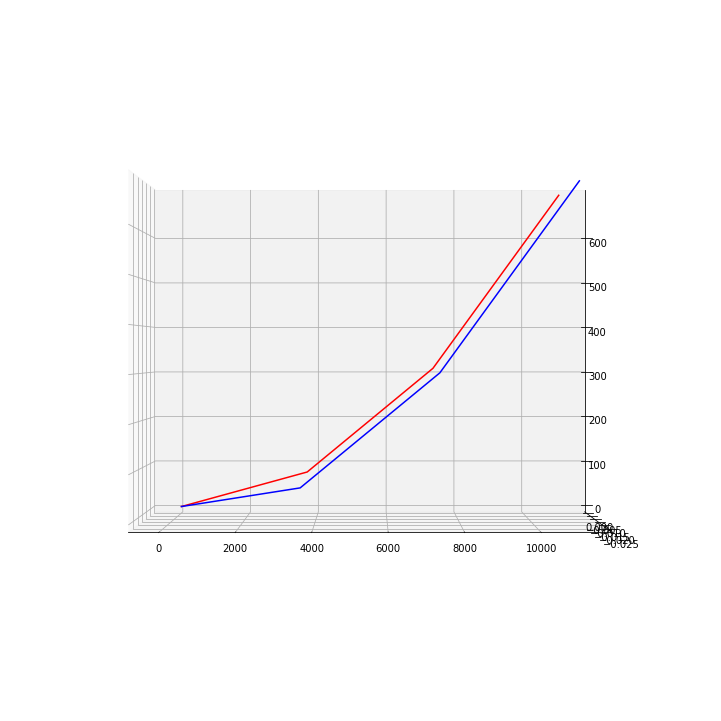

In [221]:
fig=plt.figure(figsize=(13,13))
ax = fig.gca(projection='3d')

X0=fin.y.T[0,[i for i in range(0,node_N)]]
Y0=fin.y.T[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin.y.T[0,[i for i in range(4*node_N,5*node_N)]]
# for j in range(len(fin.y.T)):
j=-1
X=fin.y.T[j,[i for i in range(0,node_N)]]
Y=fin.y.T[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin.y.T[j,[i for i in range(4*node_N,5*node_N)]]
# X0=x0
# Y0=[0 for i in range(node_N)]
# Z0=z0
# X=[fin[i] for i in range(0,node_N)]
# Y=[fin[i] for i in range(2*node_N,3*node_N)]
# Z=[fin[i] for i in range(4*node_N,5*node_N)]
ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
ax.view_init(-30,-30)
ax.view_init(0,-90)
    # ax.set_xlim([0, 5])
    # ax.set_ylim([0, 5])
plt.show()

In [222]:
X,Y,Z

(array([    0.        ,  3680.52313543,  7368.58525023, 11052.9426164 ]),
 array([ 0.        , -0.02832315, -0.02830633, -0.02829316]),
 array([  0.        ,  71.78296286, 303.12190037, 689.13663622]))

In [223]:
X0,Y0,Z0

(array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446]),
 array([0., 0., 0., 0.]),
 array([  0.        ,  77.06804645, 308.4070593 , 694.42189511]))

In [224]:
us=fin.y

In [225]:
t=np.arange(tspan[0],tspan[1],tspan[1]/len(us.T))

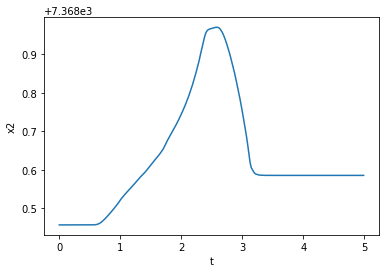

In [226]:
plt.plot(t[:5000],us.T[:,2][:5000] ,'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

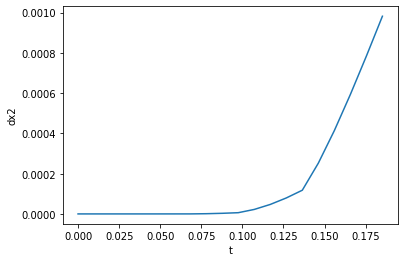

In [227]:
plt.plot(t[:20],us.T[:,6][:20] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

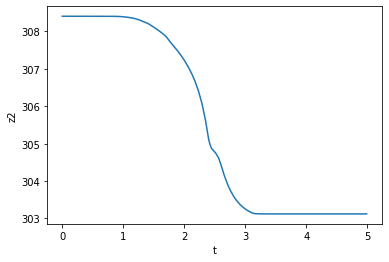

In [228]:
plt.plot(t[:5000],us.T[:,18][:5000] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

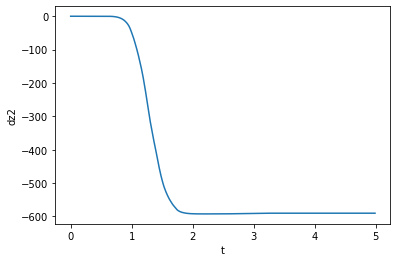

In [229]:
plt.plot(t[:5000],us.T[:,22][:5000] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

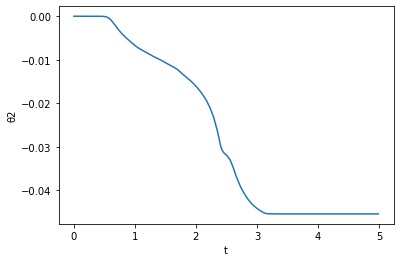

In [230]:
plt.plot(t[:5000],us.T[:,34][:5000] ,'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

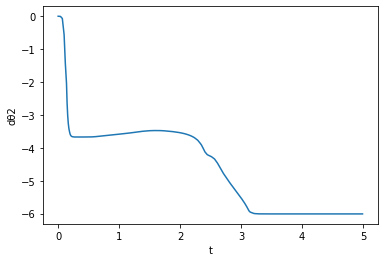

In [231]:
plt.plot(t[:5000],us.T[:,38][:5000] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

In [232]:
# E = 210e9

In [233]:
# E*Ar

In [234]:
# 1e10

In [235]:
# import torch

In [236]:
# A = torch.randn(20,3,3)
# B = torch.randn(20,3)
# X = torch.linalg.lstsq(A, B).solution # A is broadcasted to shape (2, 3, 3)


In [237]:
# X

In [238]:
# type(A)

In [239]:
# X.shape

In [240]:
# plot3D(fin, numDataPoints, FPS, filename, 3)